In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
# Step 1: Load Data
# Load the workout data and music data
workout_data = pd.read_csv('/Users/cagdaskahraman/Dsa_210/workout_data.csv')
music_data = pd.read_csv('/Users/cagdaskahraman/Dsa_210/music_spoti.csv')

In [4]:
# Step 2: Prepare and Clean Data
# Convert workout and music time columns to datetime format for merging
# Replace Turkish month names with English equivalents for accurate conversion
turkish_to_english_months = {
    'Oca': 'Jan', 'Şub': 'Feb', 'Mar': 'Mar', 'Nis': 'Apr', 'May': 'May', 'Haz': 'Jun',
    'Tem': 'Jul', 'Ağu': 'Aug', 'Eyl': 'Sep', 'Eki': 'Oct', 'Kas': 'Nov', 'Ara': 'Dec'
}
workout_data['start_time'] = workout_data['start_time'].replace(turkish_to_english_months, regex=True)
workout_data['end_time'] = workout_data['end_time'].replace(turkish_to_english_months, regex=True)
workout_data['start_time'] = pd.to_datetime(workout_data['start_time'], format='%d %b %Y, %H:%M', errors='coerce')
workout_data['end_time'] = pd.to_datetime(workout_data['end_time'], format='%d %b %Y, %H:%M', errors='coerce')
music_data['Start Time'] = pd.to_datetime(music_data['Start Time'])
music_data['End Time'] = pd.to_datetime(music_data['End Time'])


In [5]:
# Step 3: Match Music Genres with Workouts
# Match each workout session with the corresponding music genres based on time overlap
matched_genres = []
for _, workout_row in workout_data.iterrows():
    overlapping_music = music_data[
        (music_data['Start Time'] <= workout_row['end_time']) &
        (music_data['End Time'] >= workout_row['start_time'])
    ]
    genres = overlapping_music['Genre'].tolist()
    matched_genres.append(genres)
workout_data['matched_genres'] = matched_genres


In [6]:
# Step 4: Calculate Total Weight
# Add a column for total weight lifted during each workout
workout_data['total_weight'] = workout_data['weight_kg'] * workout_data['reps']


In [7]:
# Step 5: Clean Data
# Remove rows with missing or invalid values for weight and reps
cleaned_workout_data = workout_data.dropna(subset=['weight_kg', 'reps', 'total_weight'])
cleaned_workout_data = cleaned_workout_data[
    (cleaned_workout_data['weight_kg'] > 0) &
    (cleaned_workout_data['reps'] > 0) &
    (cleaned_workout_data['total_weight'] > 0)
]

In [9]:
# Step 6: Analyze Effects of Genres
# Ensure 'average_weight_per_set' is calculated before grouping
cleaned_workout_data['average_weight_per_set'] = cleaned_workout_data['total_weight'] / cleaned_workout_data['reps']

# Group data by music genres and calculate total weight lifted and average weight per set
exercise_genre_effects = cleaned_workout_data.explode('matched_genres').groupby(
    ['exercise_title', 'matched_genres']
).agg({
    'total_weight': 'sum',
    'average_weight_per_set': 'mean'
}).reset_index()


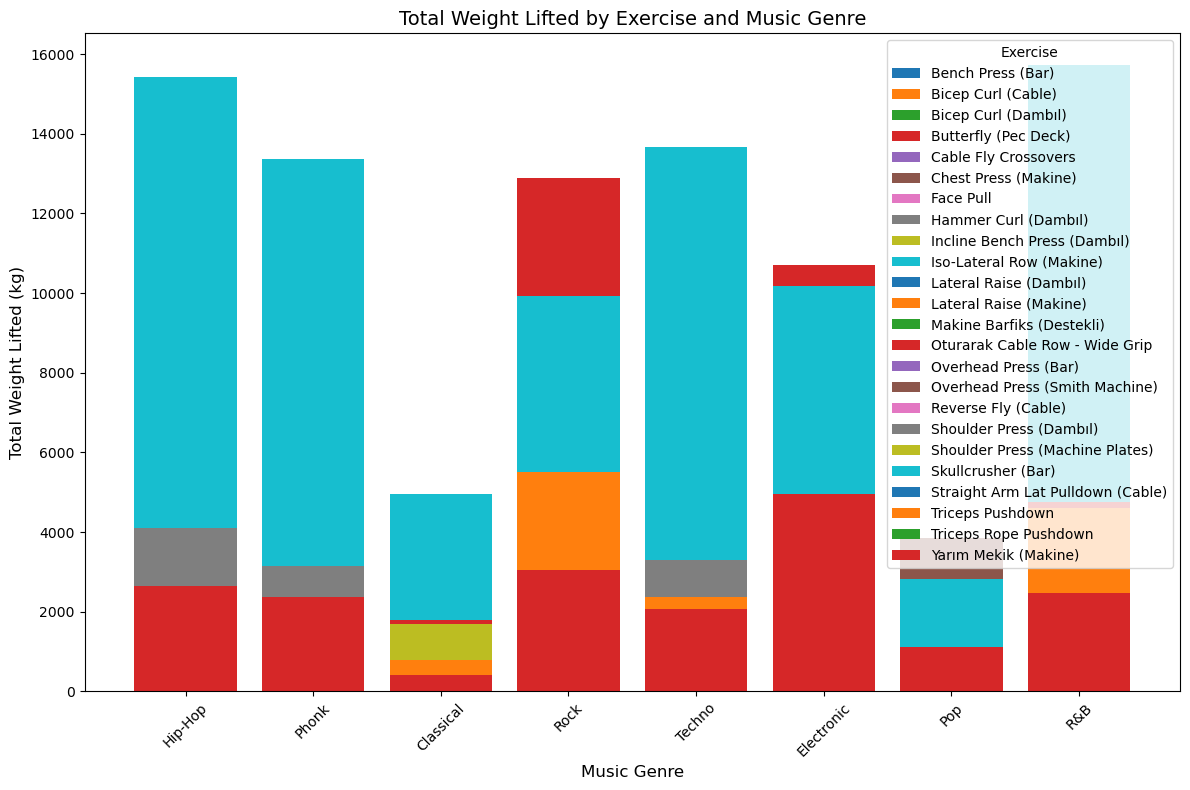

In [10]:
# Step 7: Visualize Results
# Create a bar plot for total weight lifted by exercise and music genre
plt.figure(figsize=(12, 8))
for exercise in exercise_genre_effects['exercise_title'].unique():
    subset = exercise_genre_effects[exercise_genre_effects['exercise_title'] == exercise]
    plt.bar(subset['matched_genres'], subset['total_weight'], label=exercise)
plt.title('Total Weight Lifted by Exercise and Music Genre', fontsize=14)
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Total Weight Lifted (kg)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Exercise', fontsize=10)
plt.tight_layout()
plt.show()

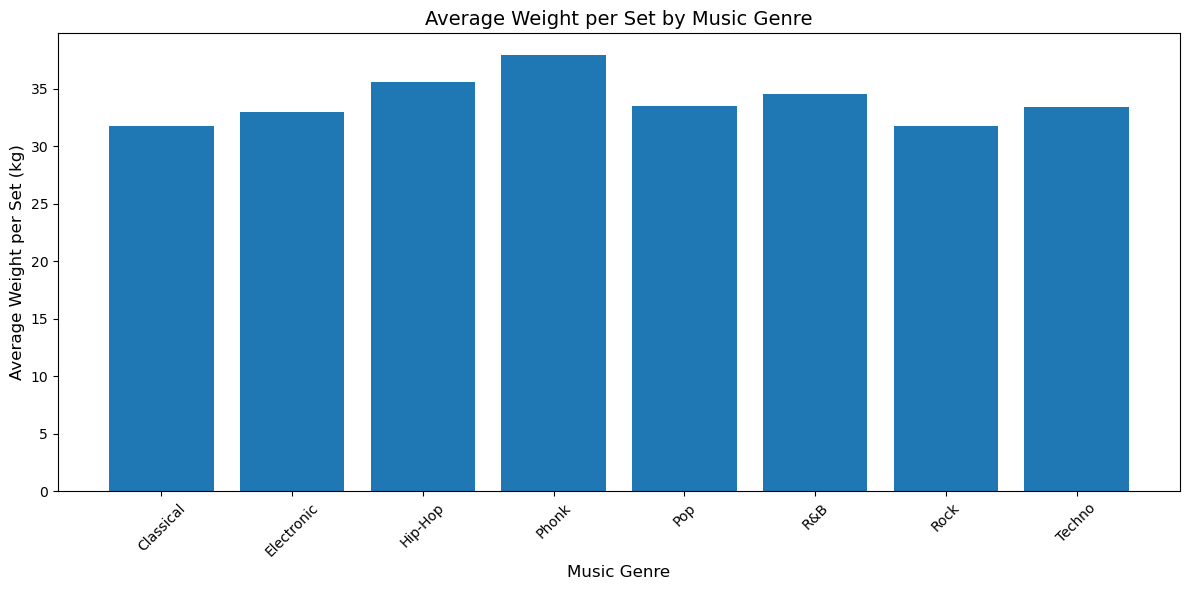

In [16]:
# Additional Visualization: Average Weight per Set by Genre
plt.figure(figsize=(12, 6))
exercise_avg_weight = cleaned_workout_data.explode('matched_genres').groupby('matched_genres').agg({
    'average_weight_per_set': 'mean'
}).reset_index()
plt.bar(exercise_avg_weight['matched_genres'], exercise_avg_weight['average_weight_per_set'])
plt.title('Average Weight per Set by Music Genre', fontsize=14)
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Average Weight per Set (kg)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

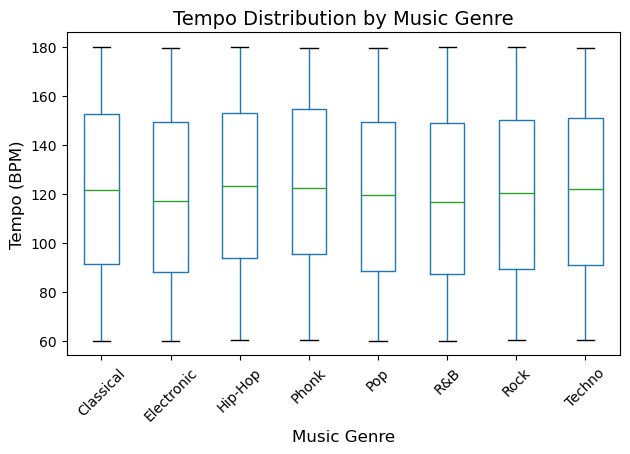

In [17]:
# Additional Visualization: Tempo Distribution by Genre
plt.figure(figsize=(12, 6))
music_data.boxplot(column='Tempo', by='Genre', grid=False, rot=45)
plt.title('Tempo Distribution by Music Genre', fontsize=14)
plt.suptitle('')
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Tempo (BPM)', fontsize=12)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

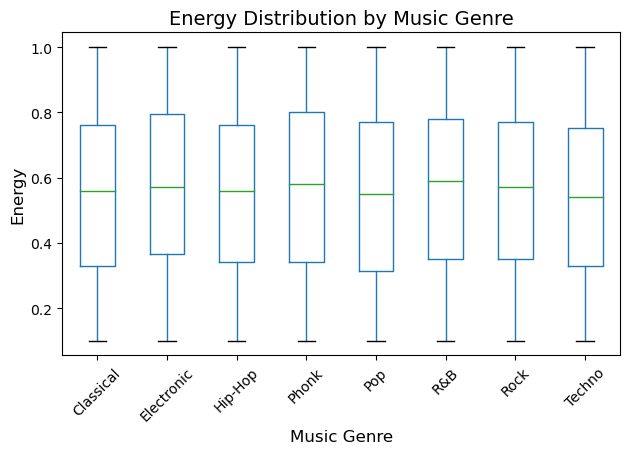

In [18]:
# Additional Visualization: Energy Distribution by Genre
plt.figure(figsize=(12, 6))
music_data.boxplot(column='Energy', by='Genre', grid=False, rot=45)
plt.title('Energy Distribution by Music Genre', fontsize=14)
plt.suptitle('')
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
# Analyze tempo and energy features using linear regression
music_features = music_data[['Tempo', 'Energy']]
music_features = StandardScaler().fit_transform(music_features)
music_features_df = pd.DataFrame(music_features, columns=['Tempo', 'Energy'])
music_features_df['Genre'] = music_data['Genre']
merged_data = music_features_df.merge(
    cleaned_workout_data.explode('matched_genres')[['matched_genres', 'total_weight']].rename(columns={'matched_genres': 'Genre'}),
    on='Genre',
    how='inner'
).dropna(subset=['total_weight'])
X = merged_data[['Tempo', 'Energy']]
y = merged_data['total_weight']
regression_model = LinearRegression().fit(X, y)
regression_coefficients = regression_model.coef_
regression_r2 = regression_model.score(X, y)


In [21]:
# Display analysis results
print("Regression Coefficients:", regression_coefficients)
print("R-squared:", regression_r2)

Regression Coefficients: [ 0.75973669 -0.00391768]
R-squared: 1.2185985397428212e-05


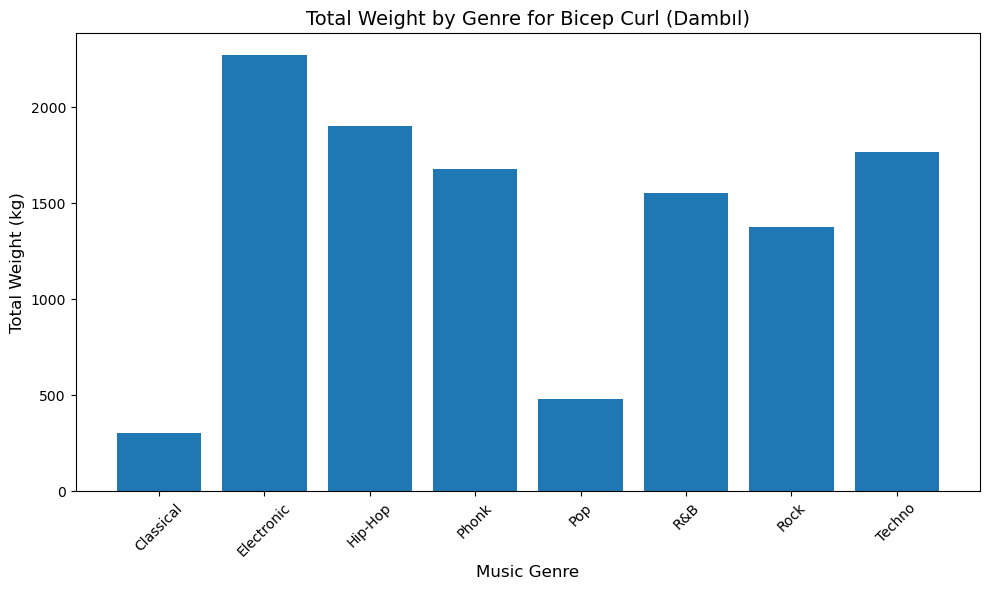

<Figure size 1000x600 with 0 Axes>

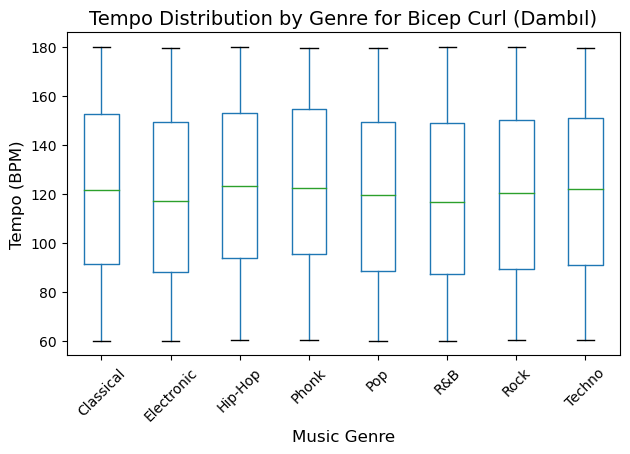

<Figure size 1000x600 with 0 Axes>

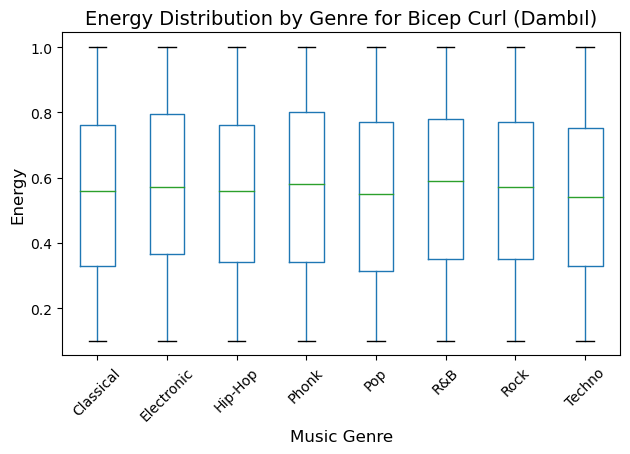

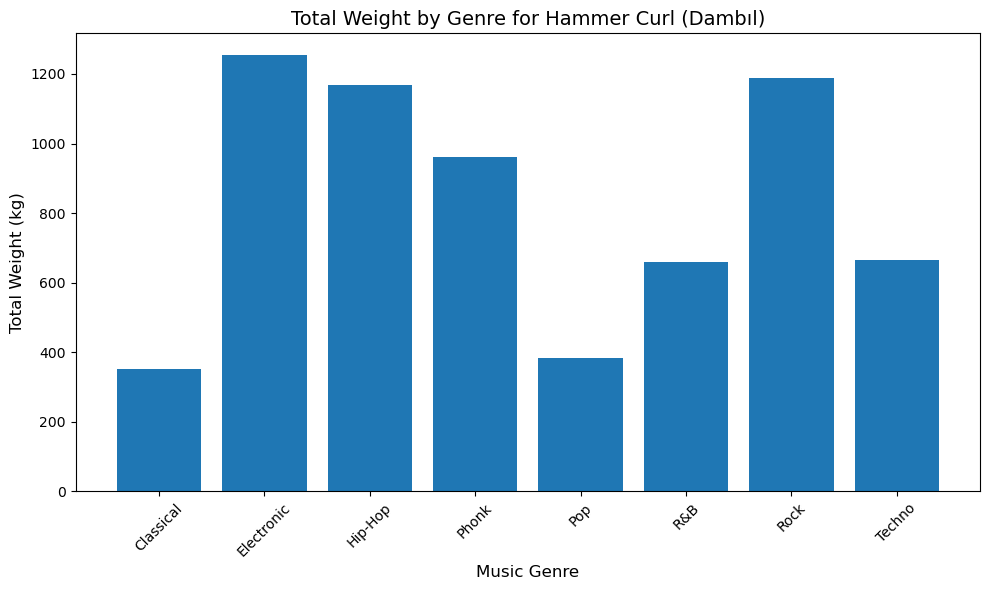

<Figure size 1000x600 with 0 Axes>

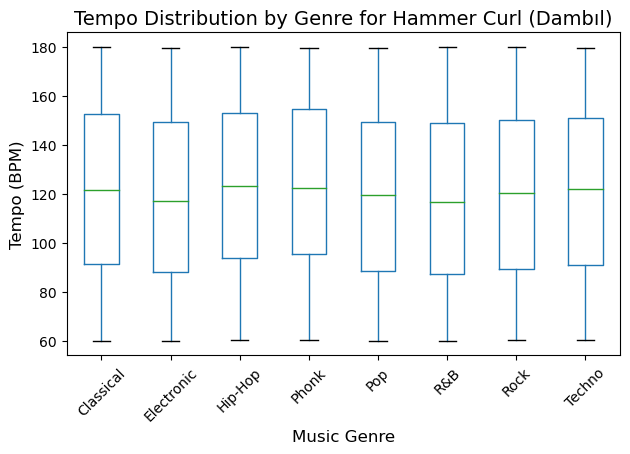

<Figure size 1000x600 with 0 Axes>

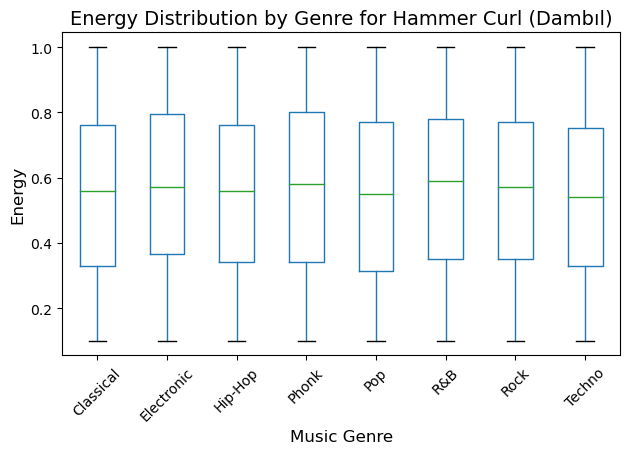

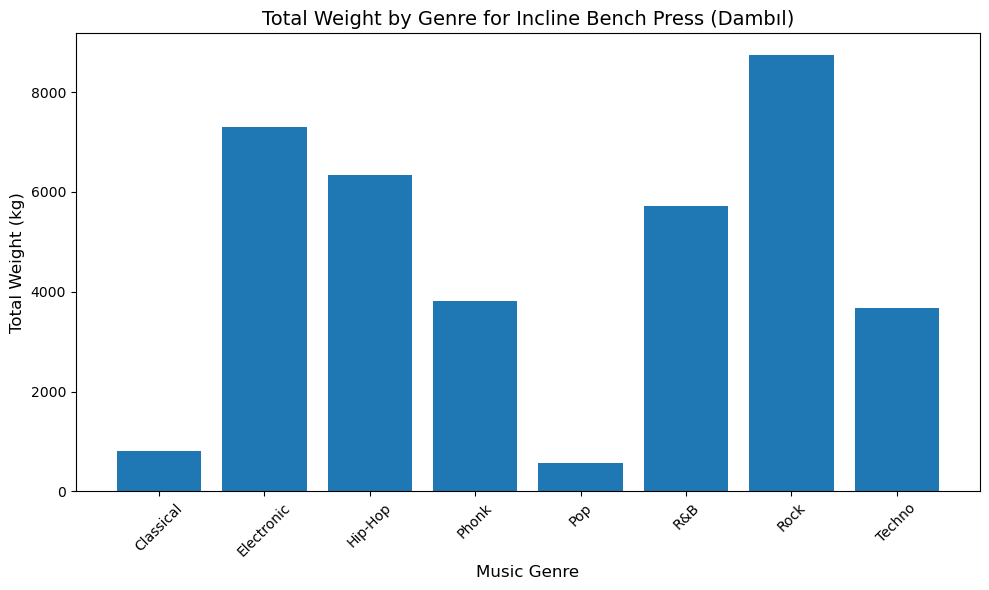

<Figure size 1000x600 with 0 Axes>

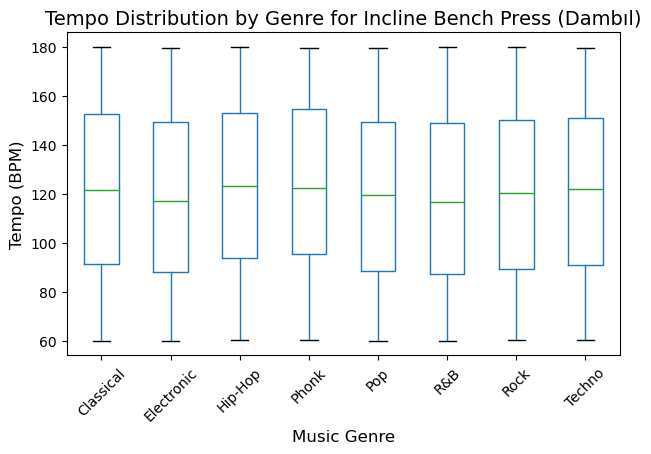

<Figure size 1000x600 with 0 Axes>

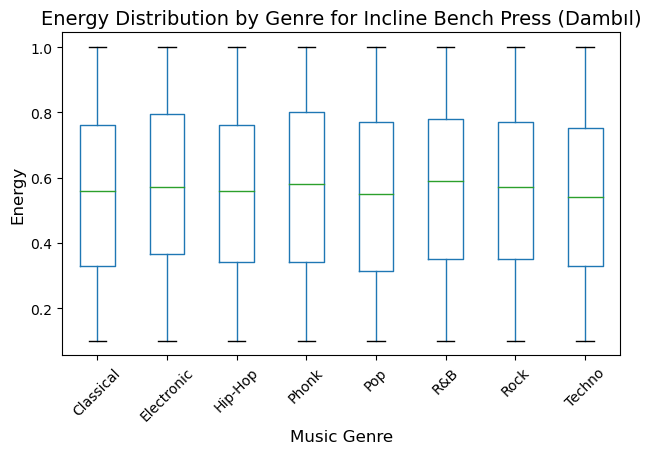

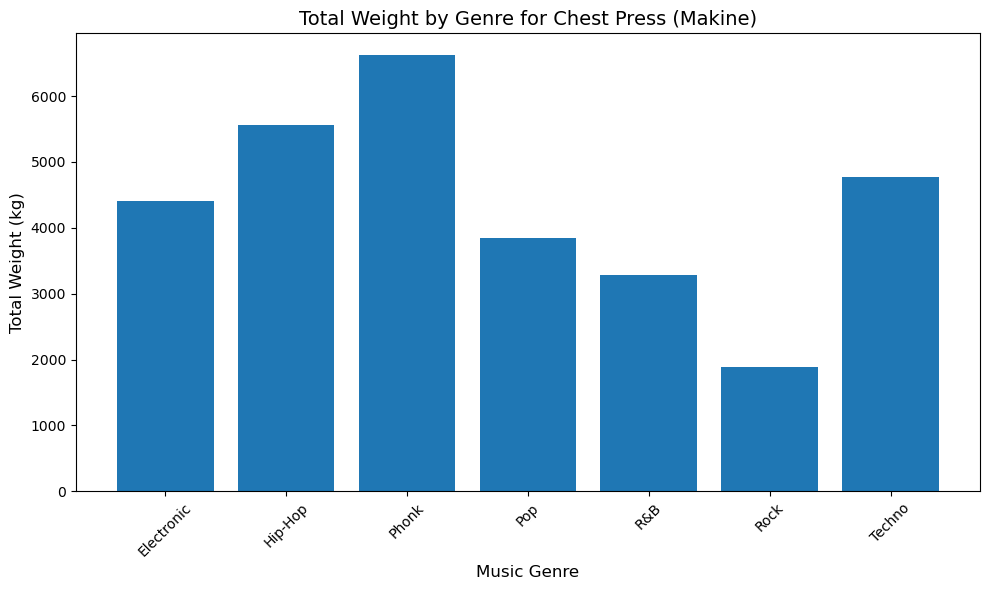

<Figure size 1000x600 with 0 Axes>

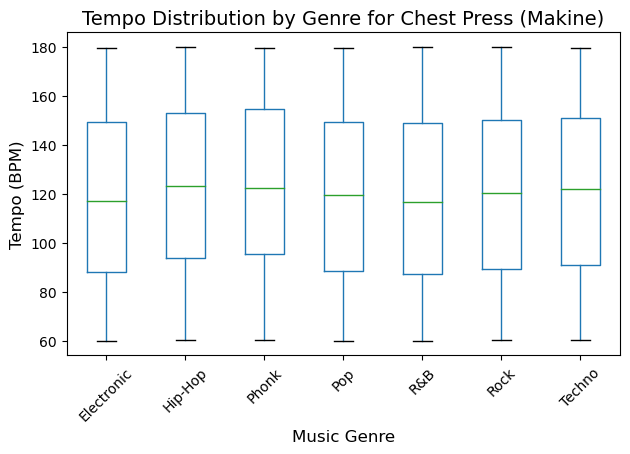

<Figure size 1000x600 with 0 Axes>

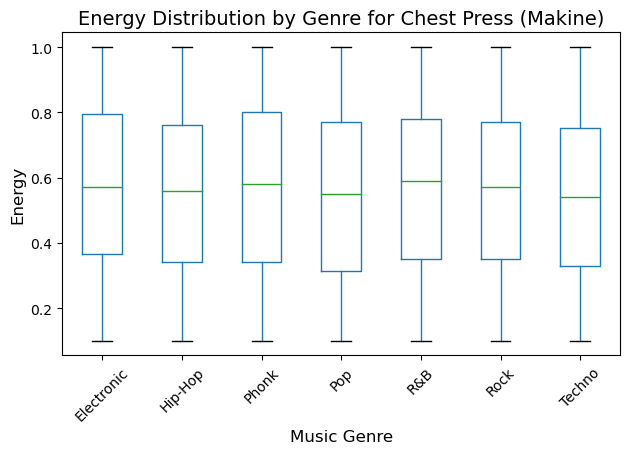

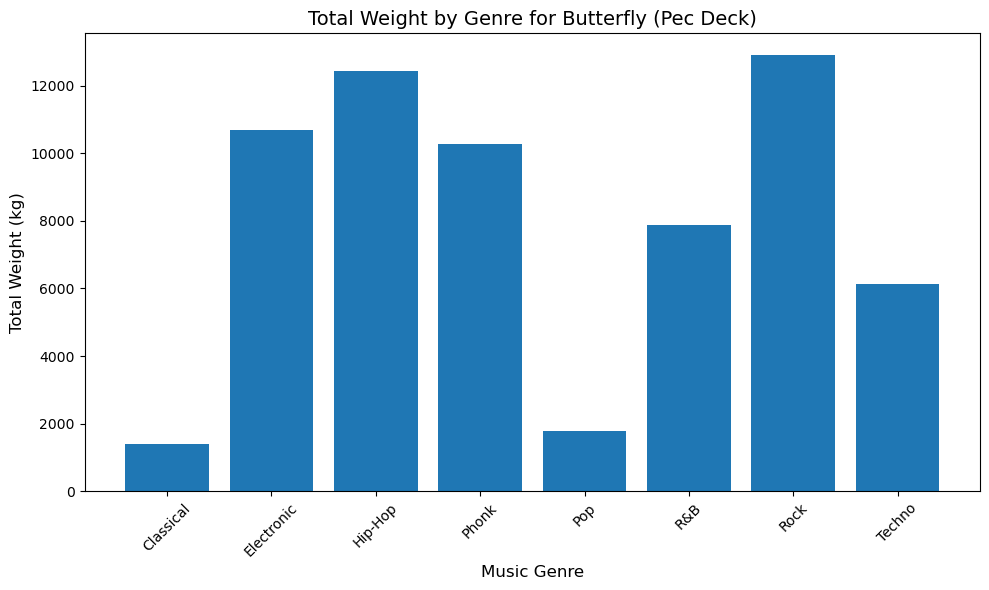

<Figure size 1000x600 with 0 Axes>

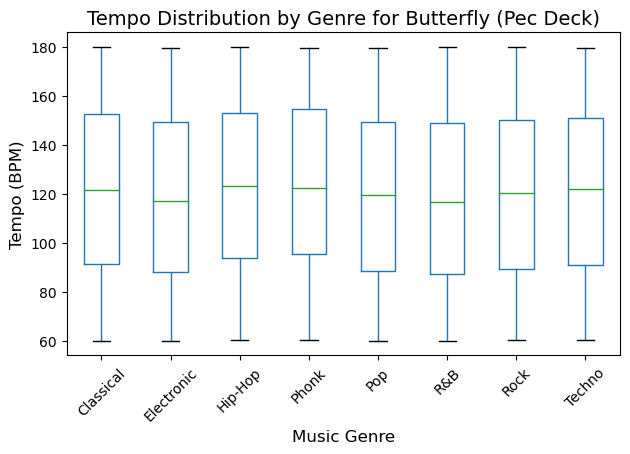

<Figure size 1000x600 with 0 Axes>

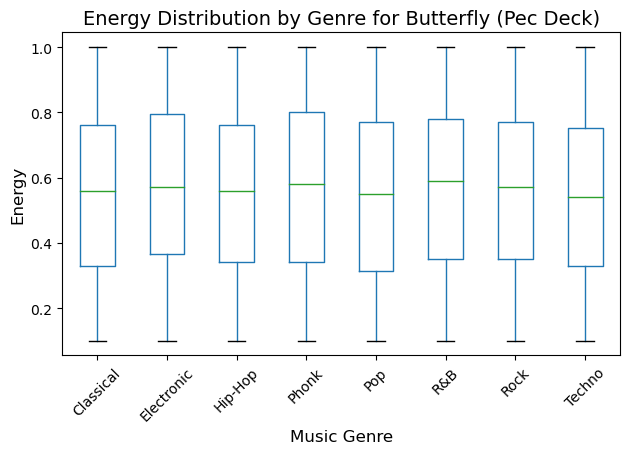

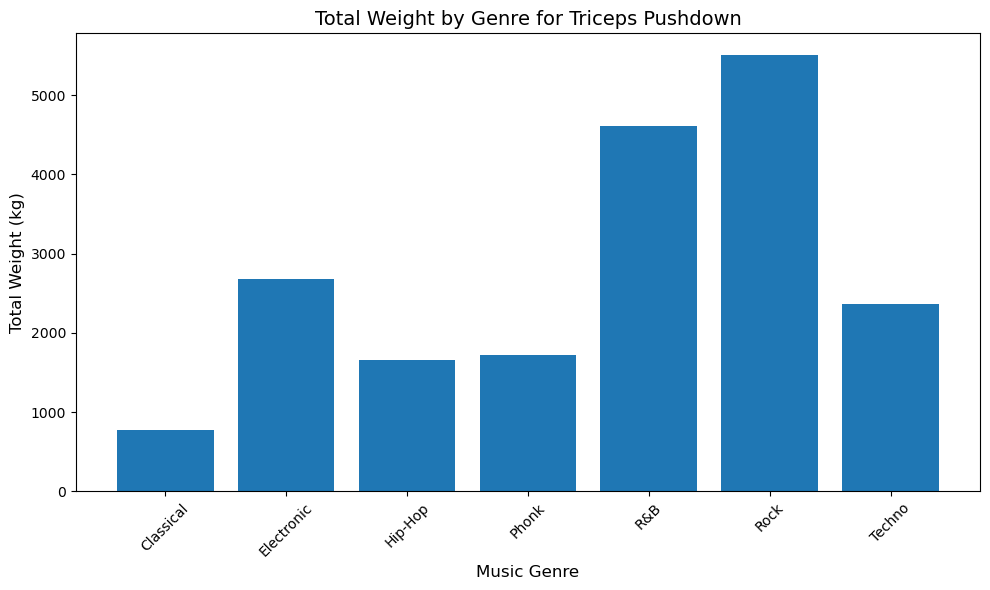

<Figure size 1000x600 with 0 Axes>

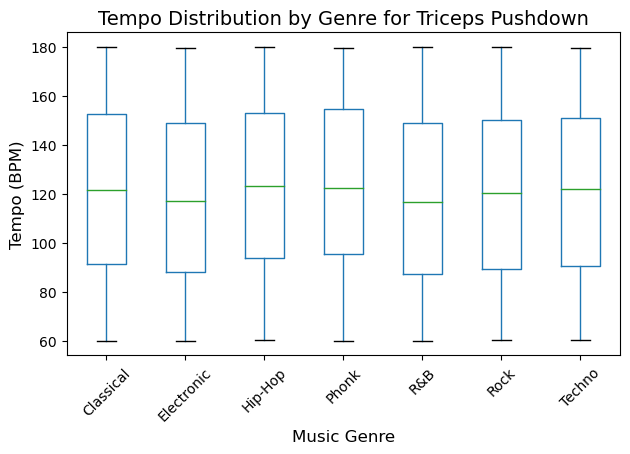

<Figure size 1000x600 with 0 Axes>

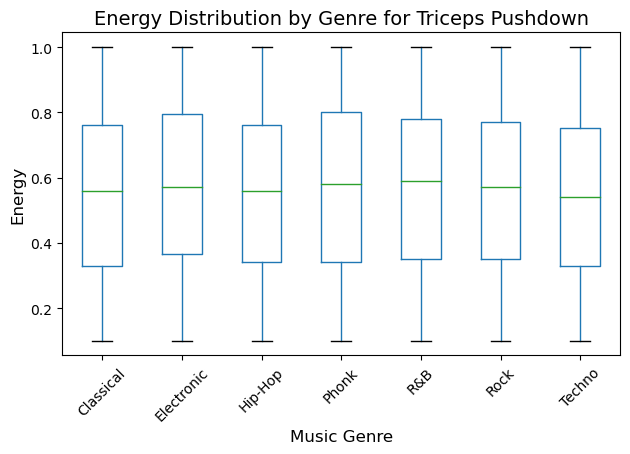

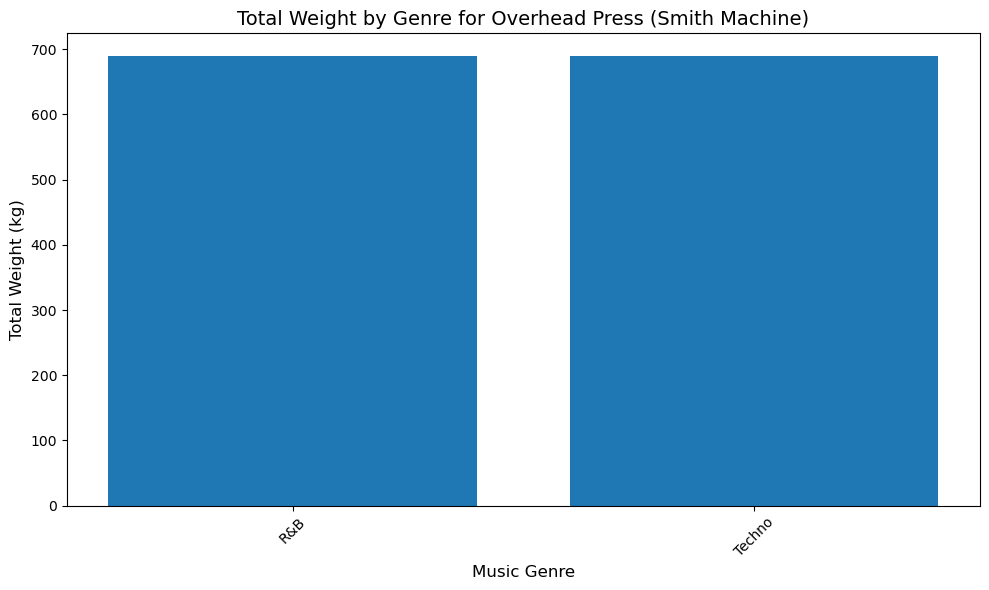

<Figure size 1000x600 with 0 Axes>

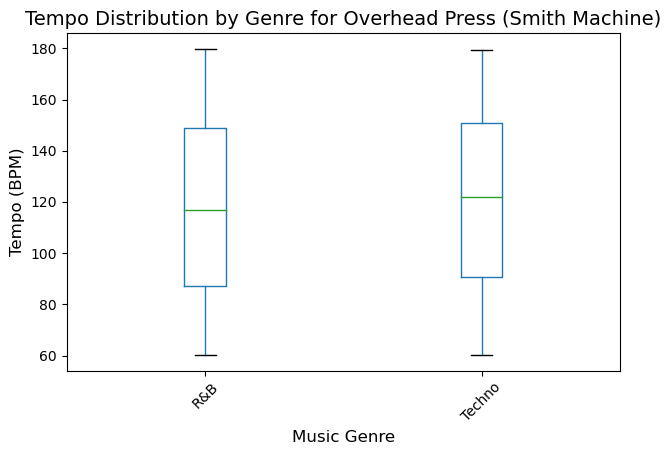

<Figure size 1000x600 with 0 Axes>

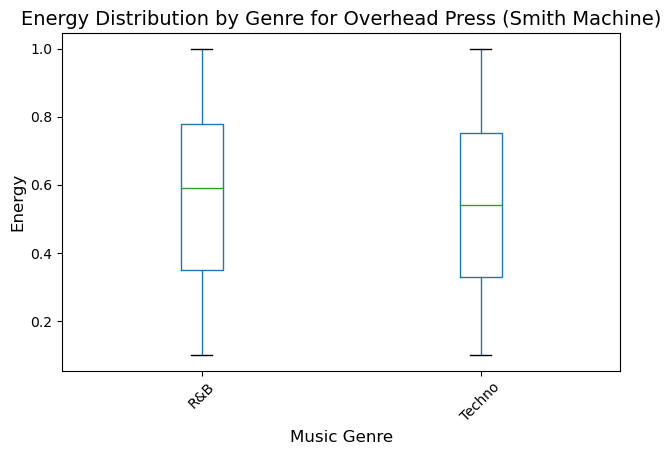

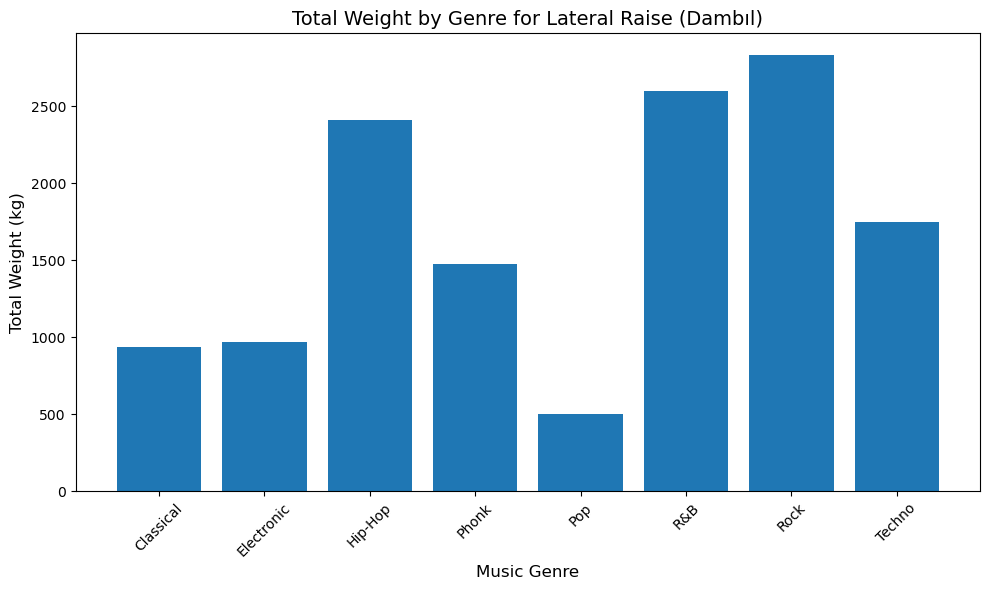

<Figure size 1000x600 with 0 Axes>

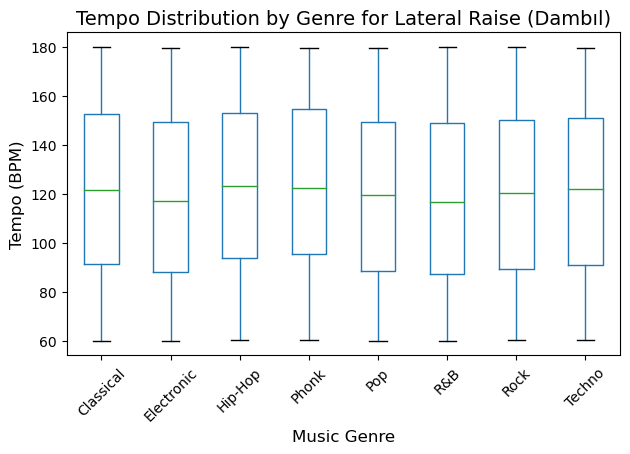

<Figure size 1000x600 with 0 Axes>

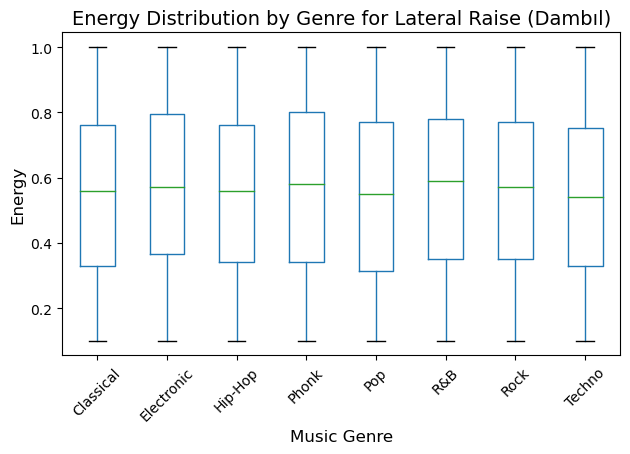

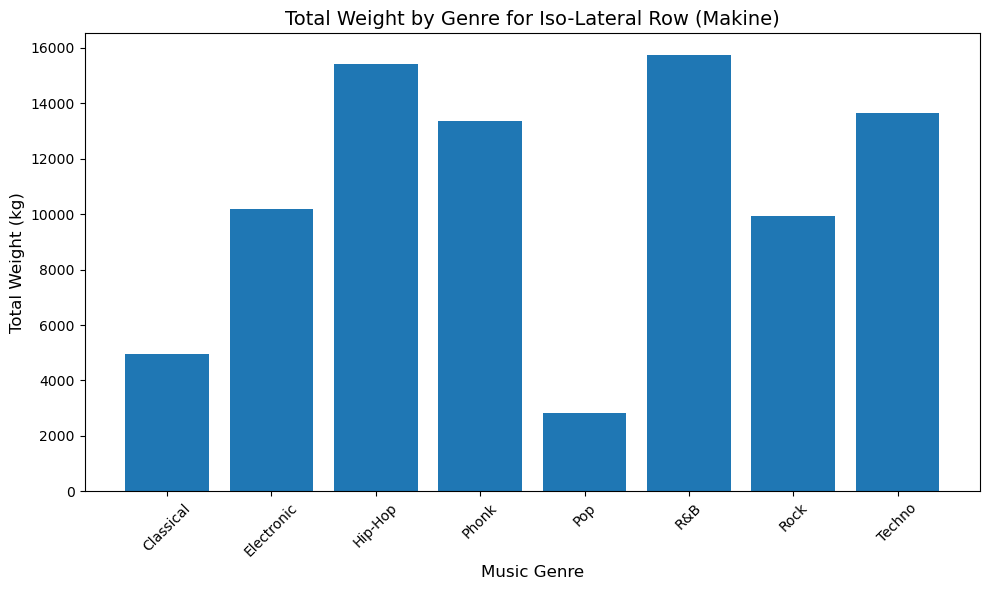

<Figure size 1000x600 with 0 Axes>

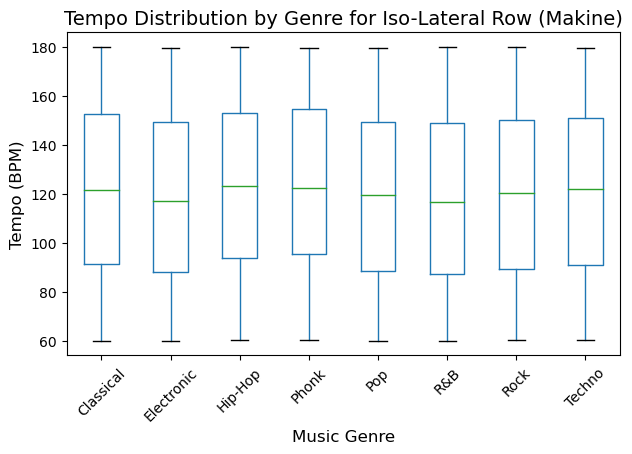

<Figure size 1000x600 with 0 Axes>

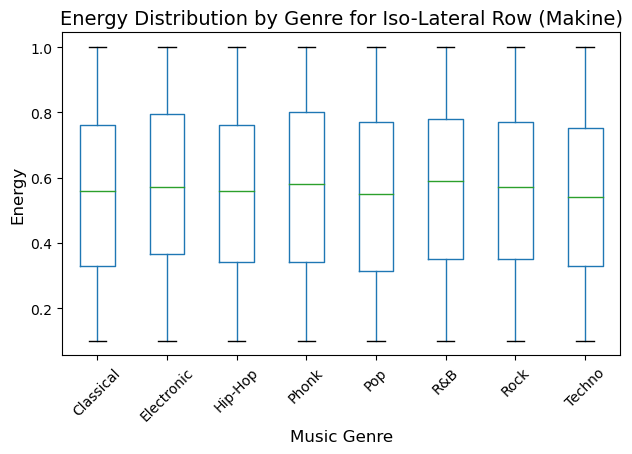

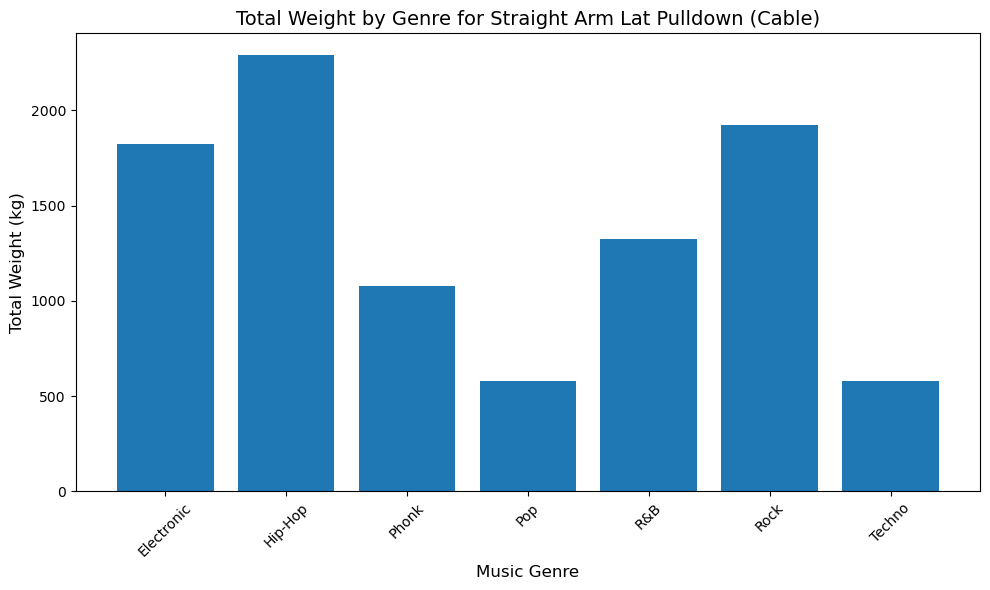

<Figure size 1000x600 with 0 Axes>

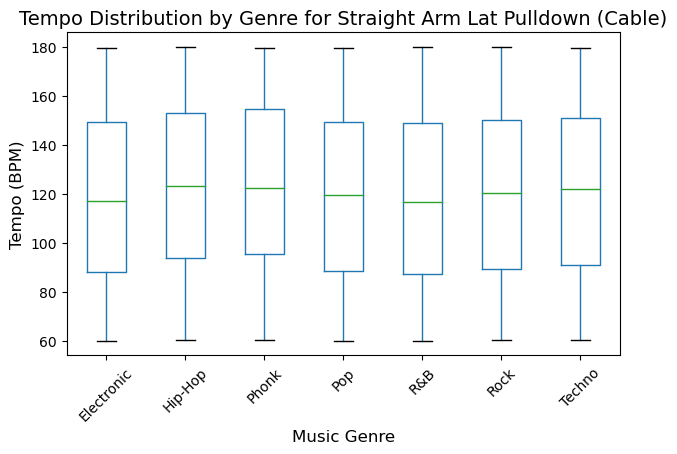

<Figure size 1000x600 with 0 Axes>

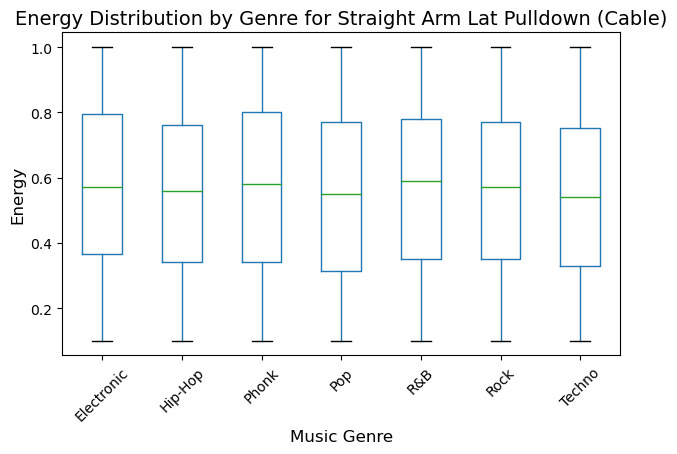

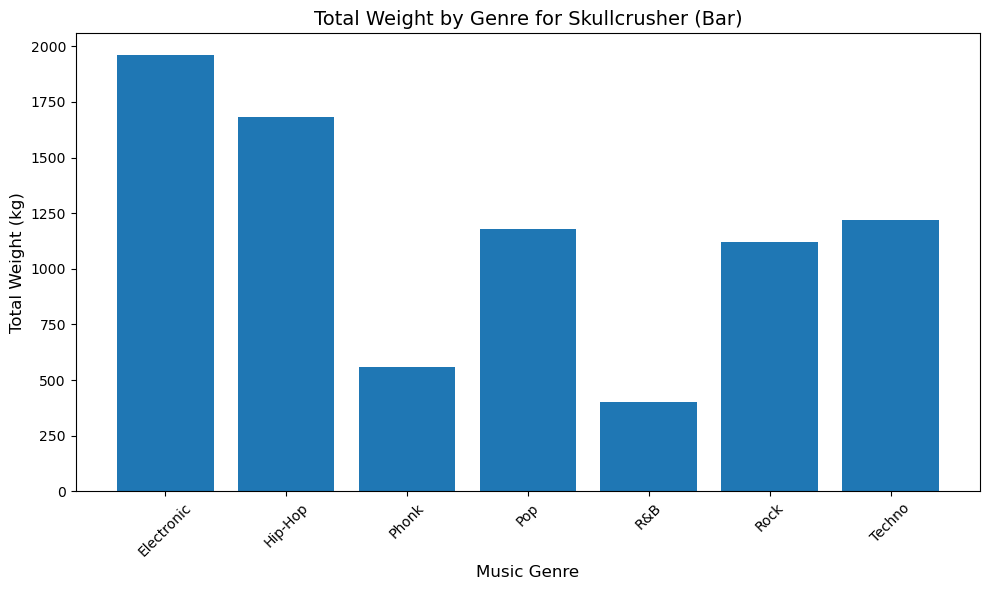

<Figure size 1000x600 with 0 Axes>

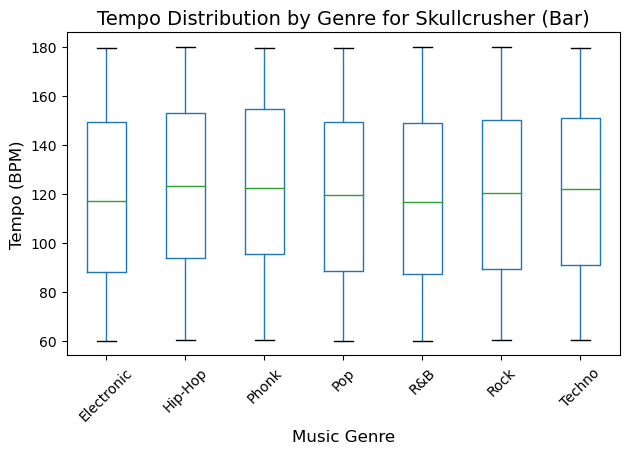

<Figure size 1000x600 with 0 Axes>

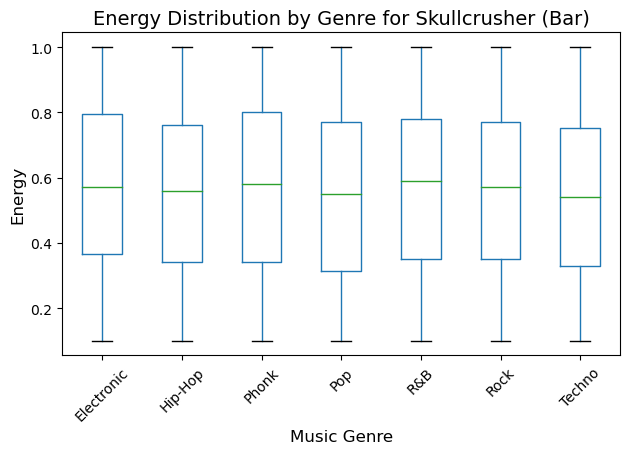

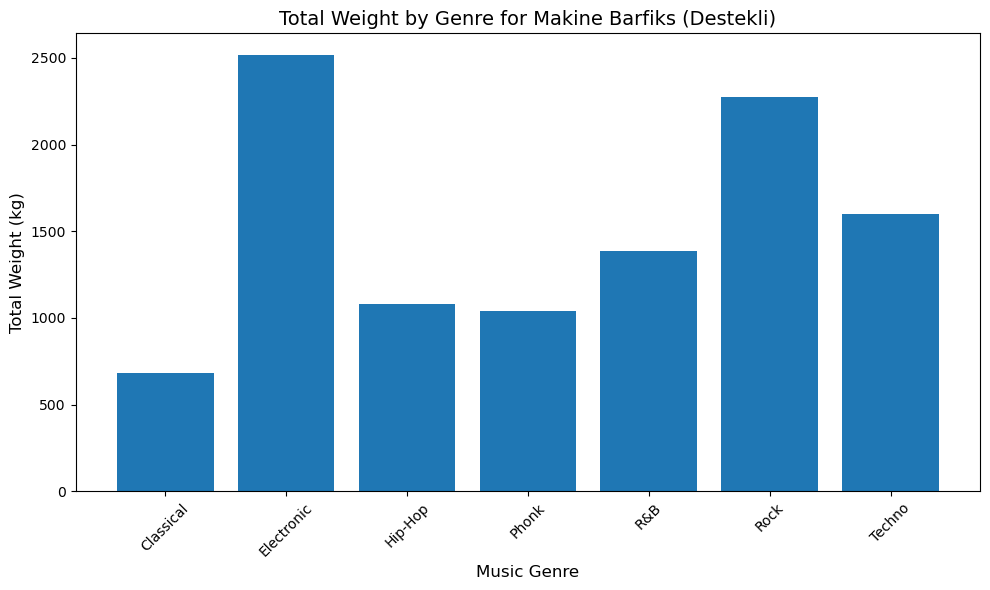

<Figure size 1000x600 with 0 Axes>

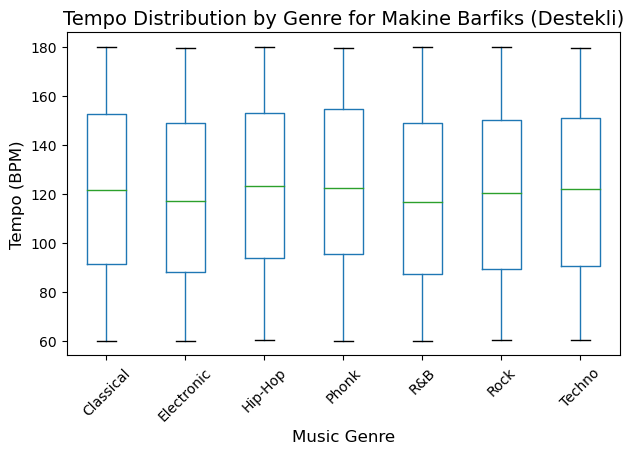

<Figure size 1000x600 with 0 Axes>

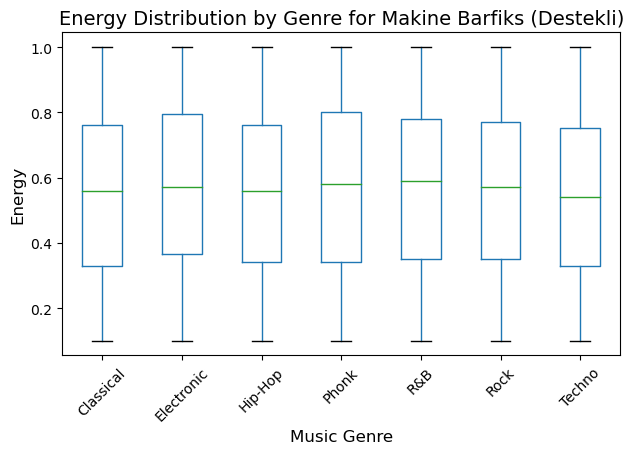

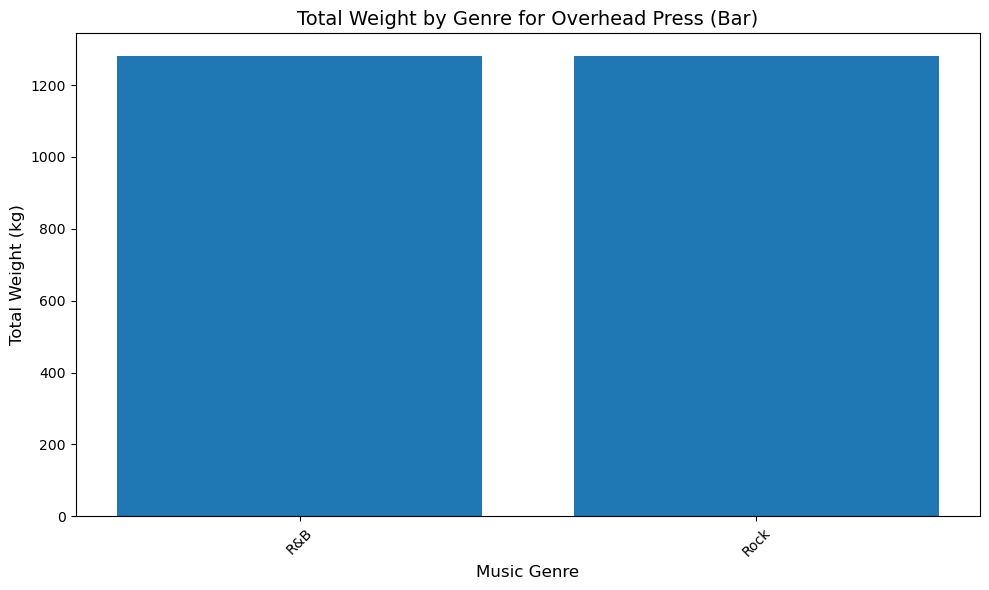

<Figure size 1000x600 with 0 Axes>

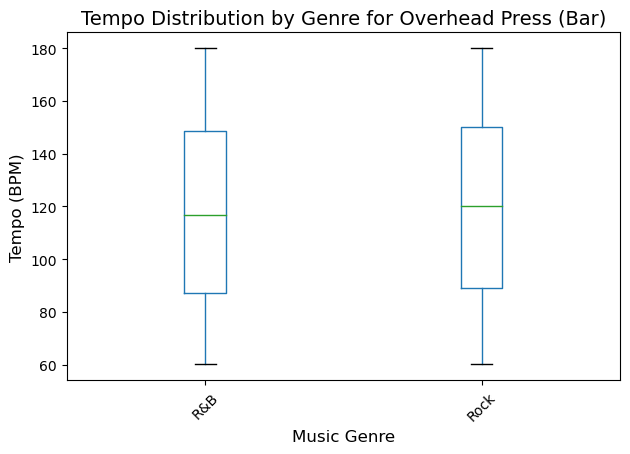

<Figure size 1000x600 with 0 Axes>

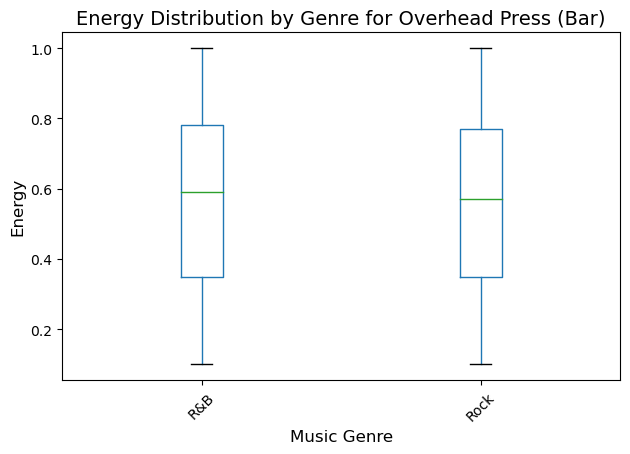

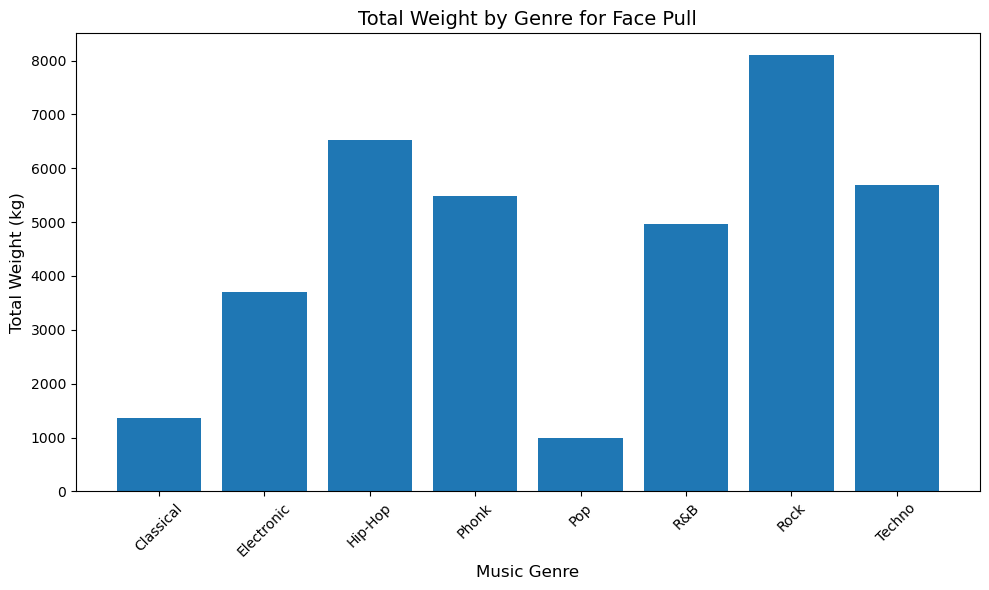

<Figure size 1000x600 with 0 Axes>

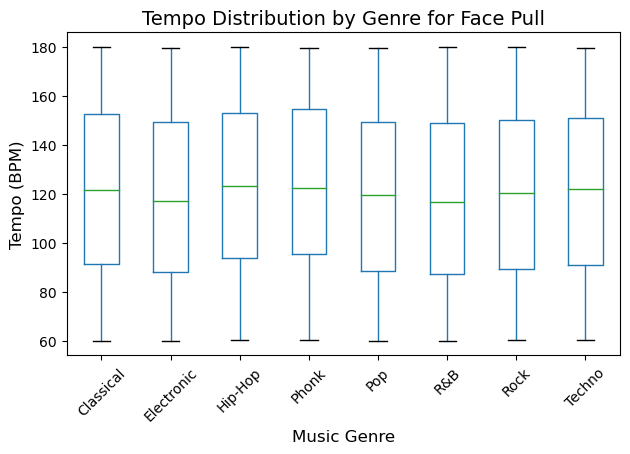

<Figure size 1000x600 with 0 Axes>

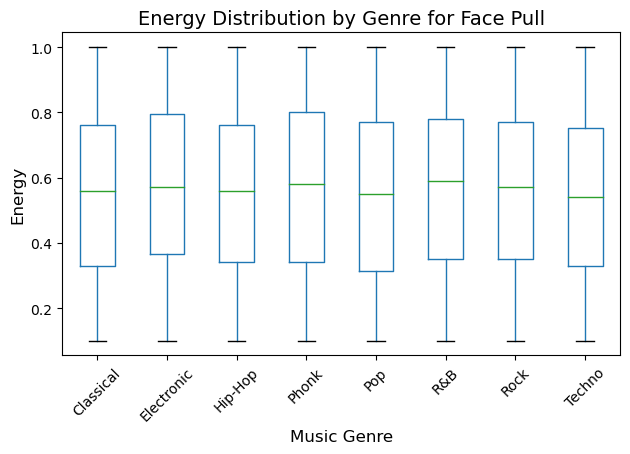

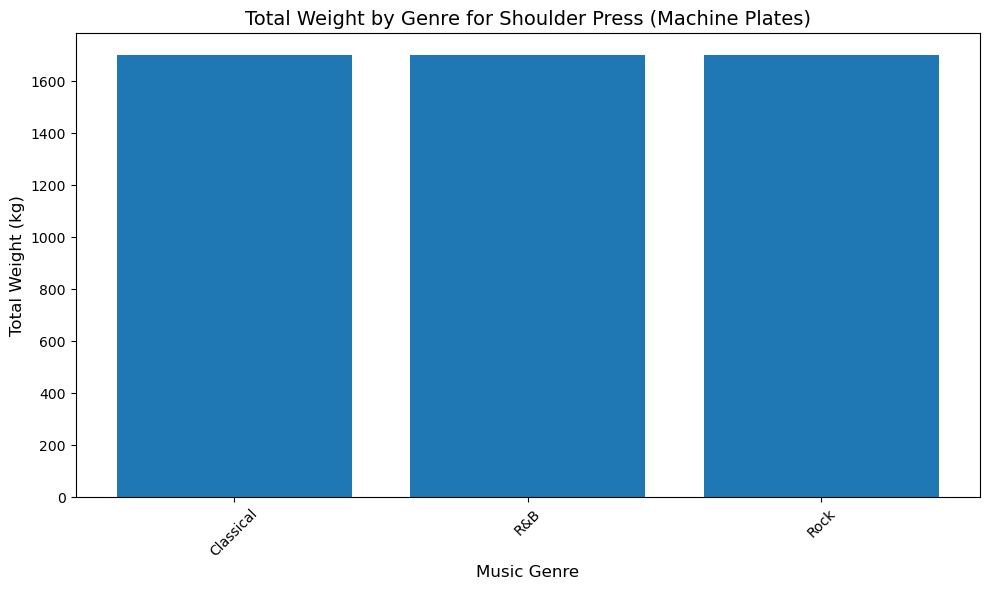

<Figure size 1000x600 with 0 Axes>

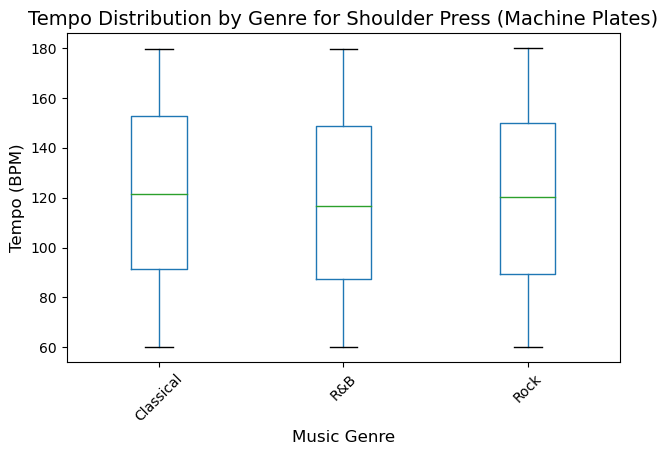

<Figure size 1000x600 with 0 Axes>

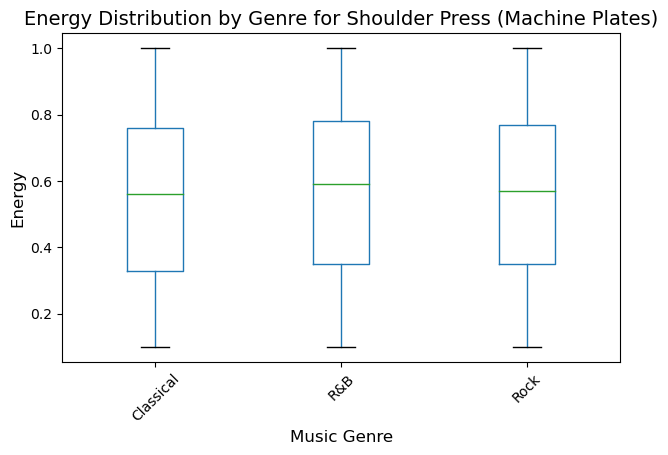

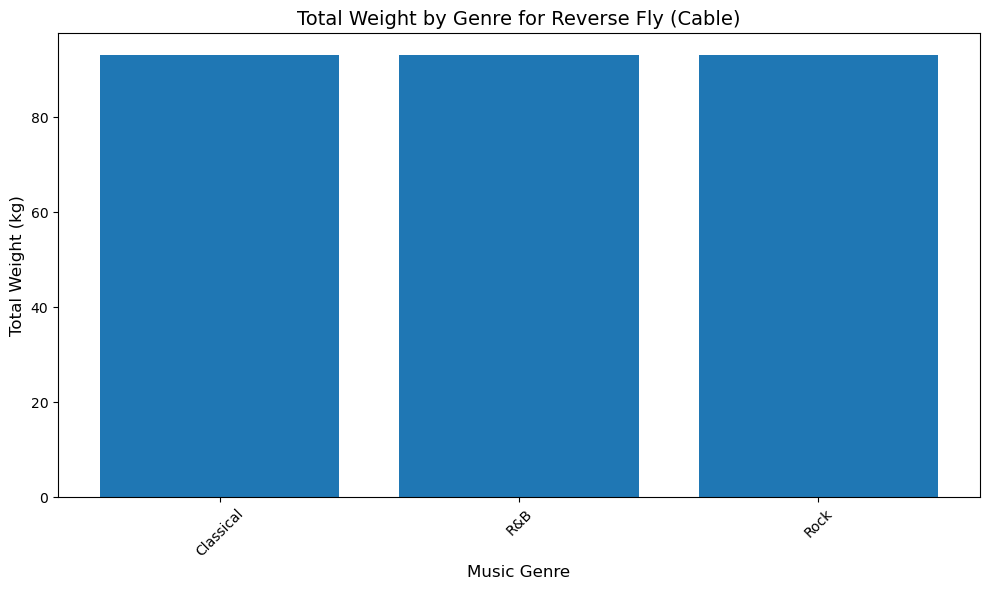

<Figure size 1000x600 with 0 Axes>

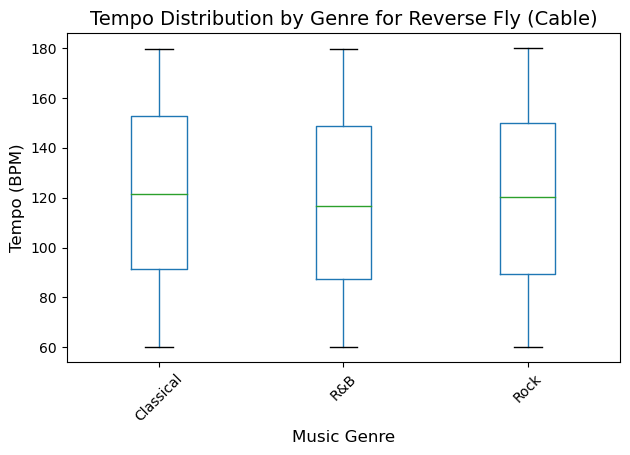

<Figure size 1000x600 with 0 Axes>

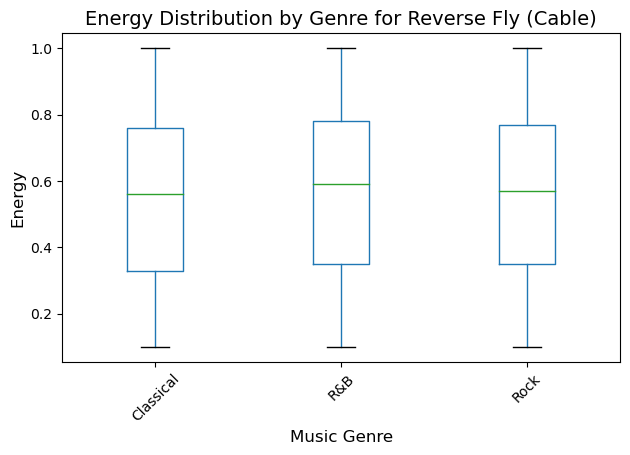

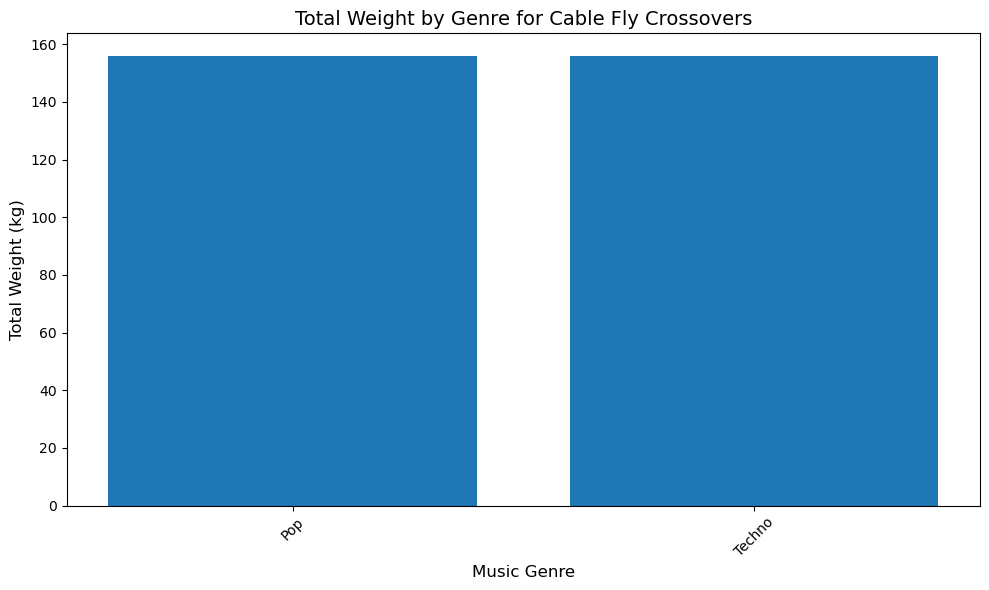

<Figure size 1000x600 with 0 Axes>

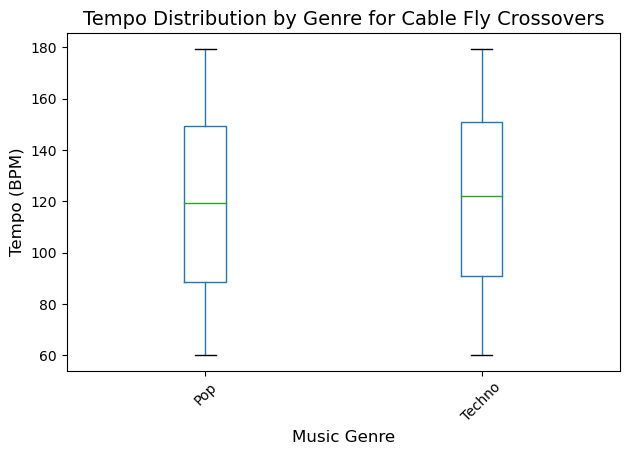

<Figure size 1000x600 with 0 Axes>

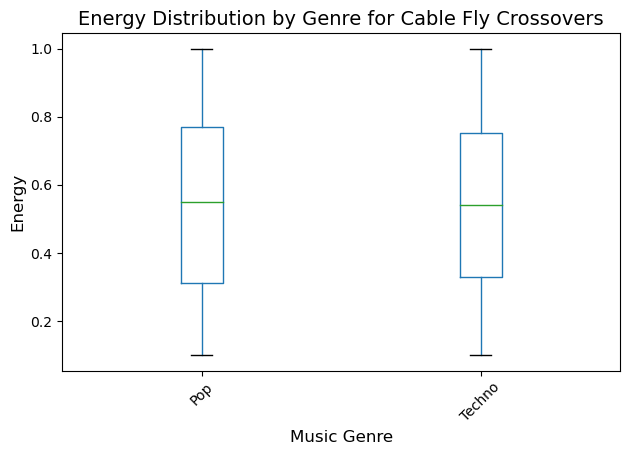

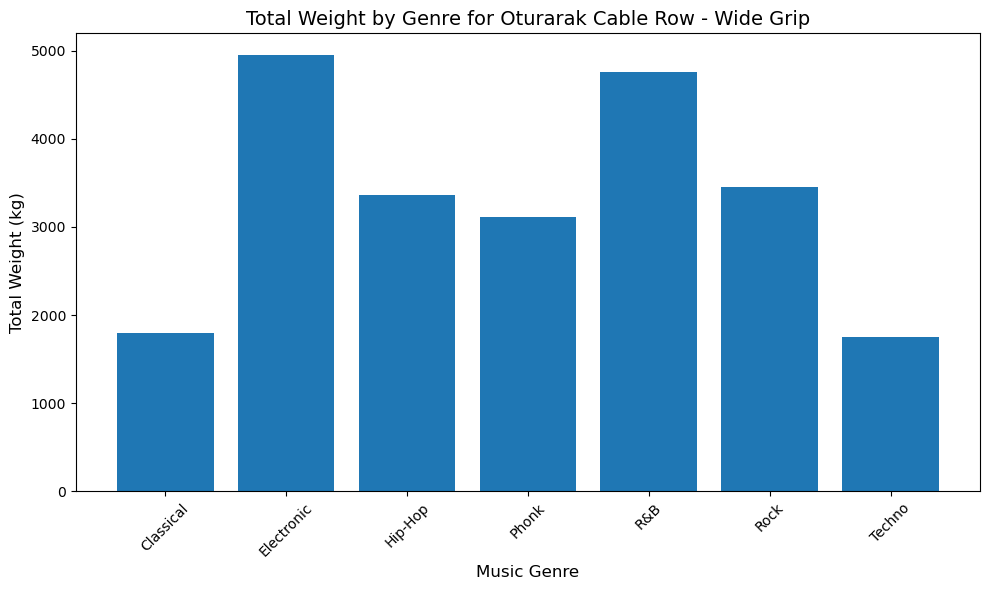

<Figure size 1000x600 with 0 Axes>

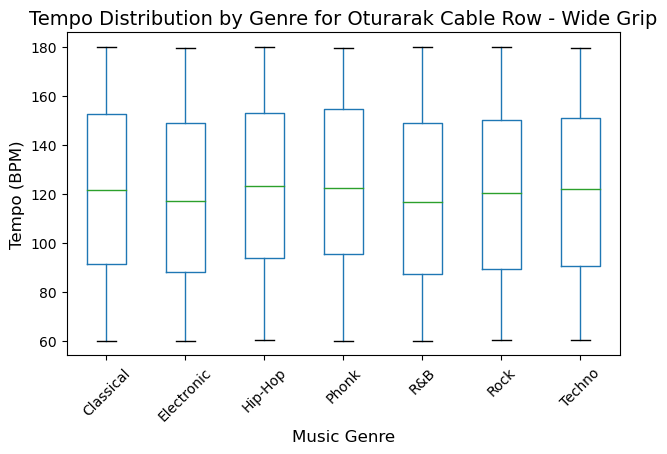

<Figure size 1000x600 with 0 Axes>

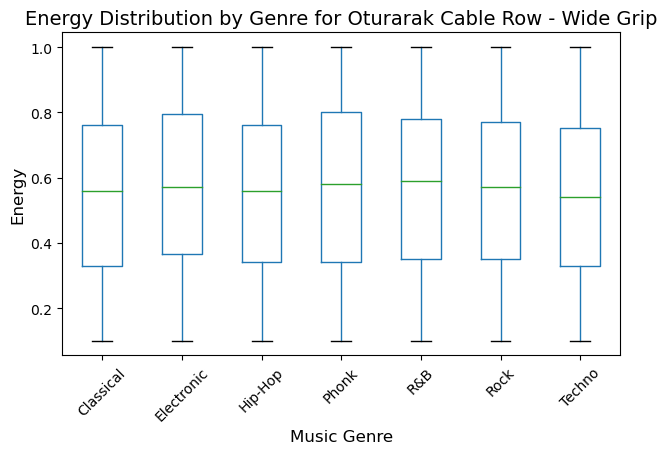

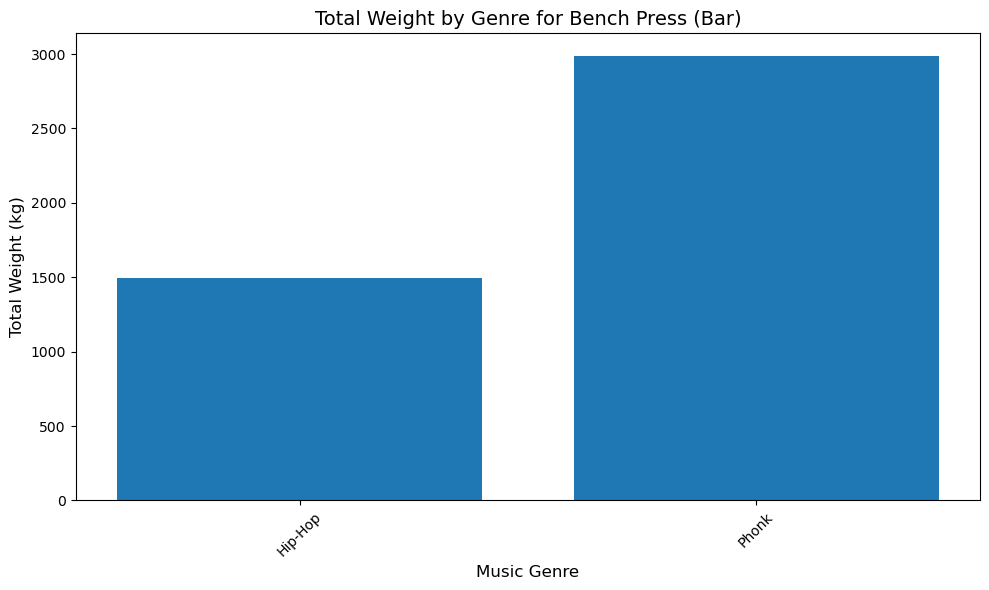

<Figure size 1000x600 with 0 Axes>

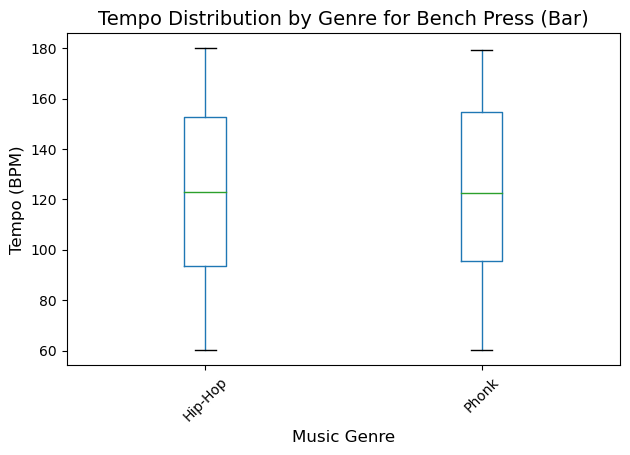

<Figure size 1000x600 with 0 Axes>

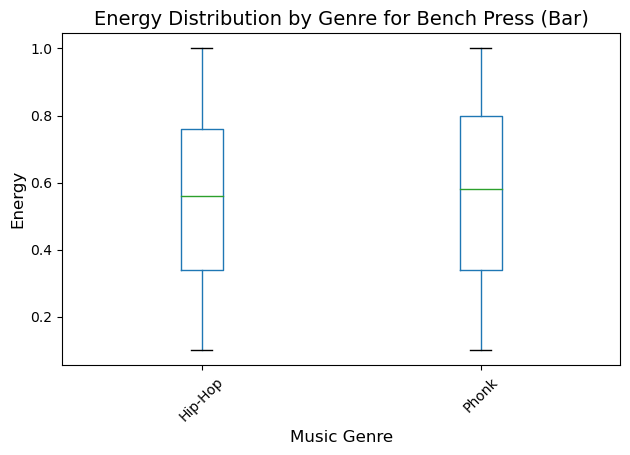

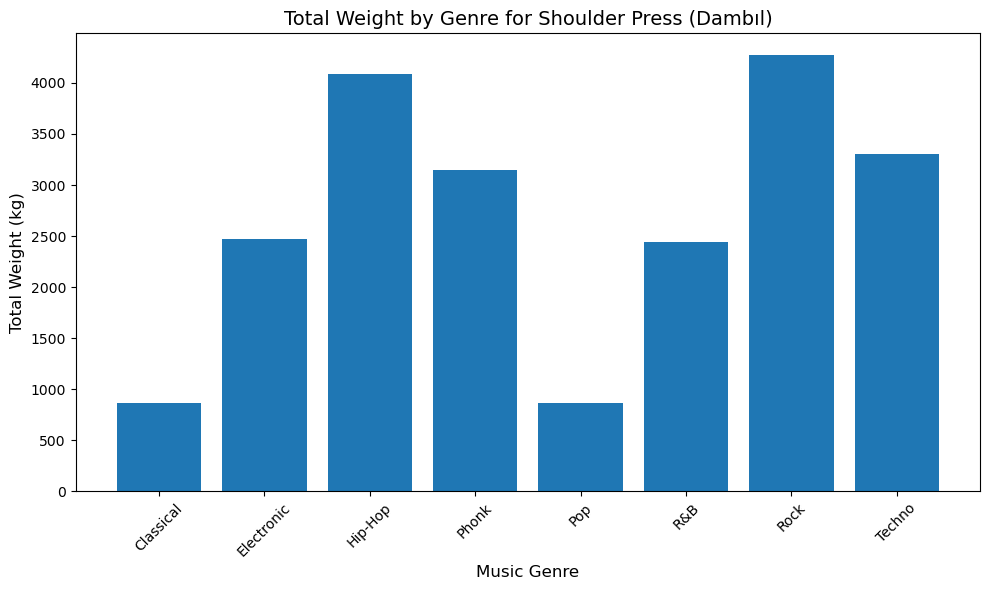

<Figure size 1000x600 with 0 Axes>

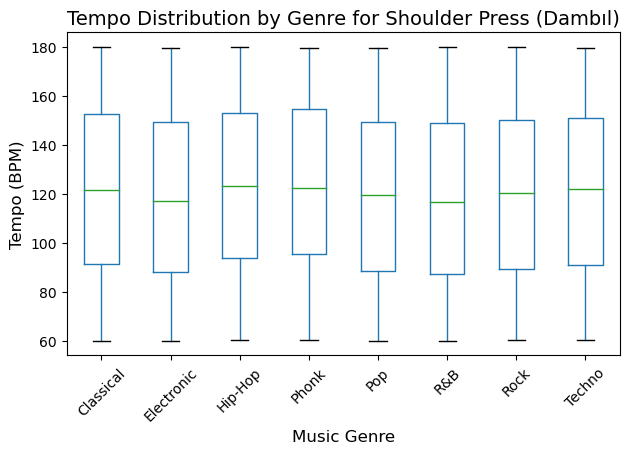

<Figure size 1000x600 with 0 Axes>

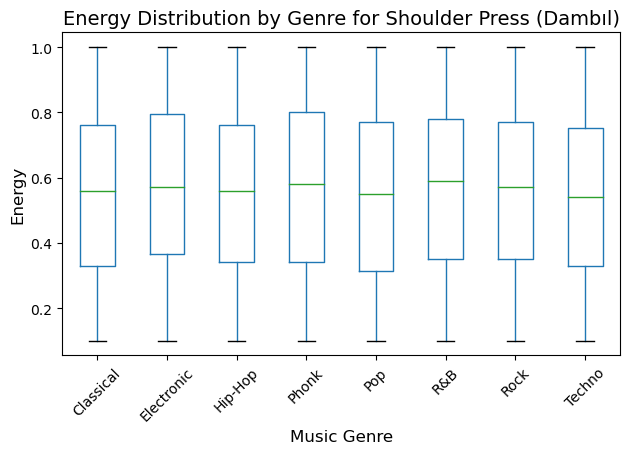

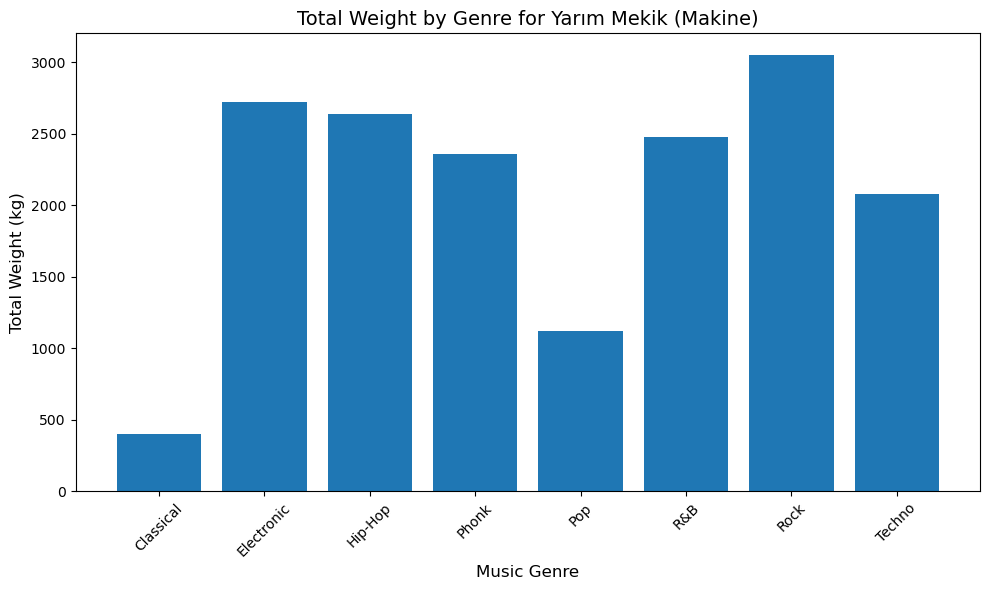

<Figure size 1000x600 with 0 Axes>

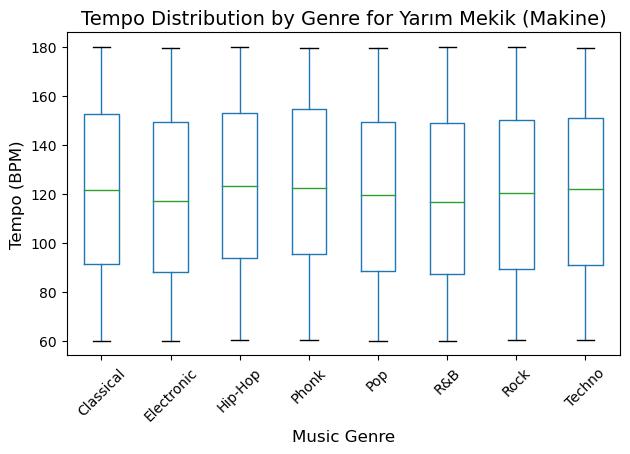

<Figure size 1000x600 with 0 Axes>

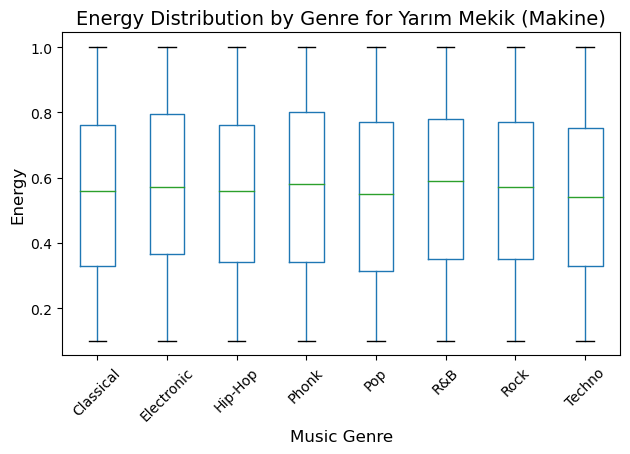

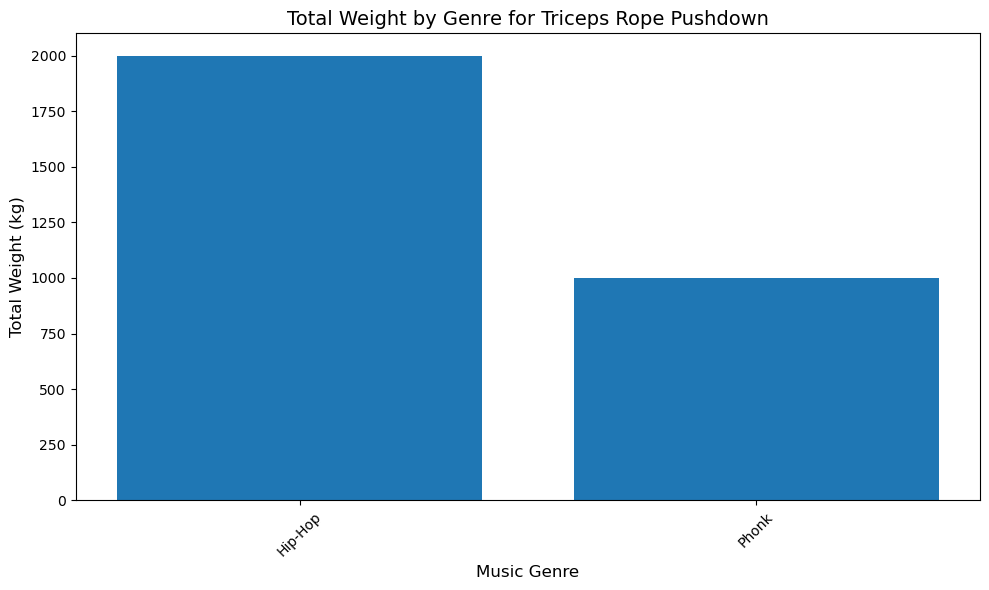

<Figure size 1000x600 with 0 Axes>

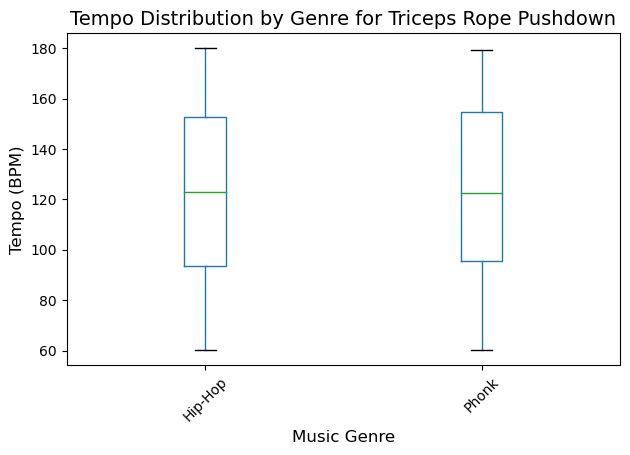

<Figure size 1000x600 with 0 Axes>

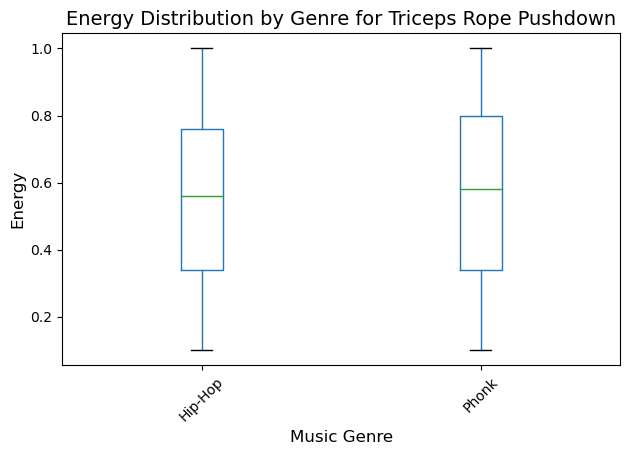

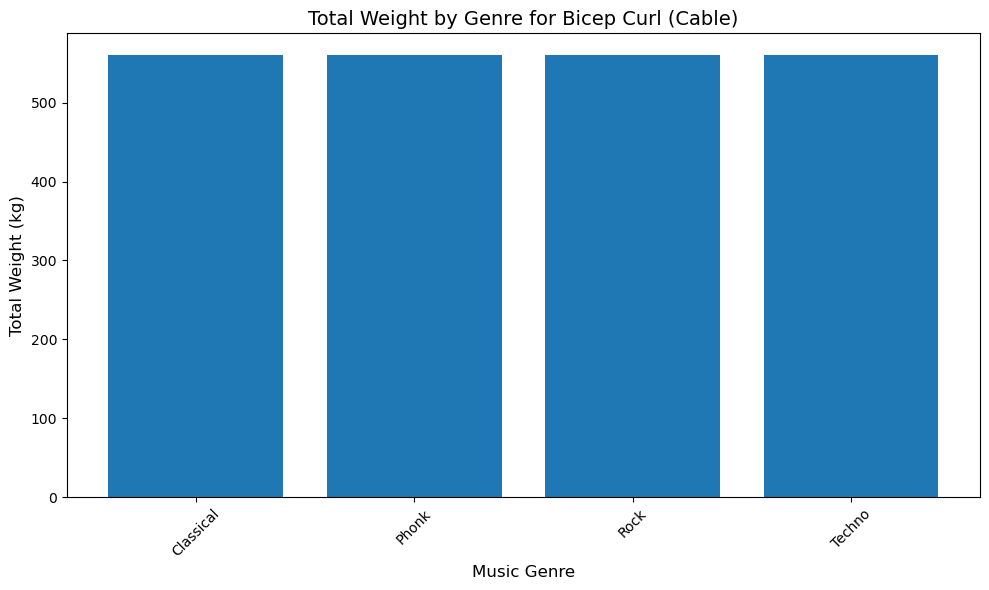

<Figure size 1000x600 with 0 Axes>

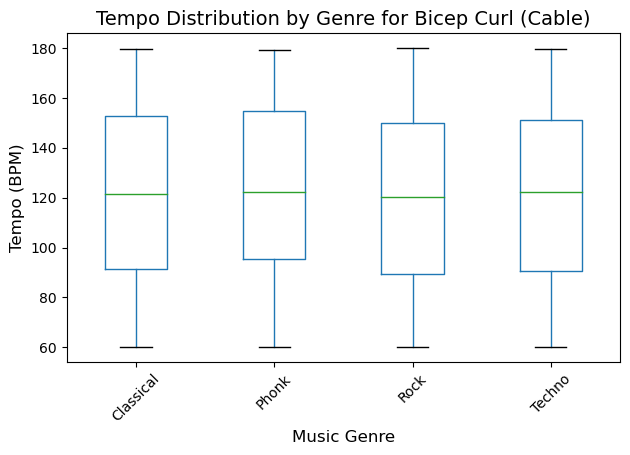

<Figure size 1000x600 with 0 Axes>

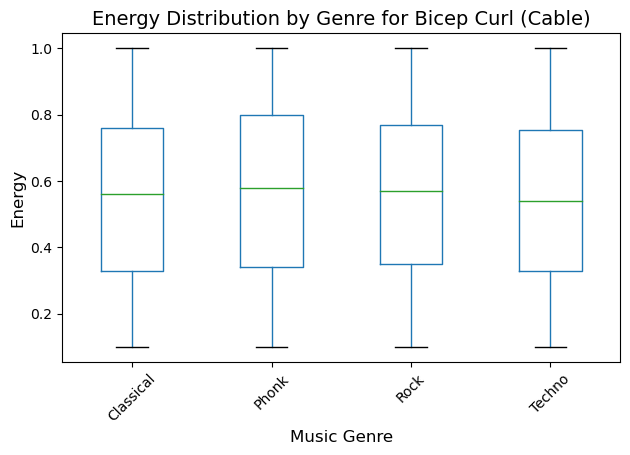

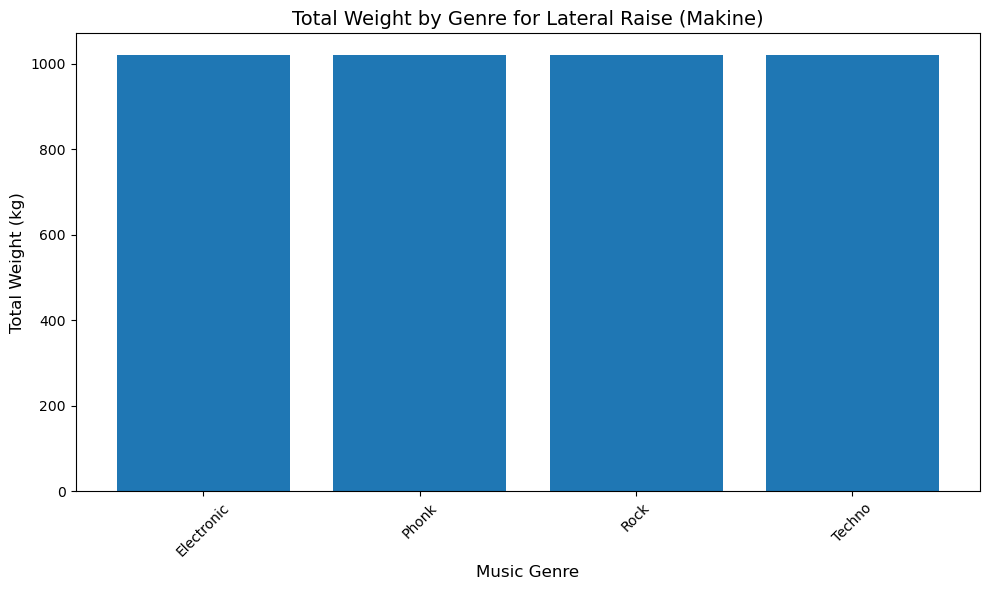

<Figure size 1000x600 with 0 Axes>

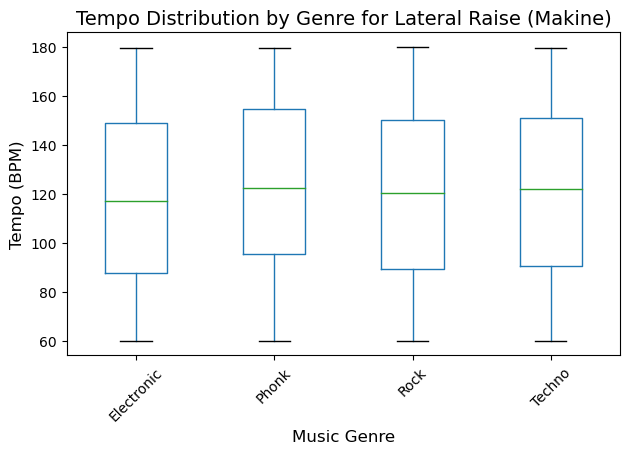

<Figure size 1000x600 with 0 Axes>

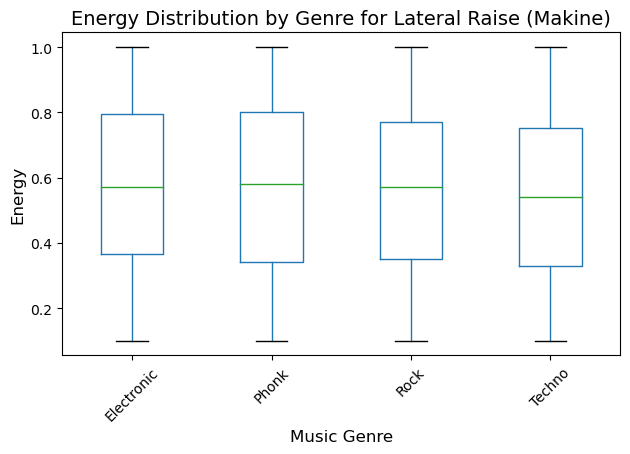

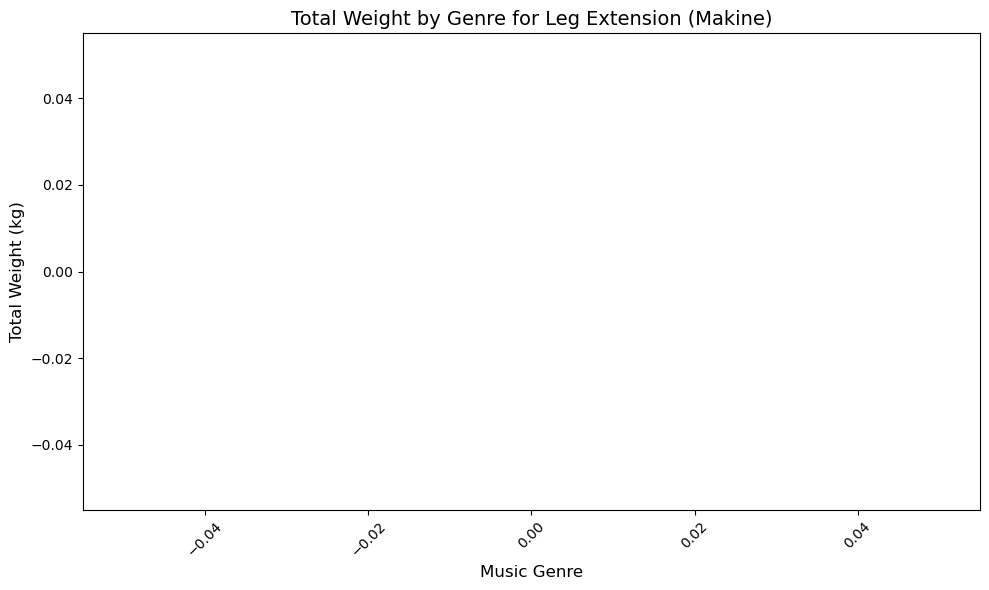

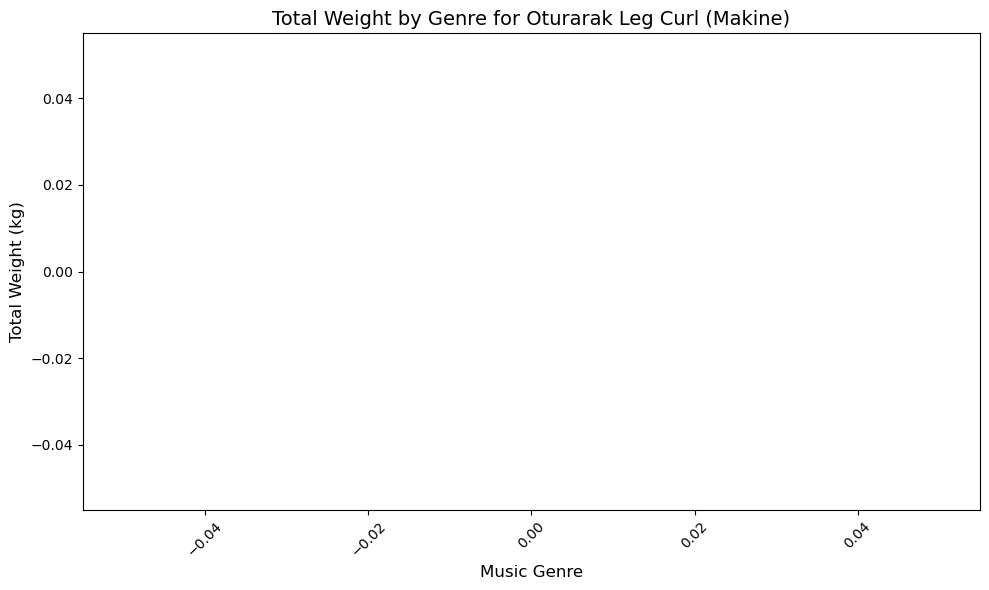

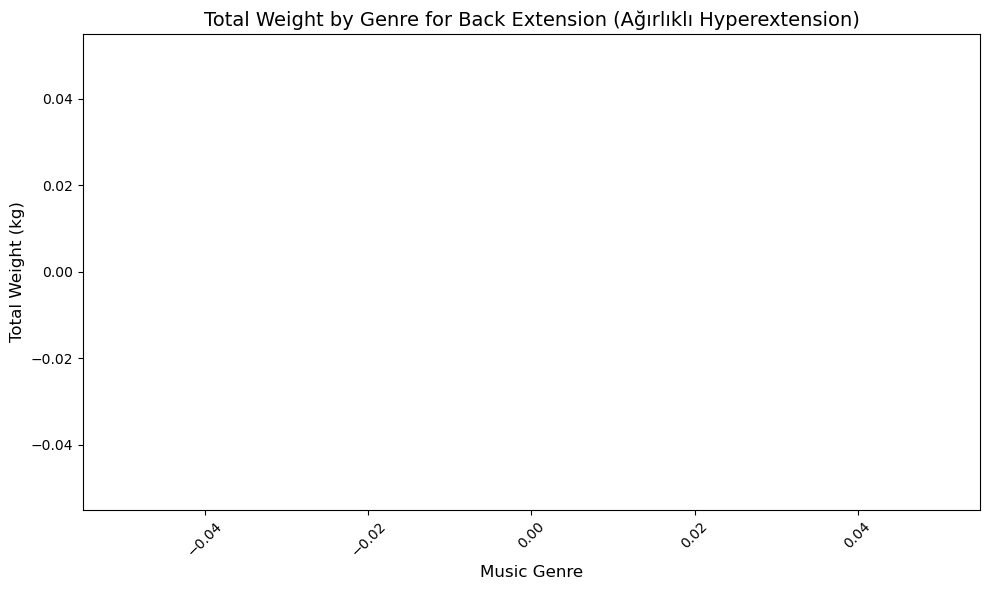

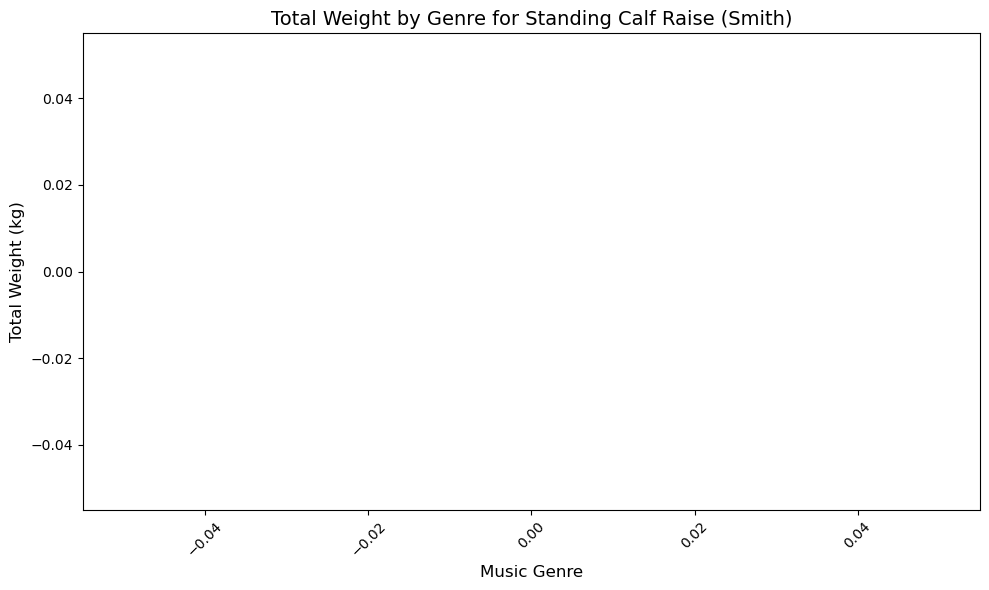

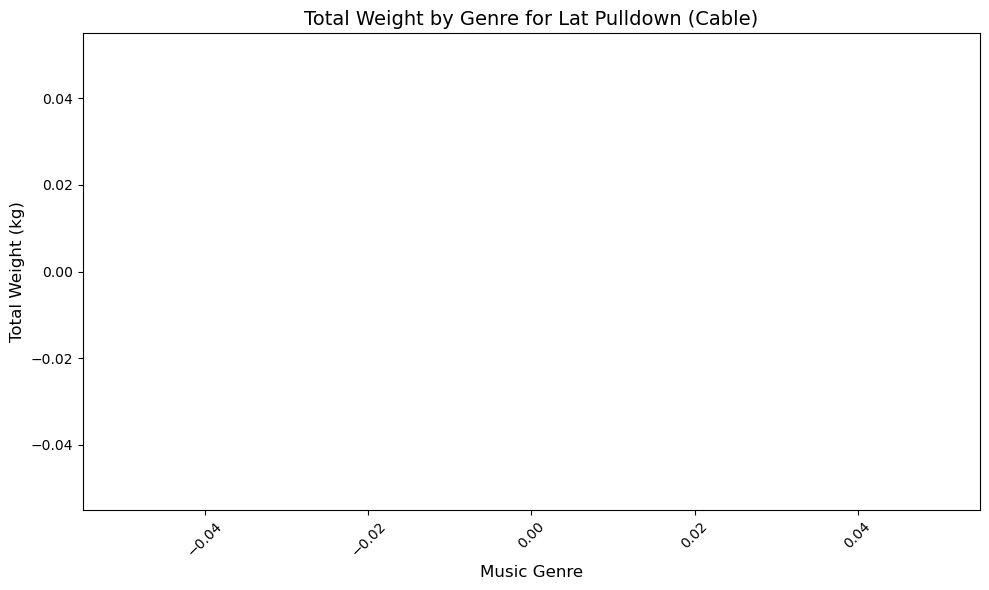

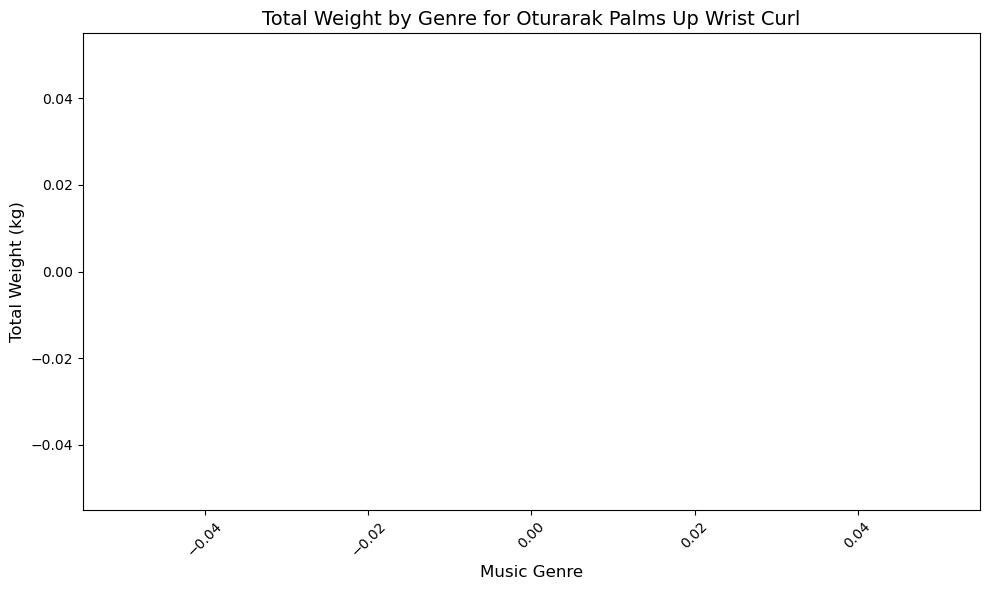

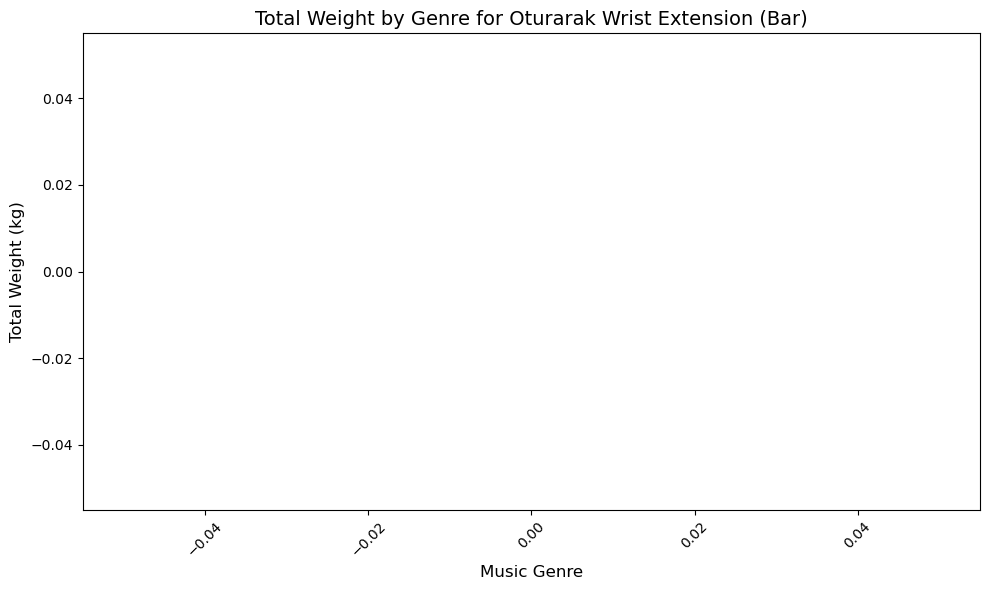

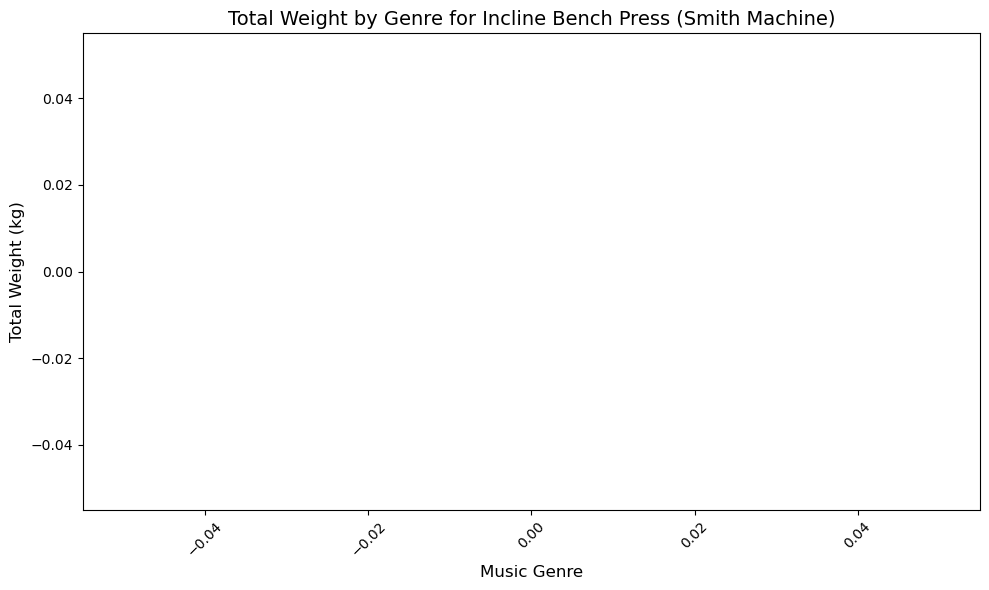

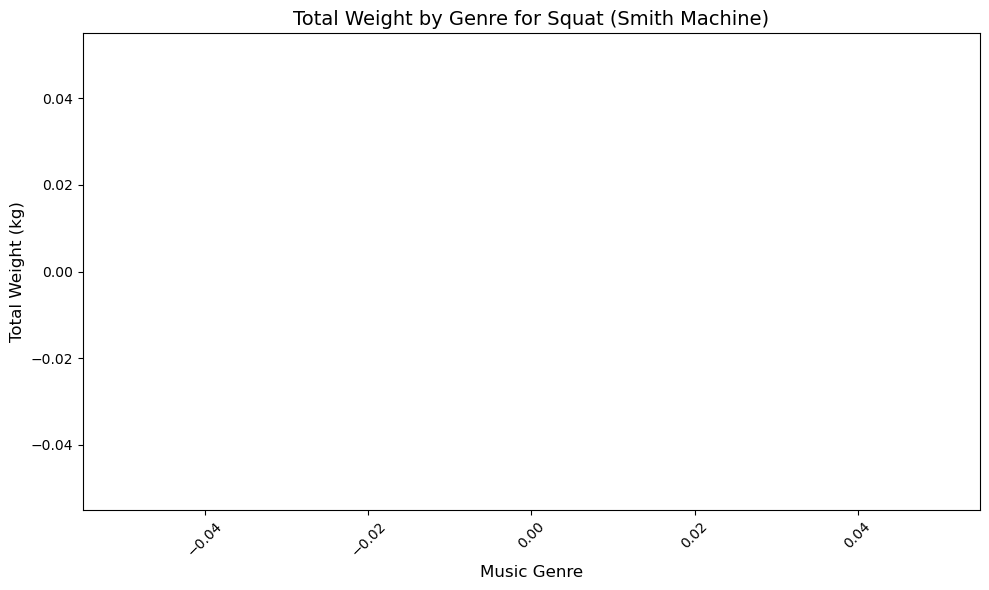

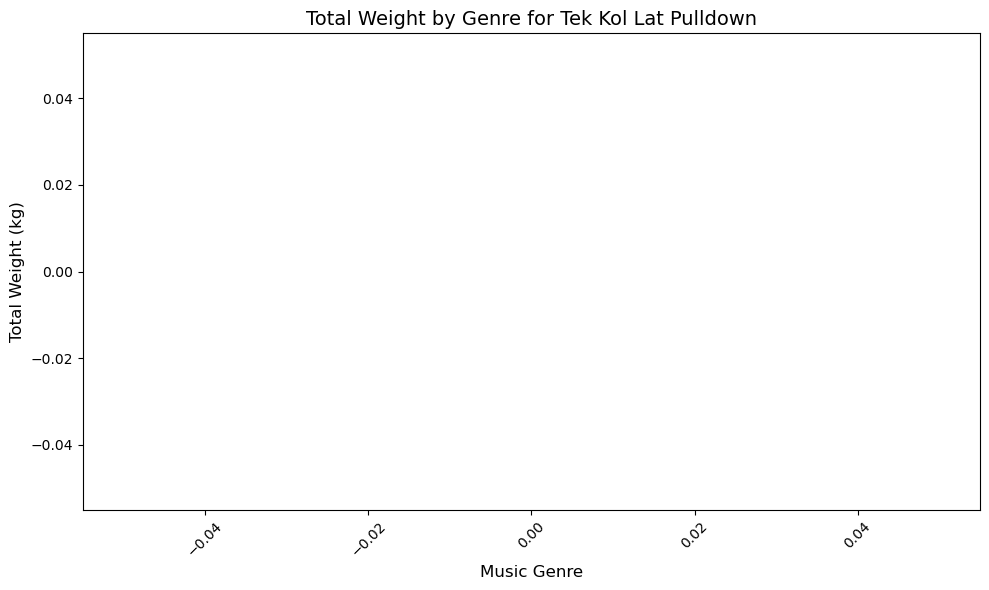

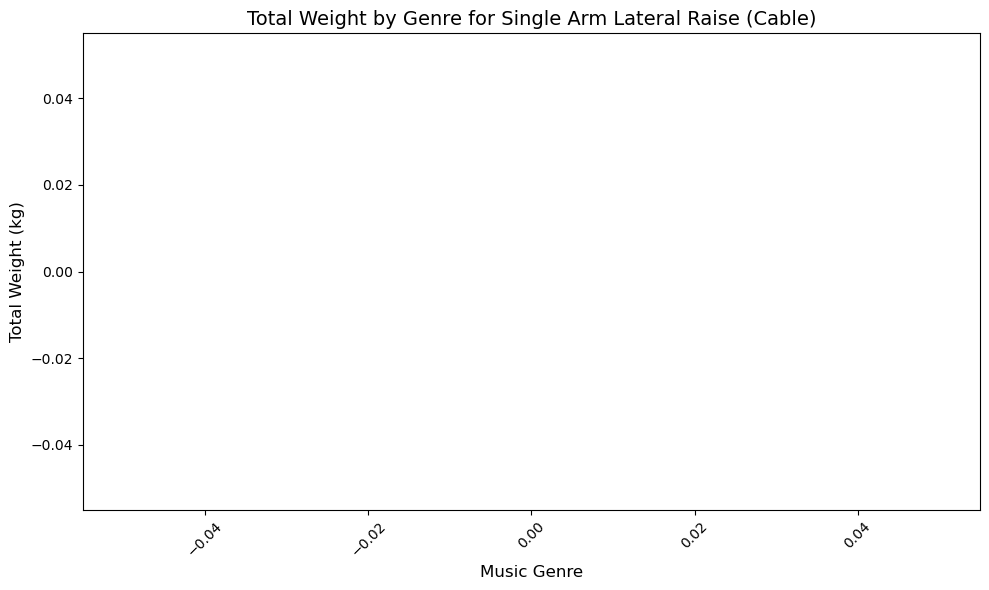

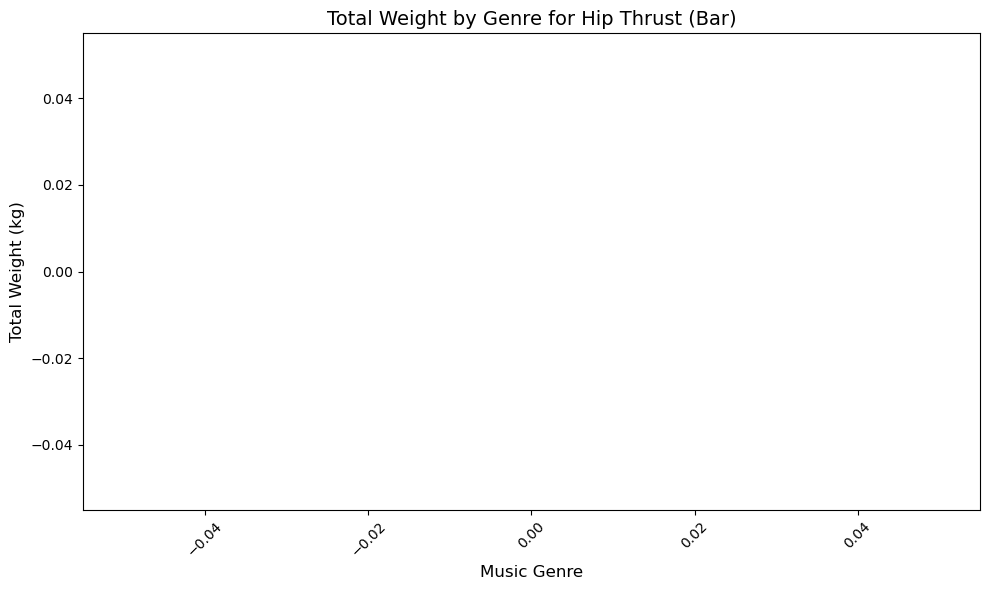

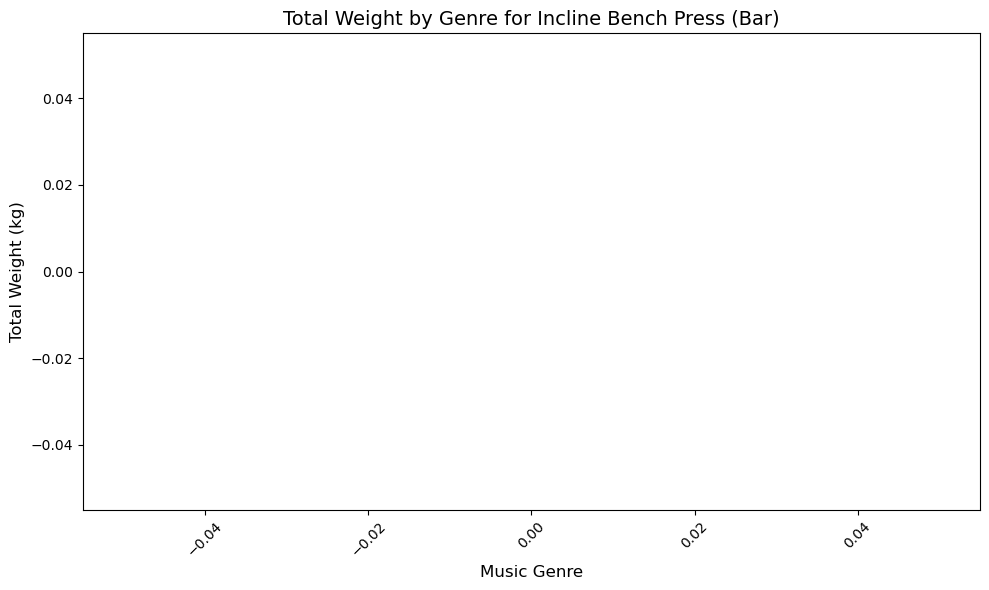

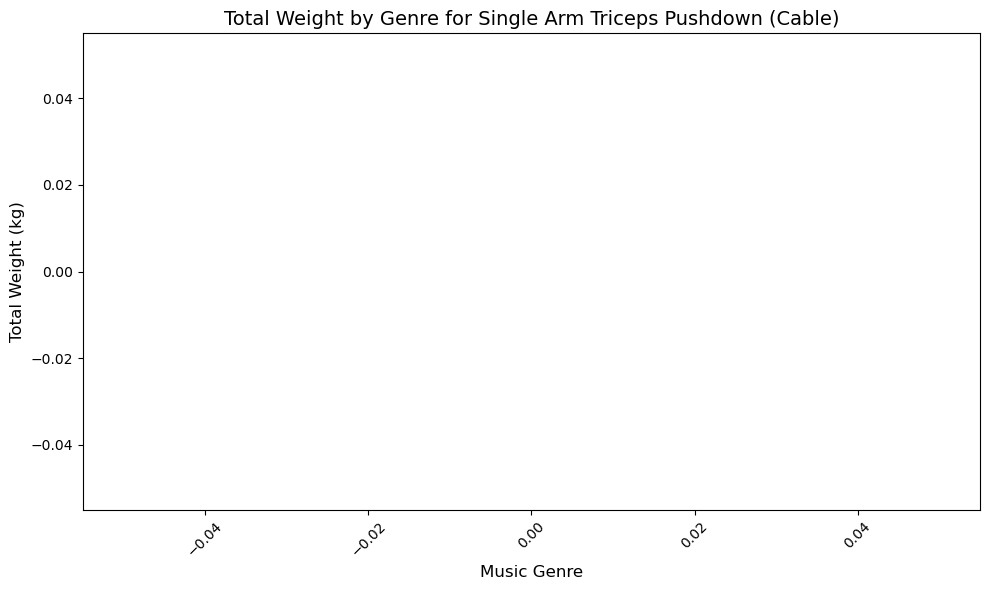

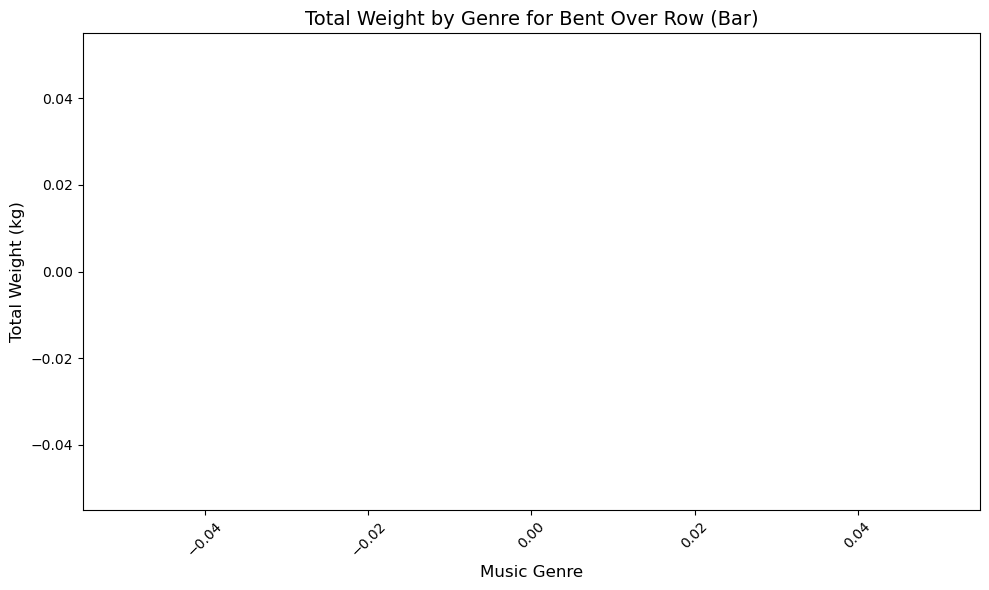

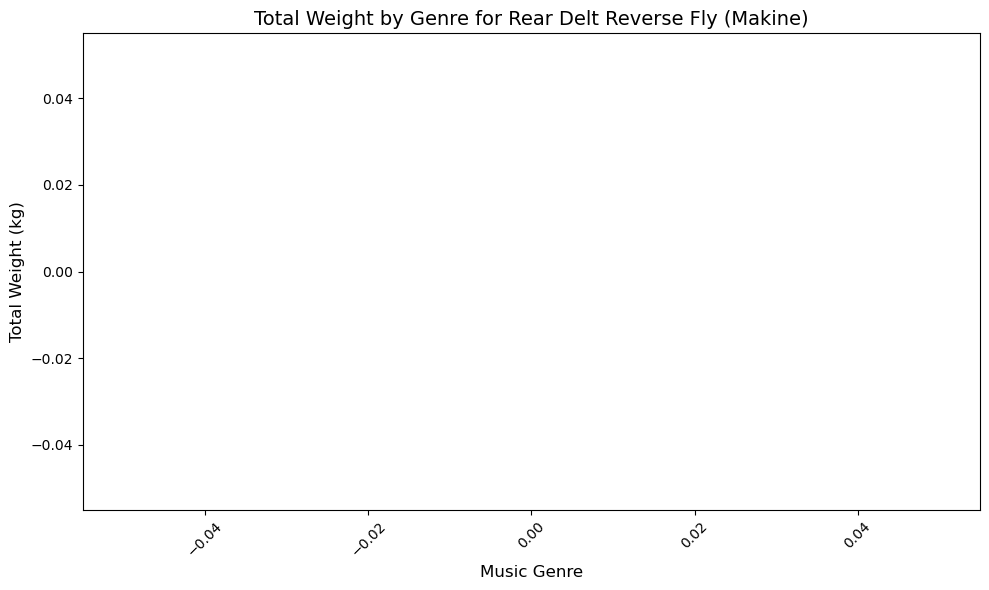

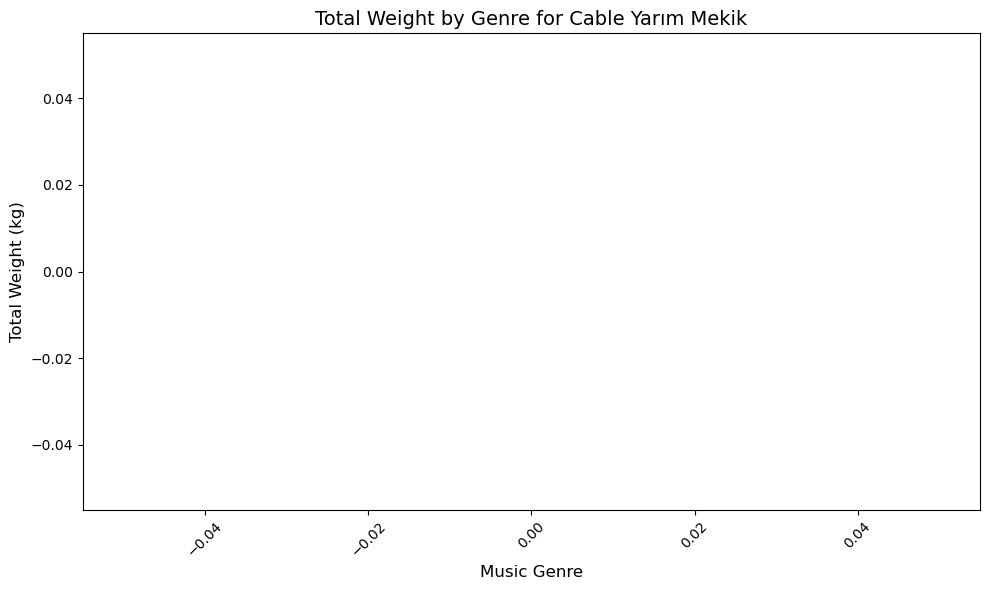

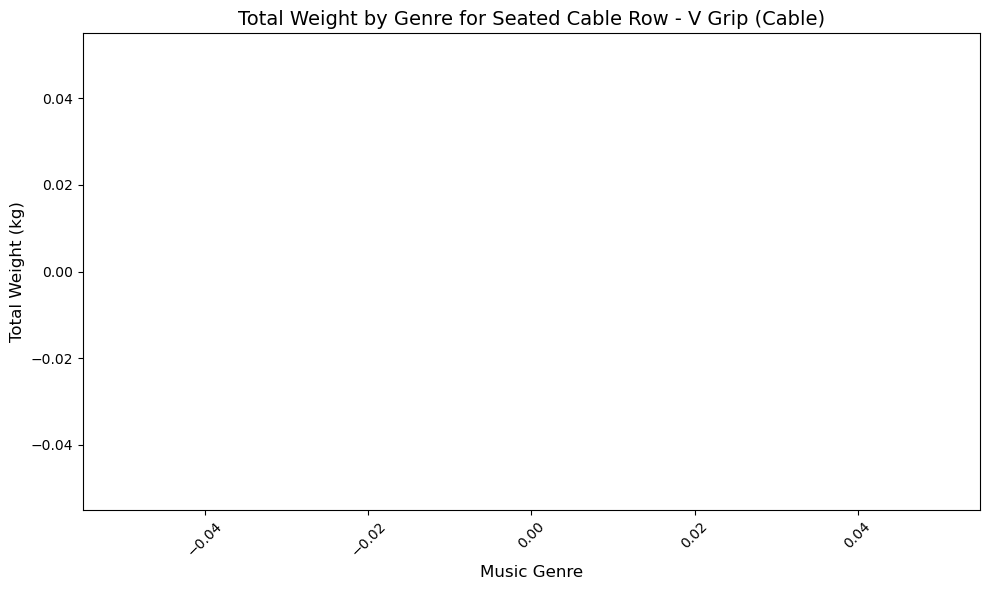

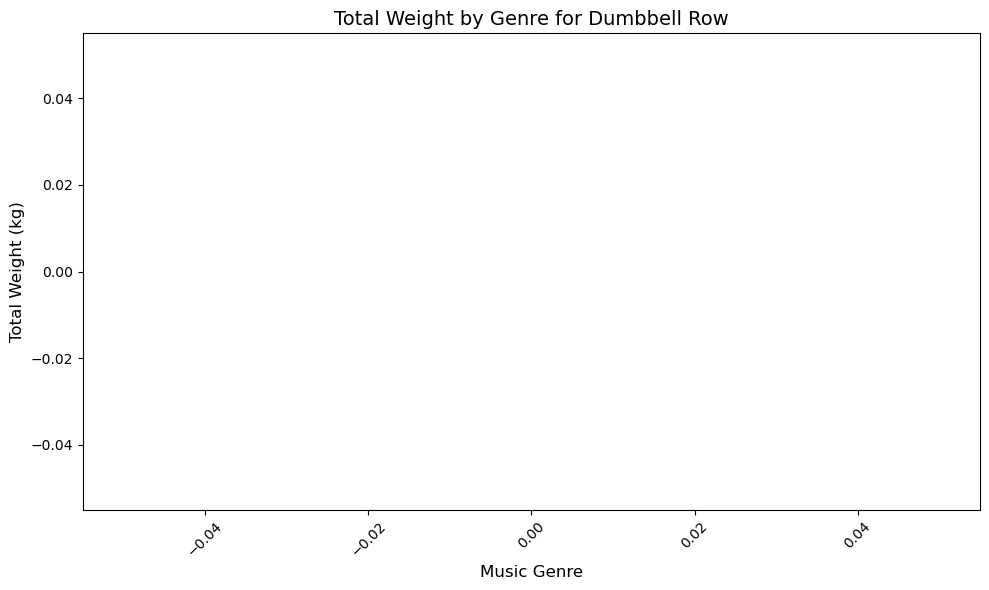

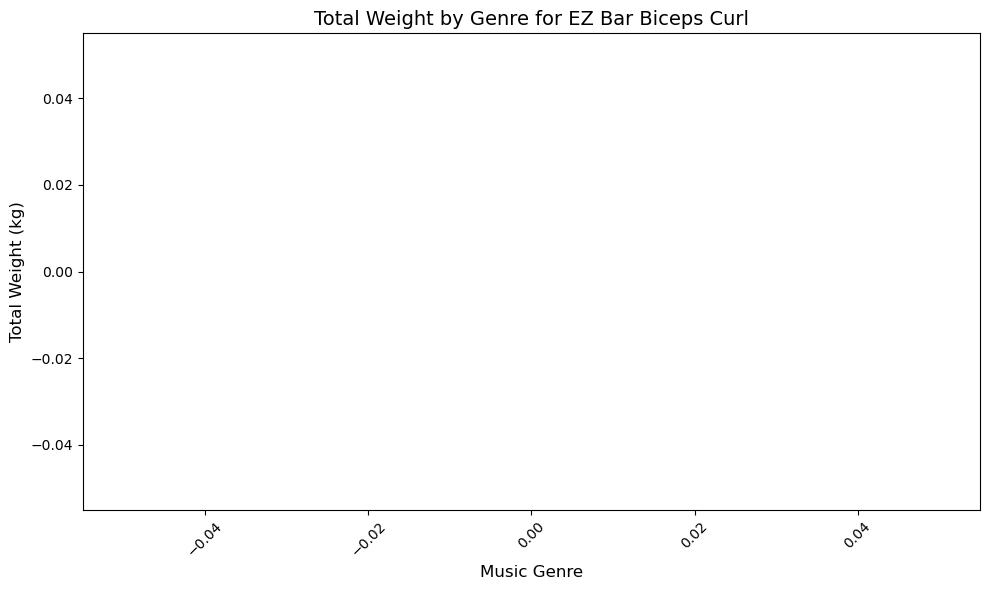

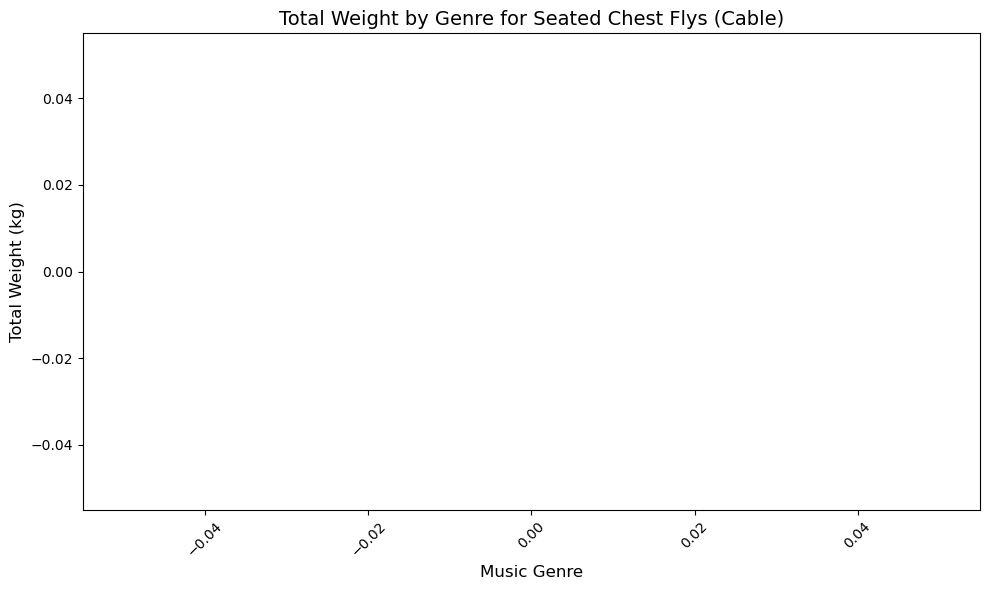

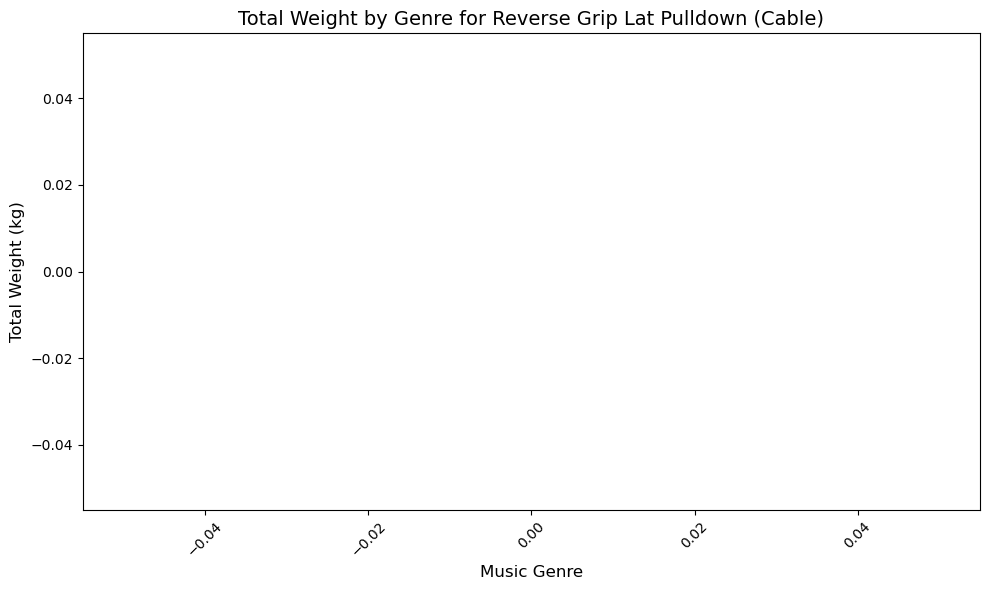

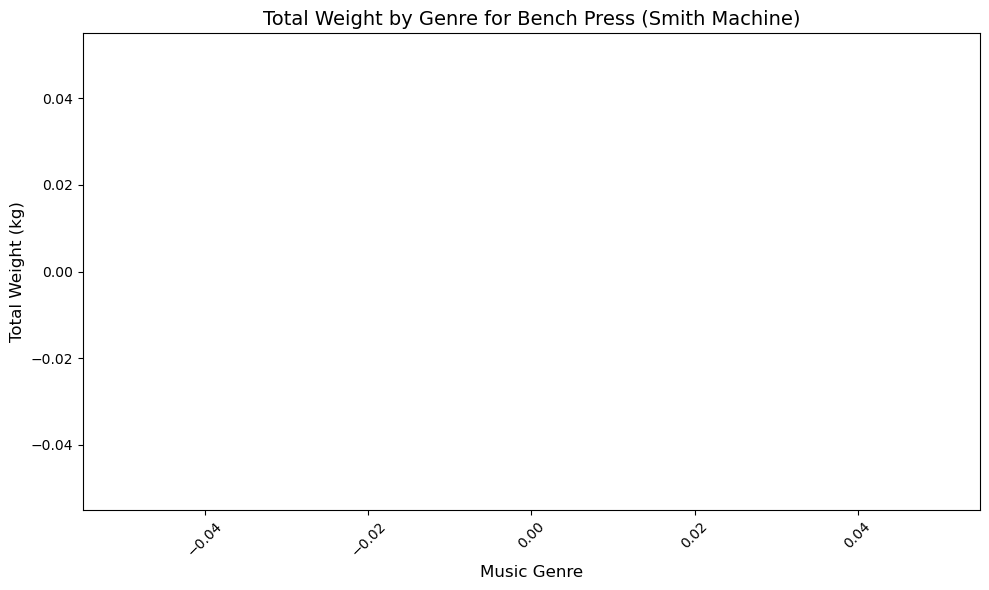

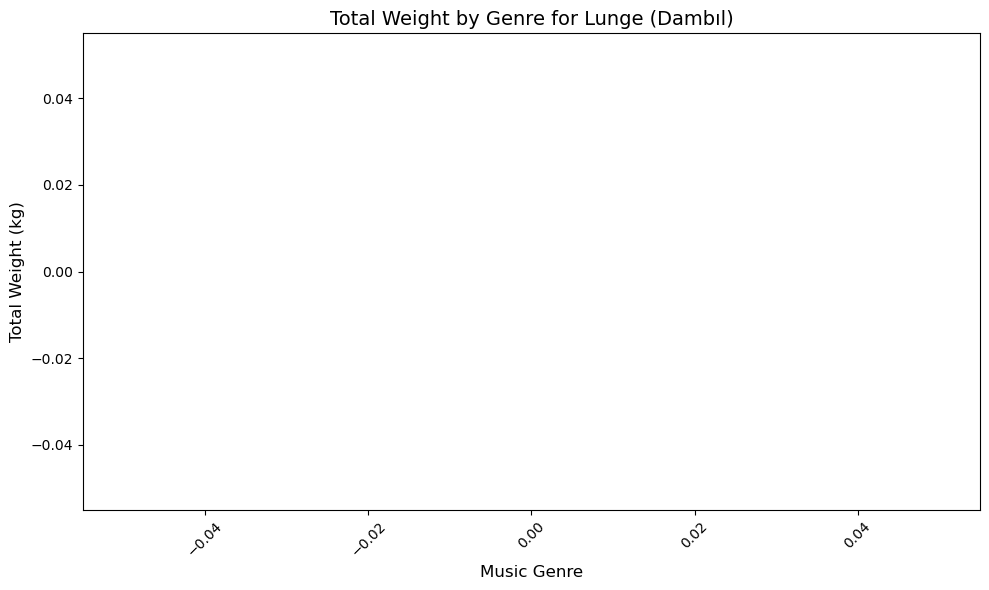

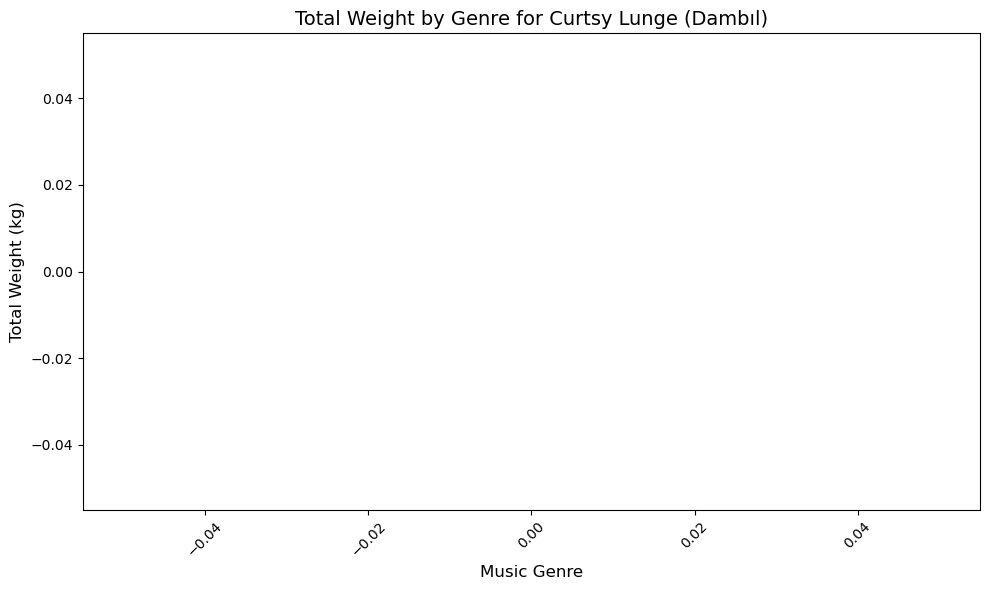

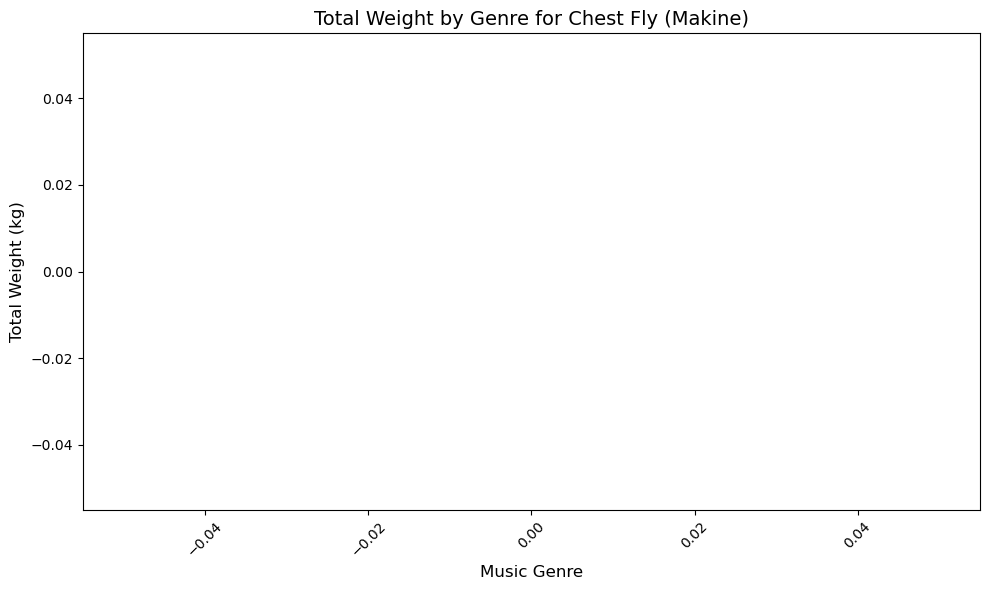

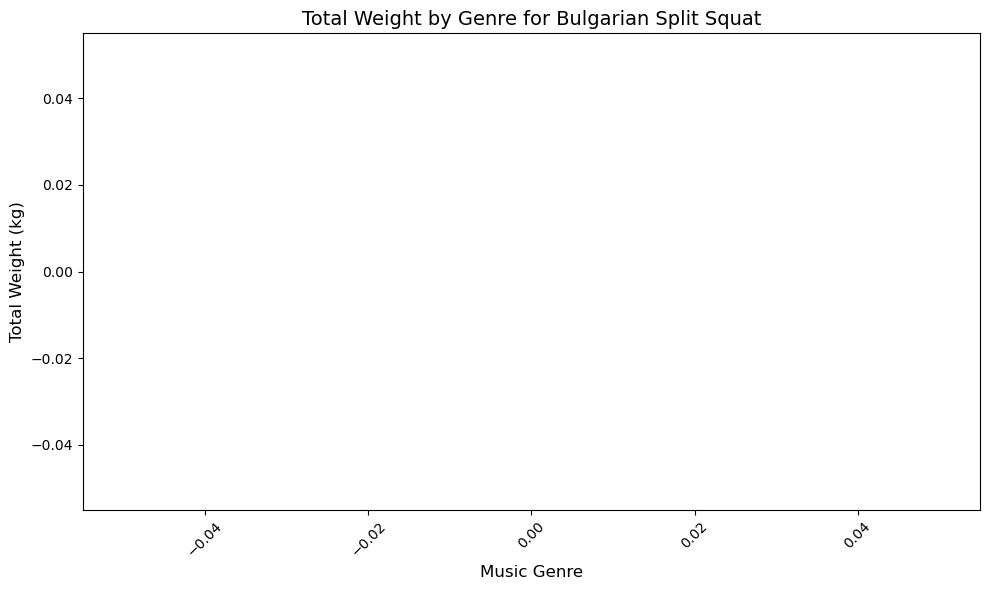

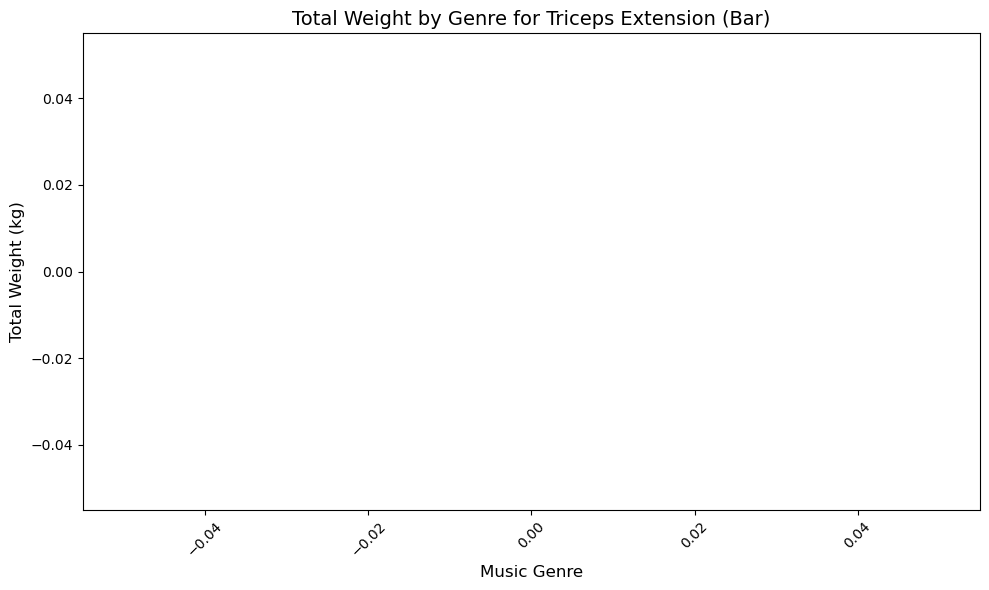

In [28]:
# Additional Visualizations for Each Exercise
# For each exercise, create 3 separate graphs for genre, tempo, and energy
unique_exercises = cleaned_workout_data['exercise_title'].unique()

for exercise in unique_exercises:
    subset = cleaned_workout_data[cleaned_workout_data['exercise_title'] == exercise]

    # Plot total weight by genre
    genre_effects = subset.explode('matched_genres').groupby('matched_genres')['total_weight'].sum().reset_index()
    plt.figure(figsize=(10, 6))
    plt.bar(genre_effects['matched_genres'], genre_effects['total_weight'])
    plt.title(f'Total Weight by Genre for {exercise}', fontsize=14)
    plt.xlabel('Music Genre', fontsize=12)
    plt.ylabel('Total Weight (kg)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot tempo distribution
    overlapping_music = music_data[music_data['Genre'].isin(subset.explode('matched_genres')['matched_genres'].unique())]
    if not overlapping_music.empty:
        plt.figure(figsize=(10, 6))
        overlapping_music.boxplot(column='Tempo', by='Genre', grid=False, rot=45)
        plt.title(f'Tempo Distribution by Genre for {exercise}', fontsize=14)
        plt.suptitle('')
        plt.xlabel('Music Genre', fontsize=12)
        plt.ylabel('Tempo (BPM)', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Plot energy distribution
        plt.figure(figsize=(10, 6))
        overlapping_music.boxplot(column='Energy', by='Genre', grid=False, rot=45)
        plt.title(f'Energy Distribution by Genre for {exercise}', fontsize=14)
        plt.suptitle('')
        plt.xlabel('Music Genre', fontsize=12)
        plt.ylabel('Energy', fontsize=12)
        plt.tight_layout()
        plt.show()


In [25]:
# Step 6: Analyze Effects of Genres
# Ensure 'average_weight_per_set' is calculated before grouping
cleaned_workout_data['average_weight_per_set'] = cleaned_workout_data['total_weight'] / cleaned_workout_data['reps']

# Group data by music genres and calculate average weight lifted per set
exercise_genre_effects = cleaned_workout_data.explode('matched_genres').groupby(
    ['exercise_title', 'matched_genres']
).agg({
    'average_weight_per_set': 'mean'
}).reset_index()

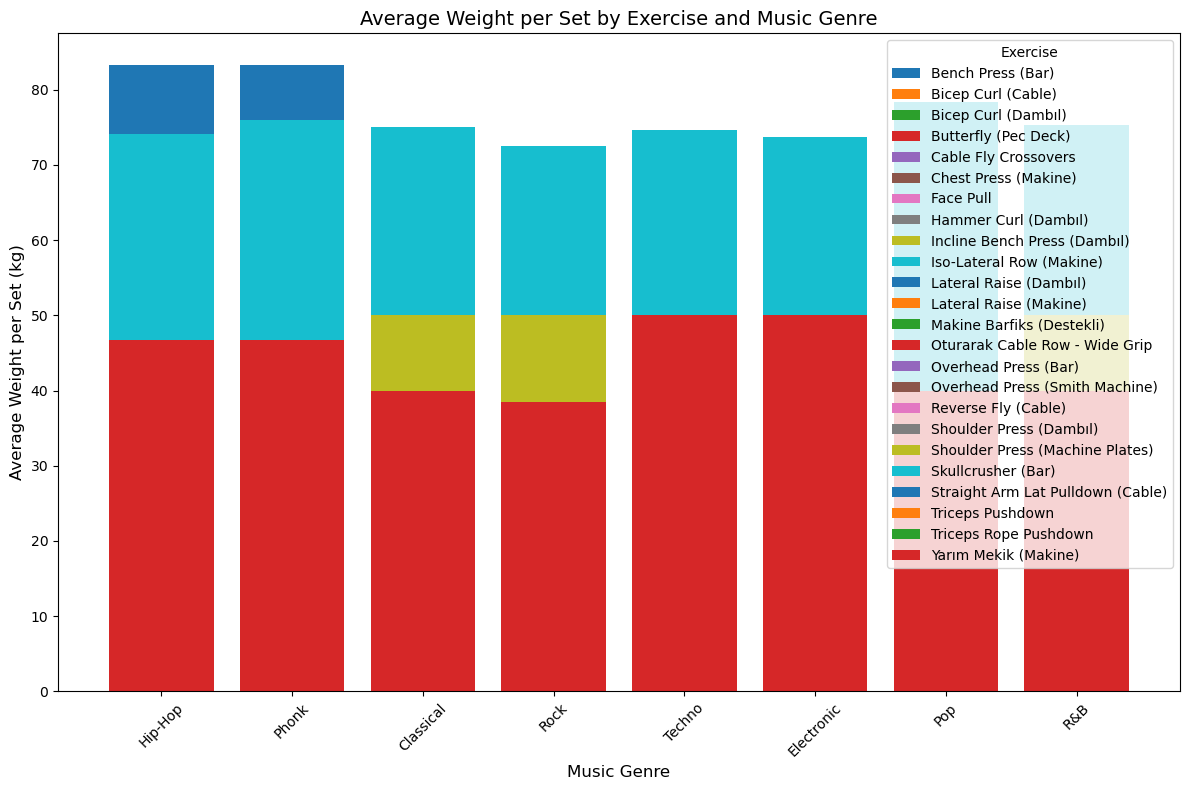

In [26]:
# Step 7: Visualize Results
# Create a bar plot for average weight lifted per set by exercise and music genre
plt.figure(figsize=(12, 8))
for exercise in exercise_genre_effects['exercise_title'].unique():
    subset = exercise_genre_effects[exercise_genre_effects['exercise_title'] == exercise]
    plt.bar(subset['matched_genres'], subset['average_weight_per_set'], label=exercise)
plt.title('Average Weight per Set by Exercise and Music Genre', fontsize=14)
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Average Weight per Set (kg)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Exercise', fontsize=10)
plt.tight_layout()
plt.show()

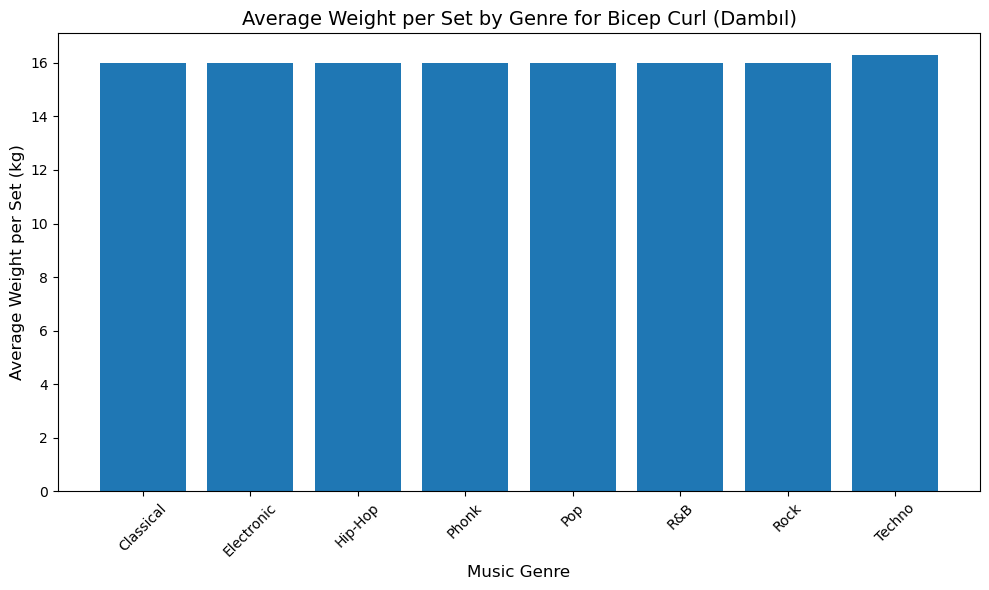

<Figure size 1000x600 with 0 Axes>

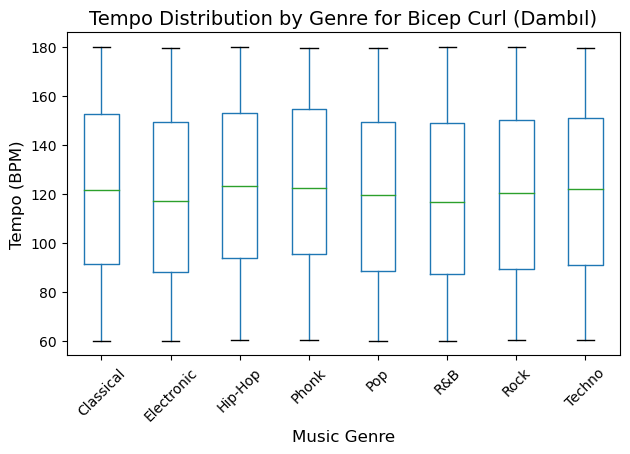

<Figure size 1000x600 with 0 Axes>

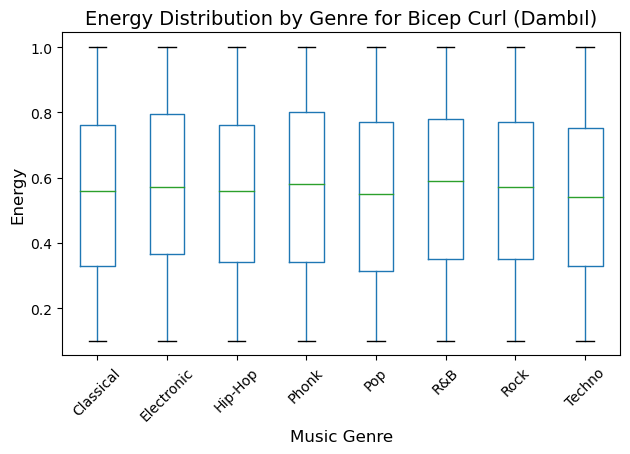

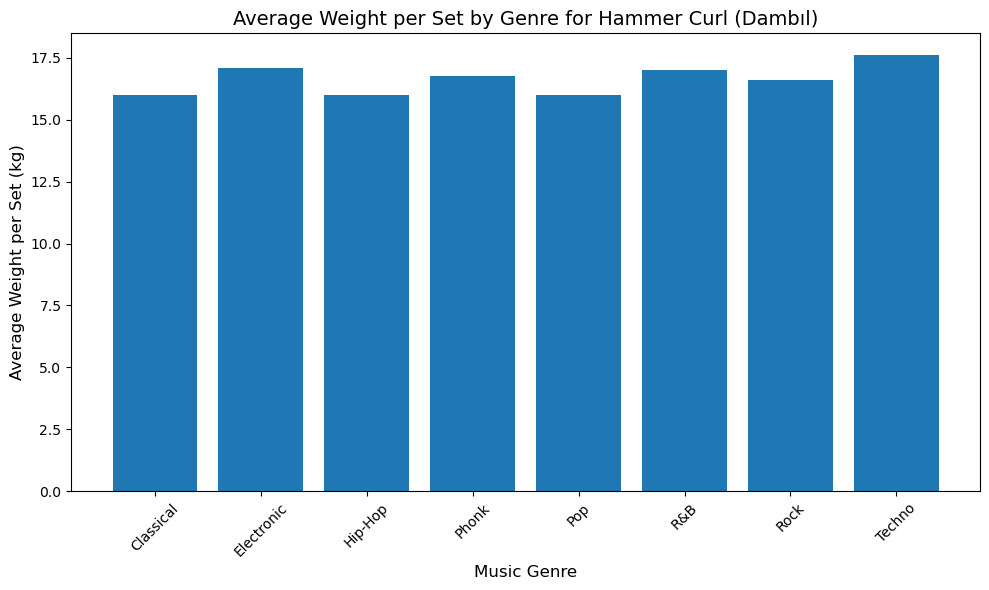

<Figure size 1000x600 with 0 Axes>

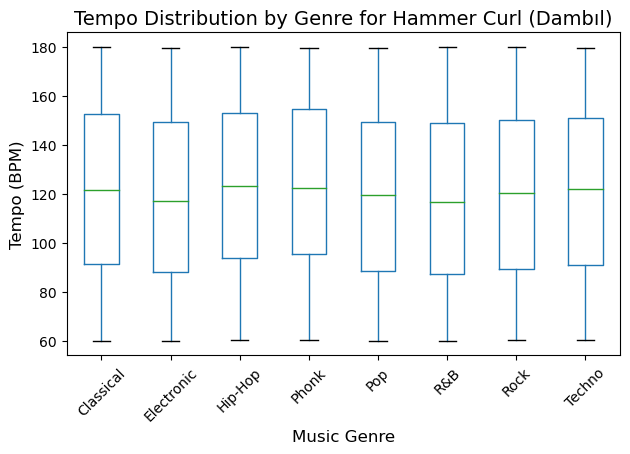

<Figure size 1000x600 with 0 Axes>

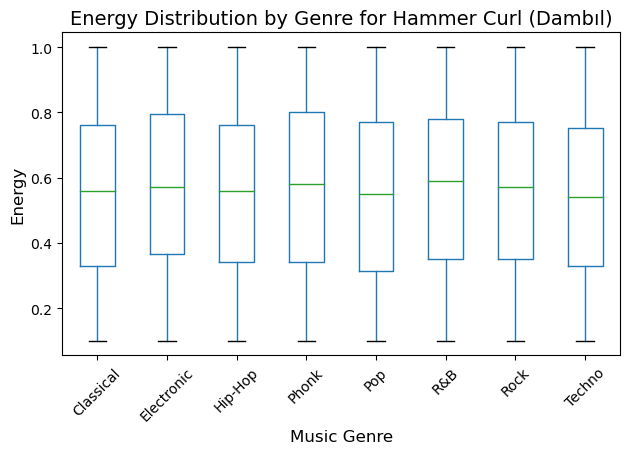

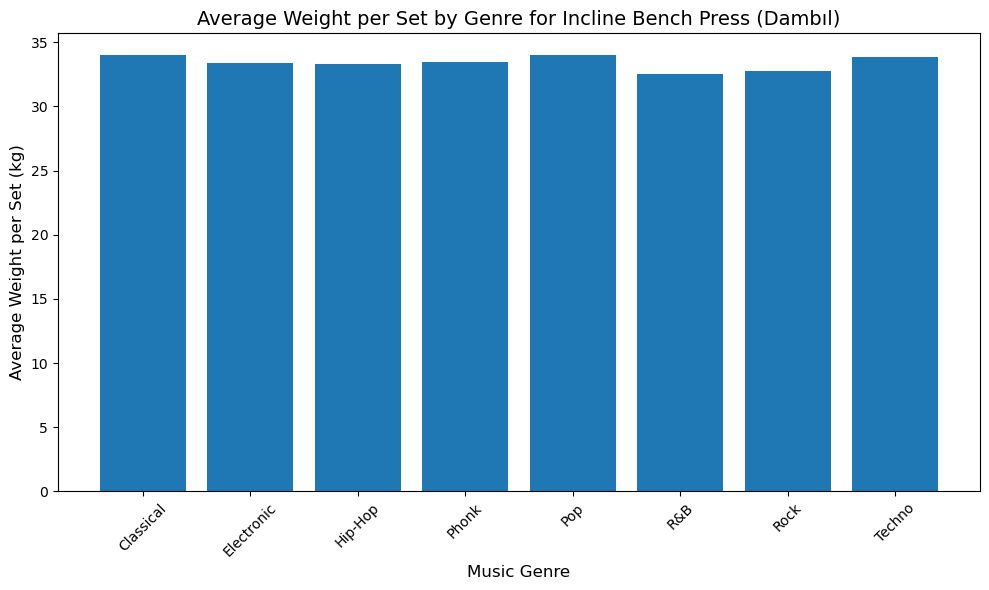

<Figure size 1000x600 with 0 Axes>

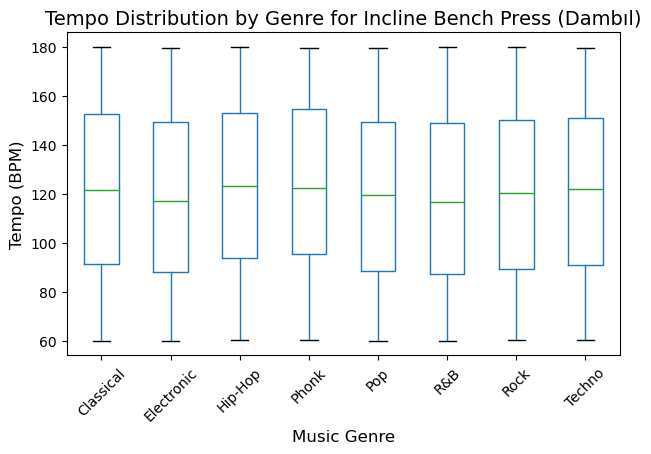

<Figure size 1000x600 with 0 Axes>

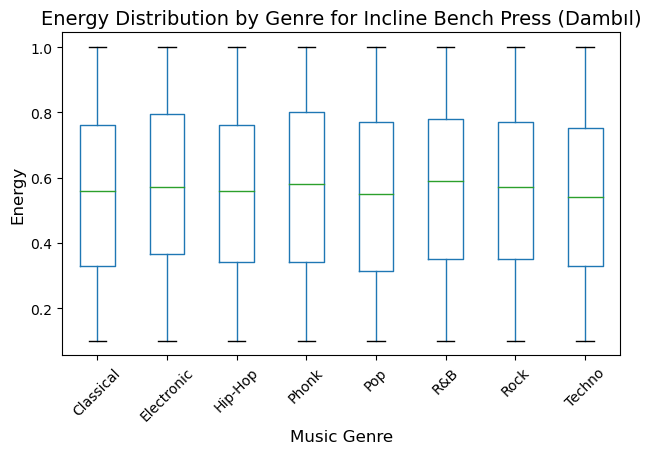

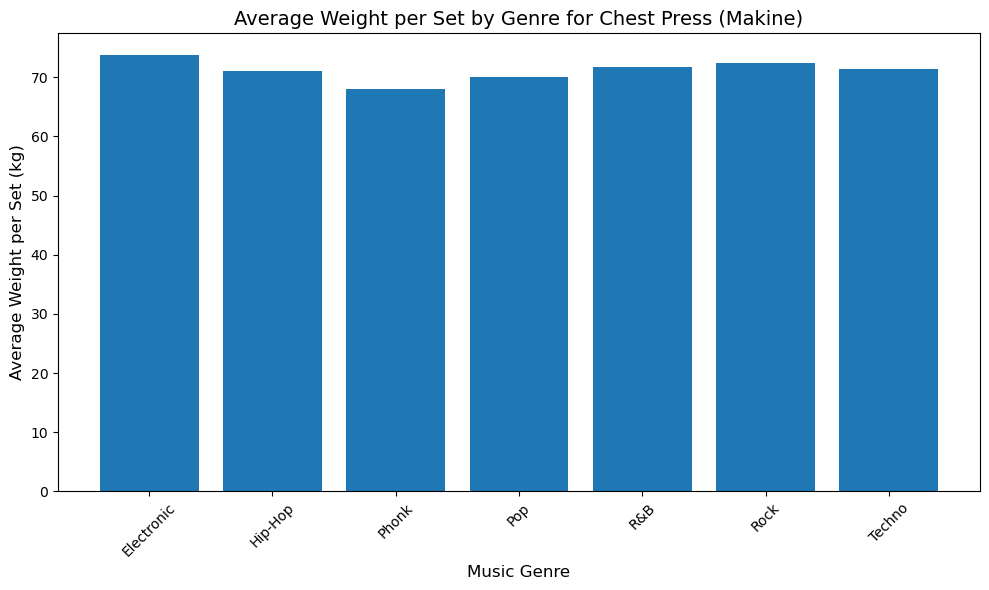

<Figure size 1000x600 with 0 Axes>

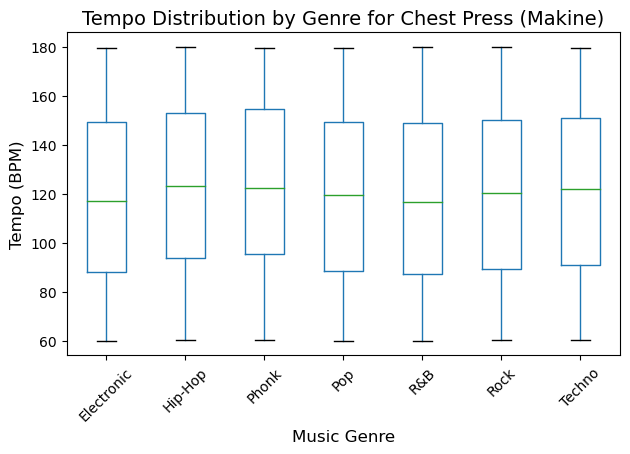

<Figure size 1000x600 with 0 Axes>

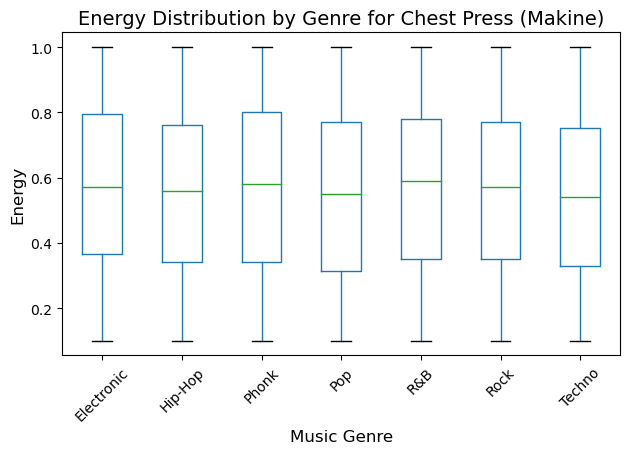

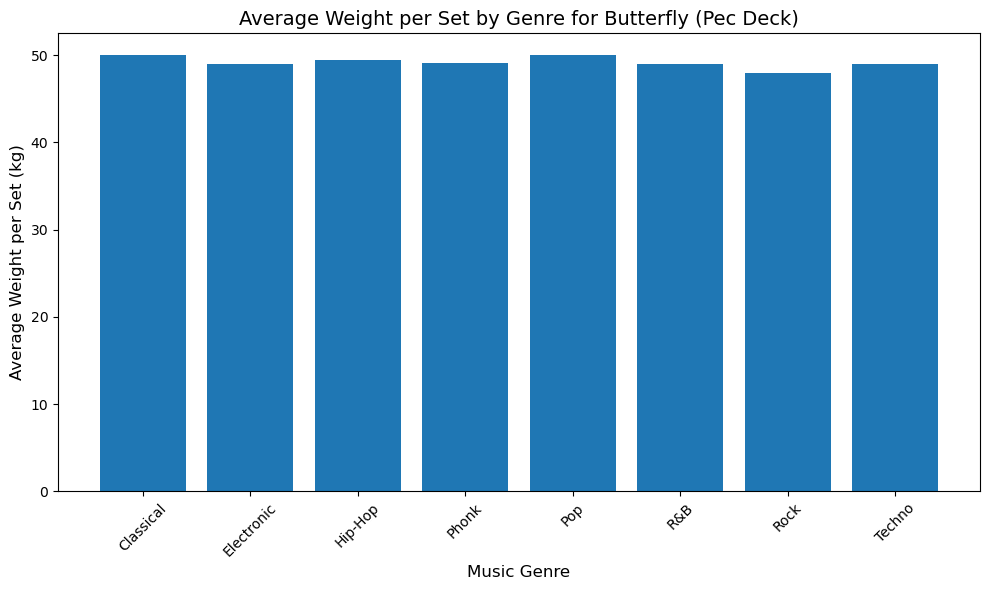

<Figure size 1000x600 with 0 Axes>

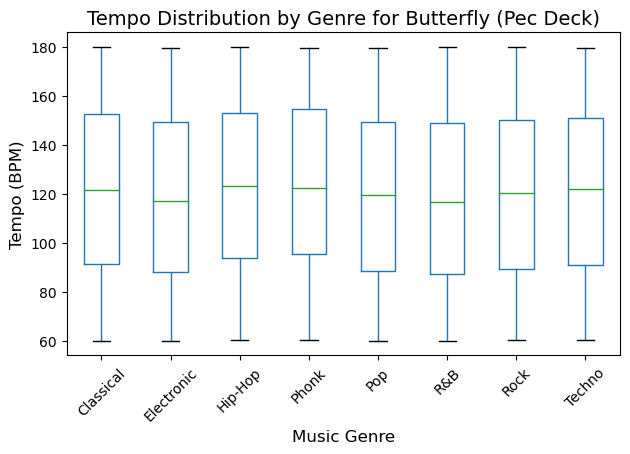

<Figure size 1000x600 with 0 Axes>

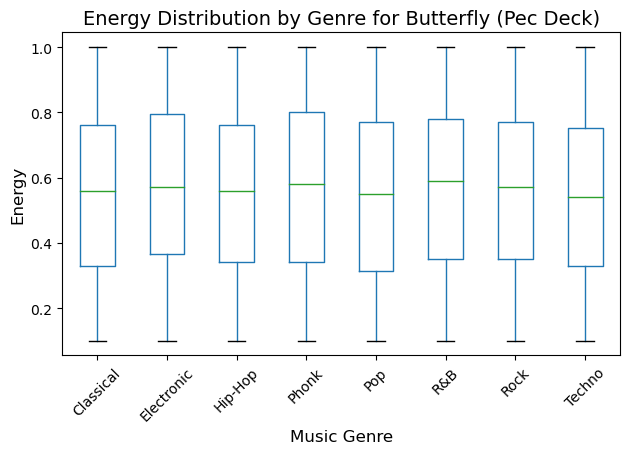

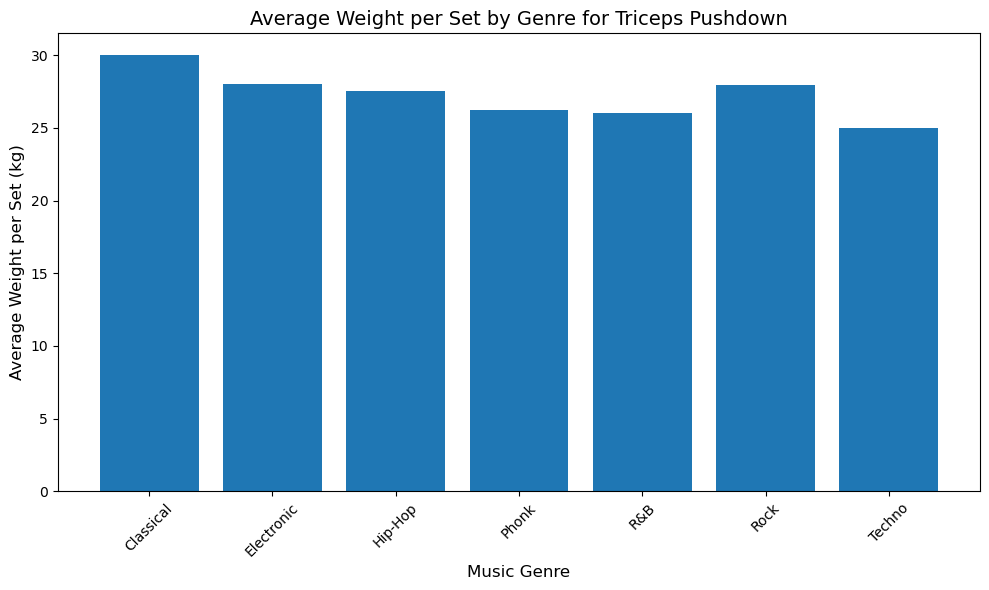

<Figure size 1000x600 with 0 Axes>

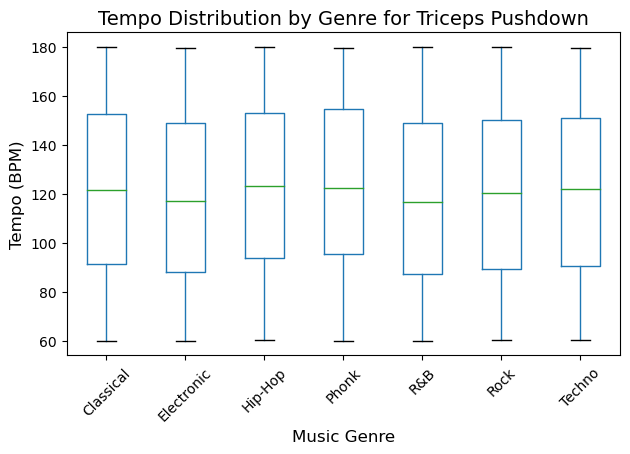

<Figure size 1000x600 with 0 Axes>

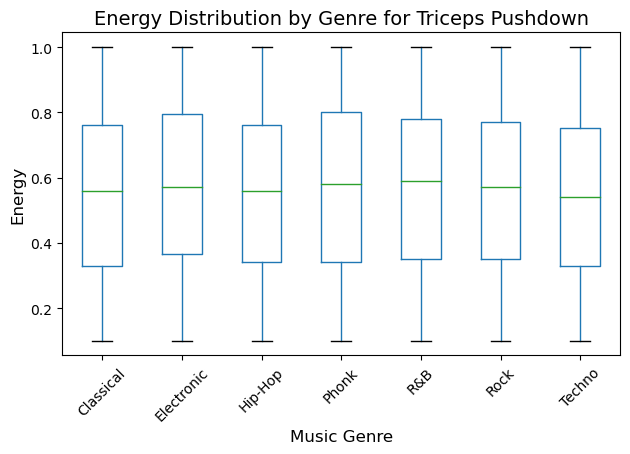

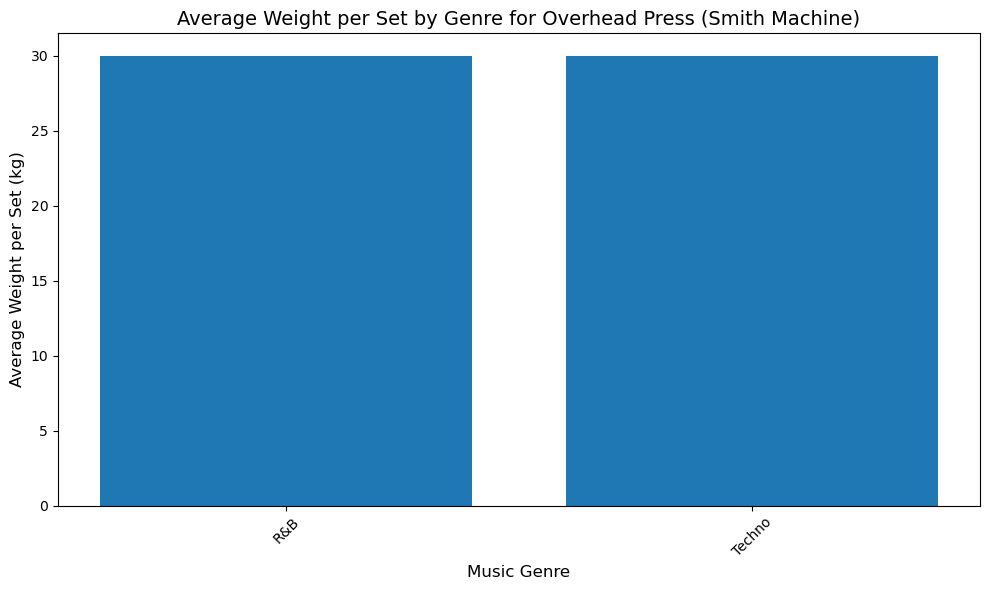

<Figure size 1000x600 with 0 Axes>

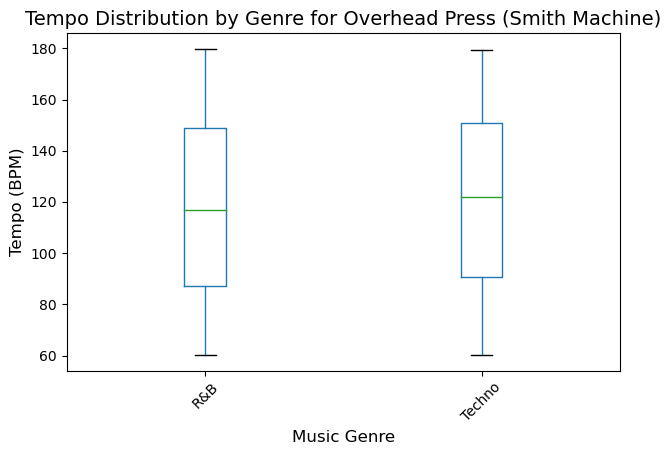

<Figure size 1000x600 with 0 Axes>

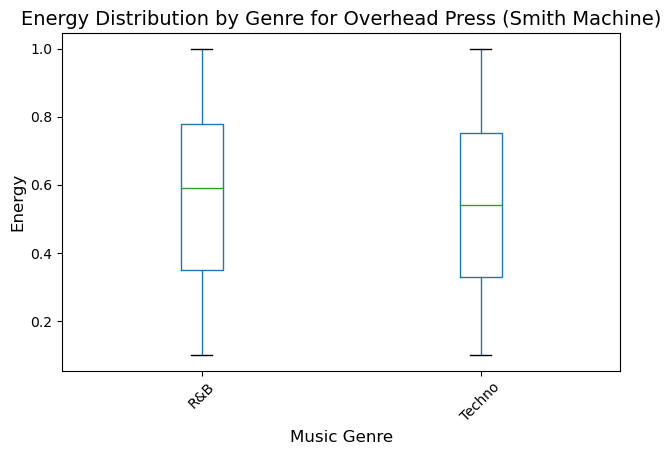

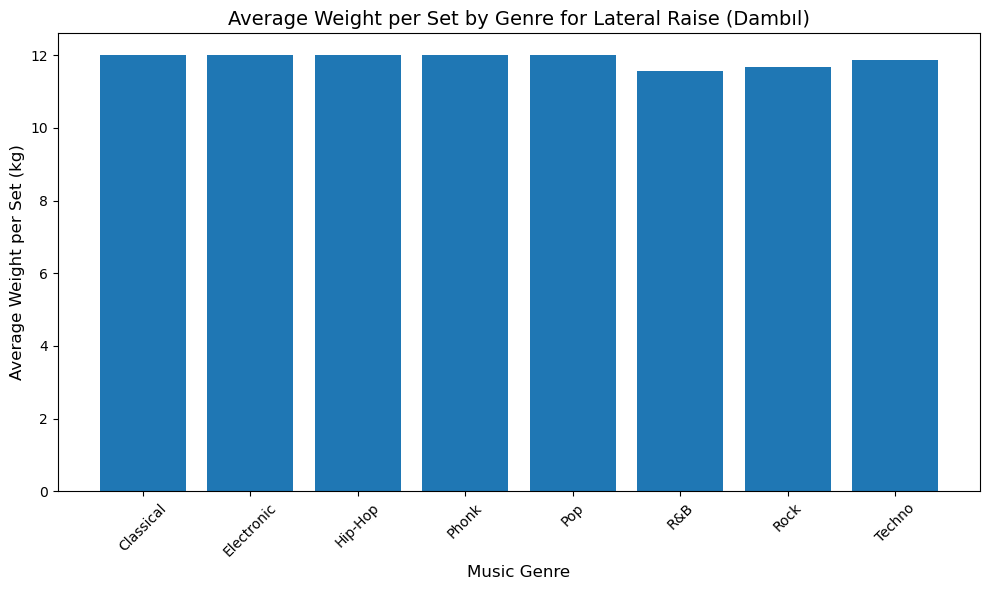

<Figure size 1000x600 with 0 Axes>

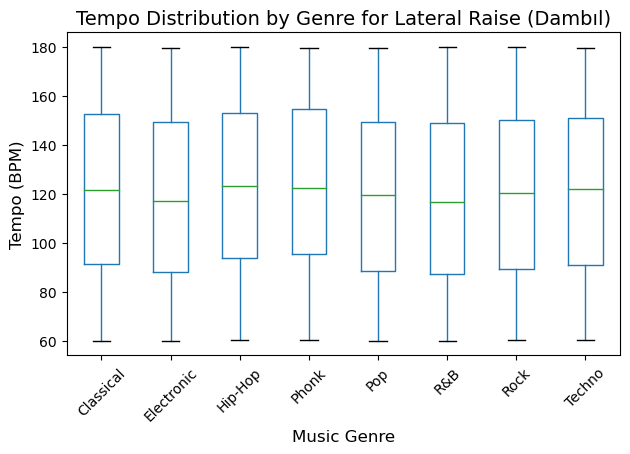

<Figure size 1000x600 with 0 Axes>

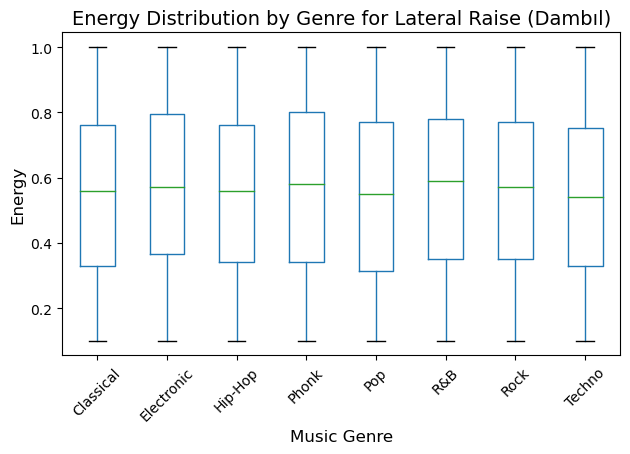

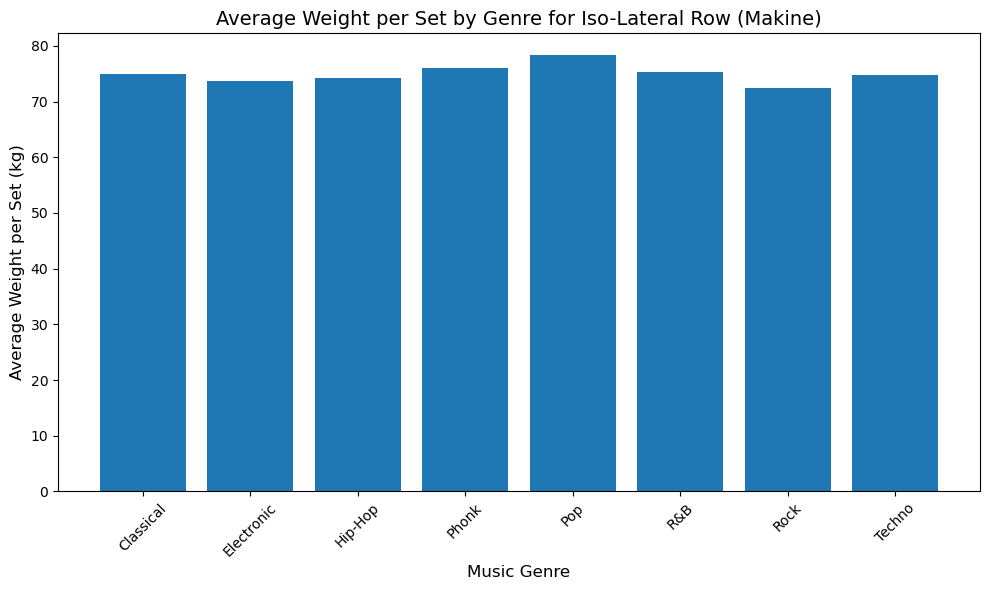

<Figure size 1000x600 with 0 Axes>

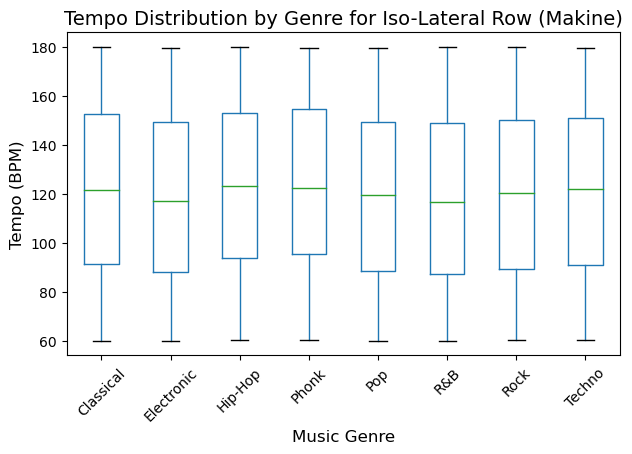

<Figure size 1000x600 with 0 Axes>

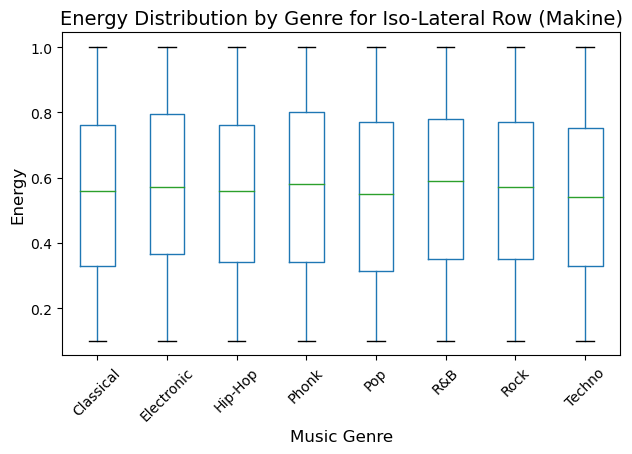

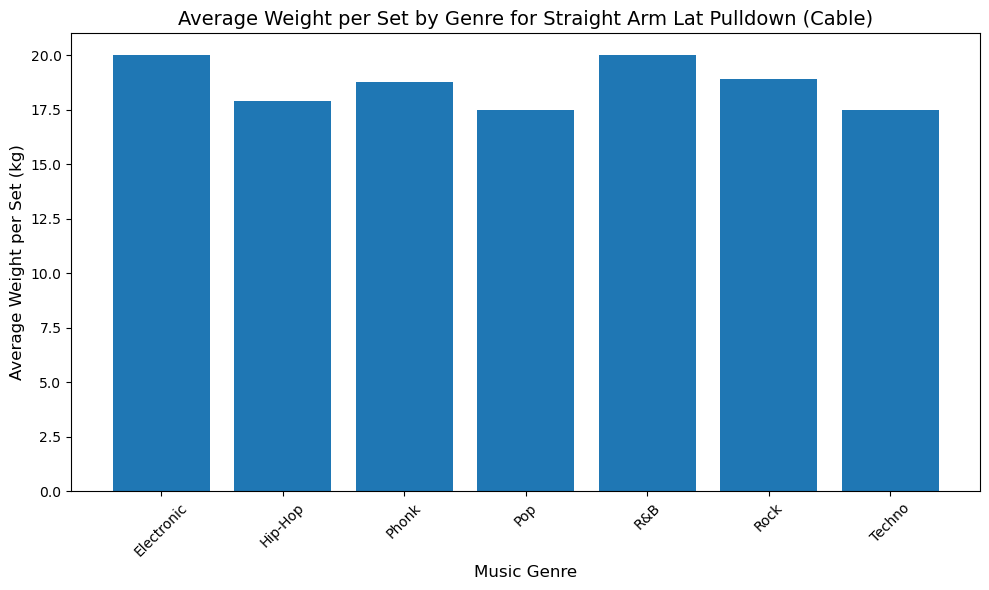

<Figure size 1000x600 with 0 Axes>

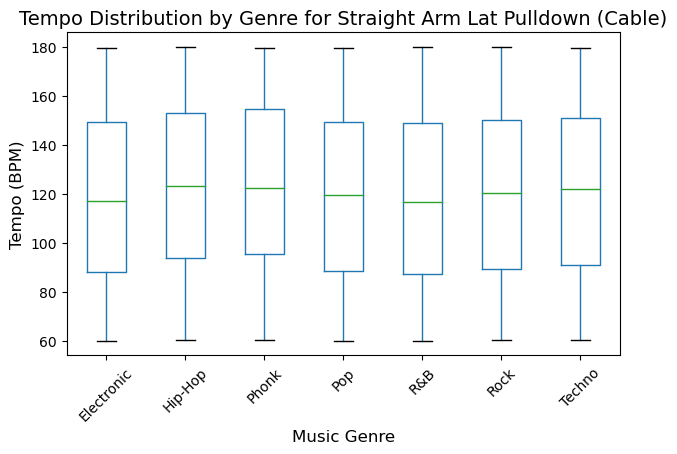

<Figure size 1000x600 with 0 Axes>

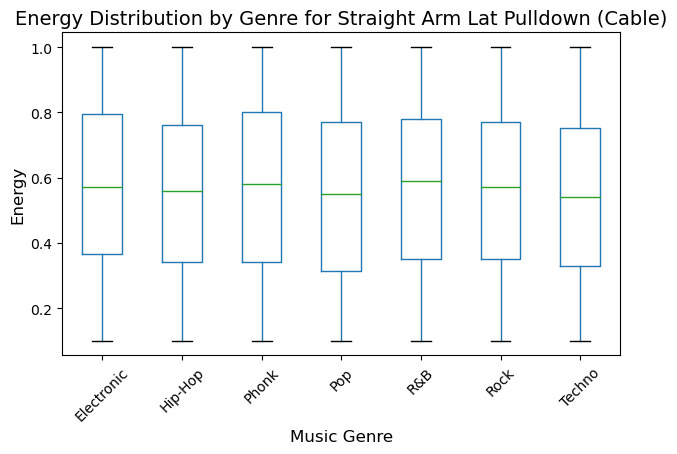

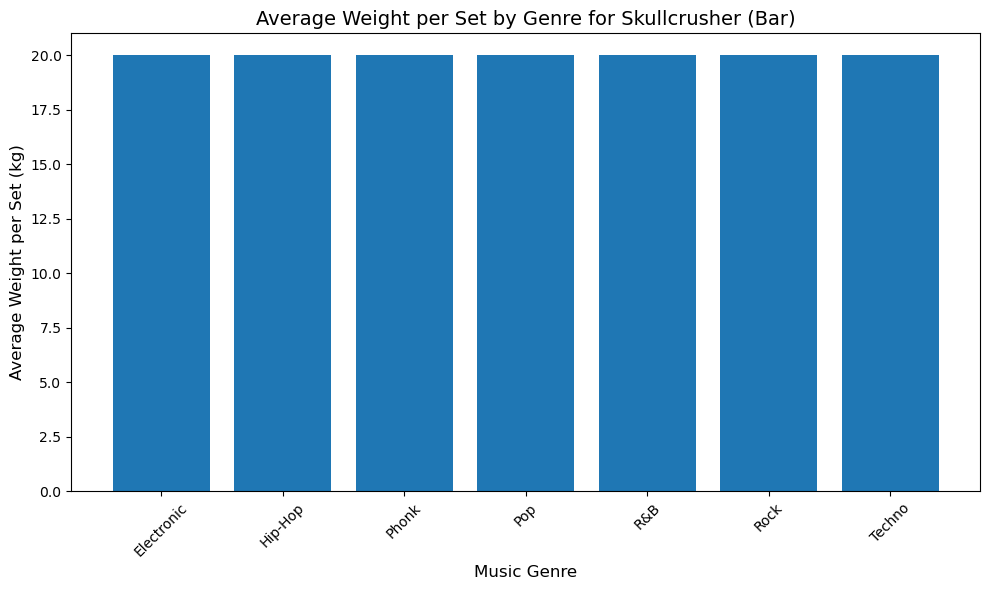

<Figure size 1000x600 with 0 Axes>

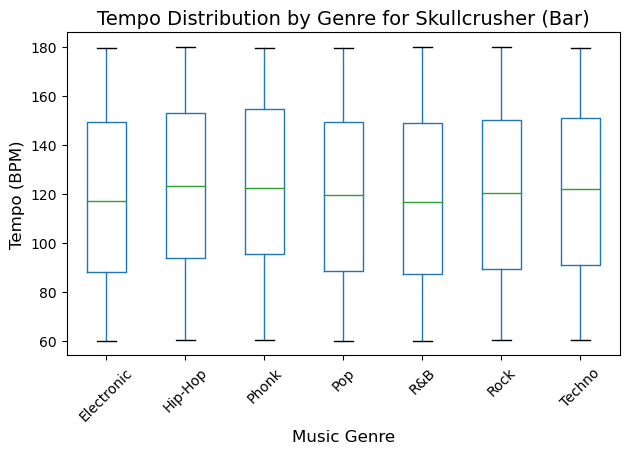

<Figure size 1000x600 with 0 Axes>

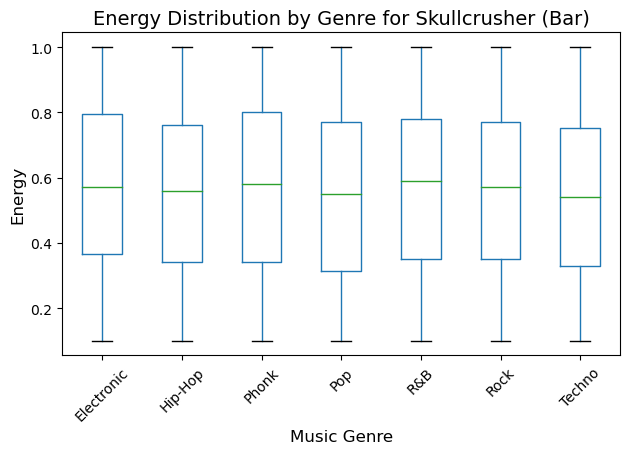

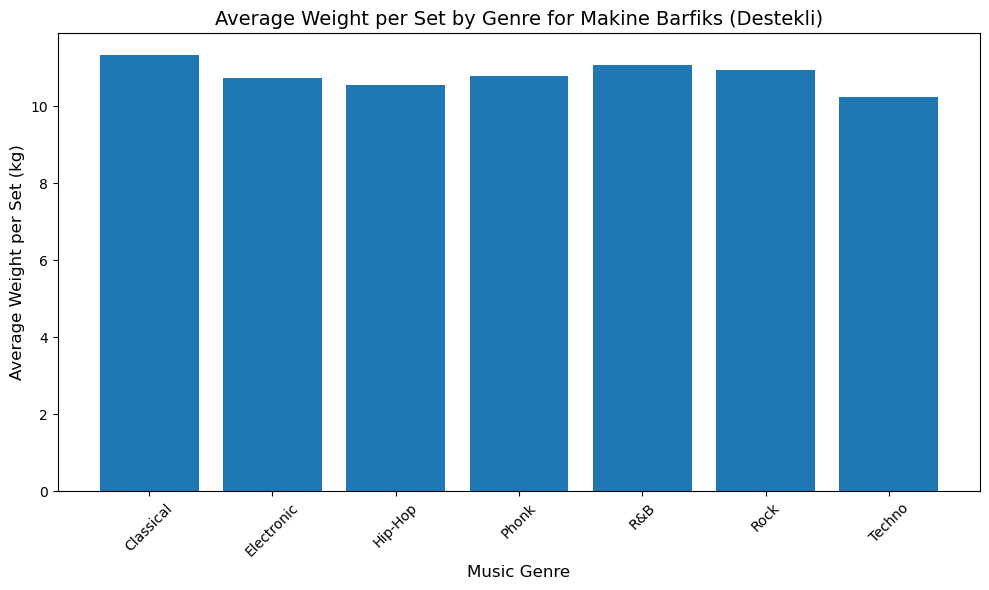

<Figure size 1000x600 with 0 Axes>

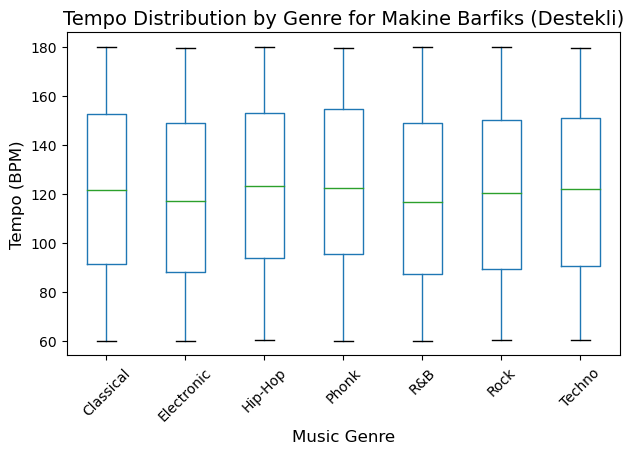

<Figure size 1000x600 with 0 Axes>

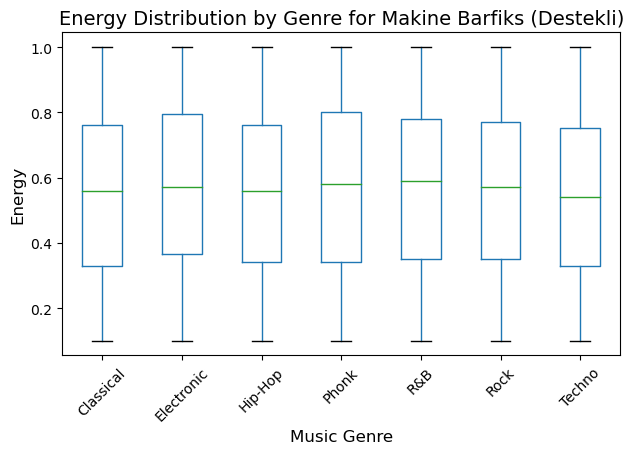

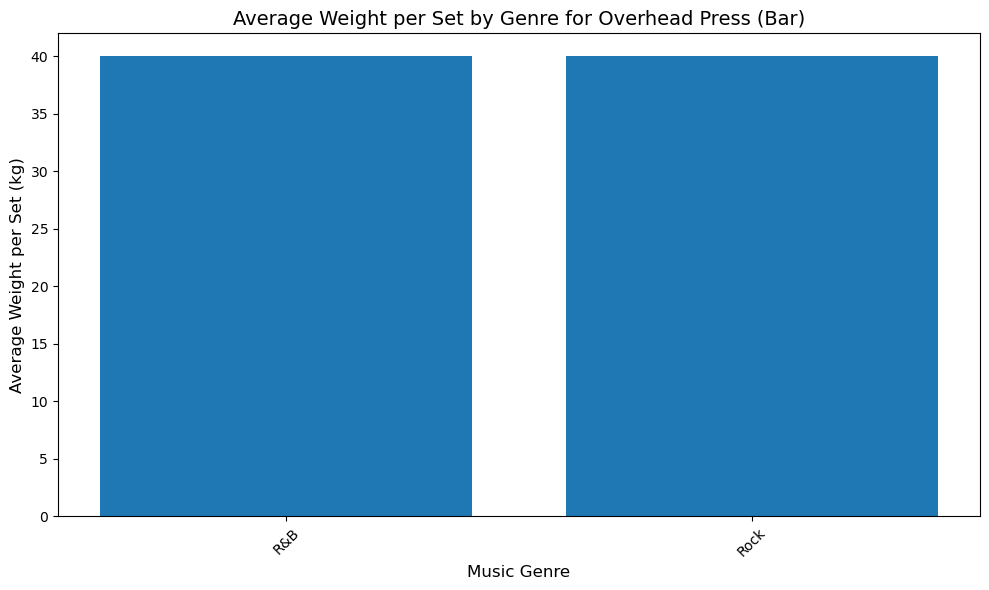

<Figure size 1000x600 with 0 Axes>

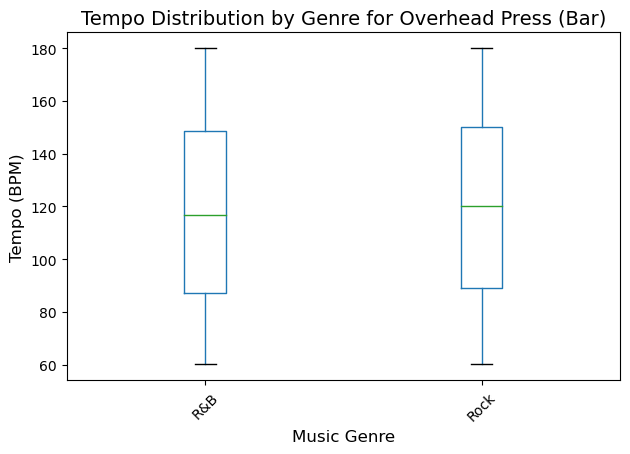

<Figure size 1000x600 with 0 Axes>

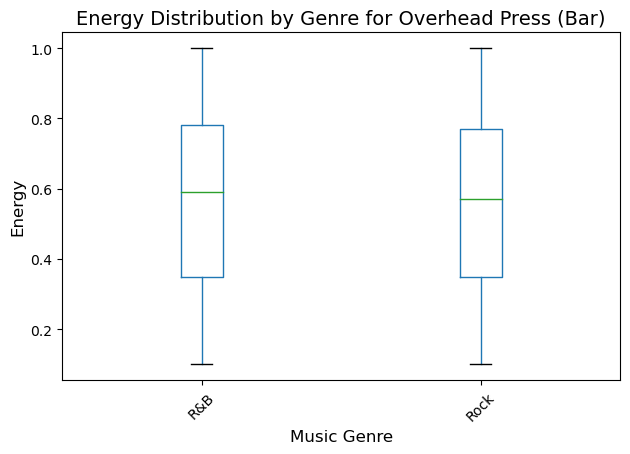

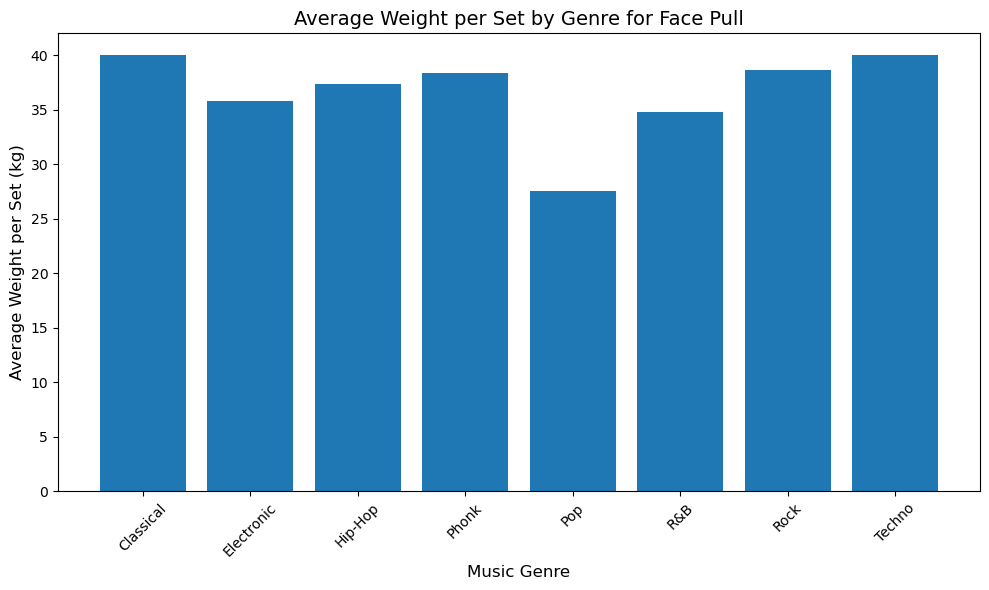

<Figure size 1000x600 with 0 Axes>

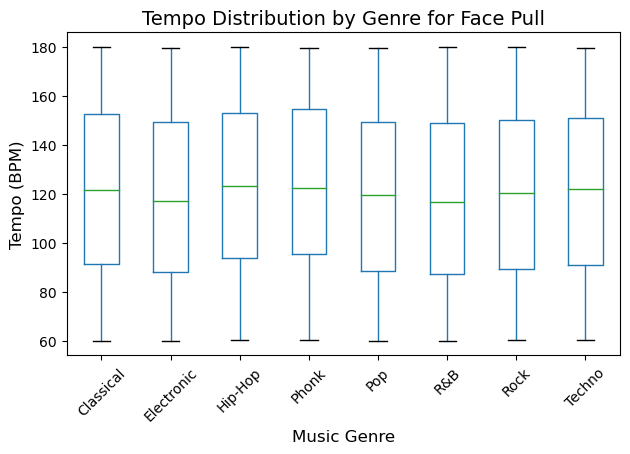

<Figure size 1000x600 with 0 Axes>

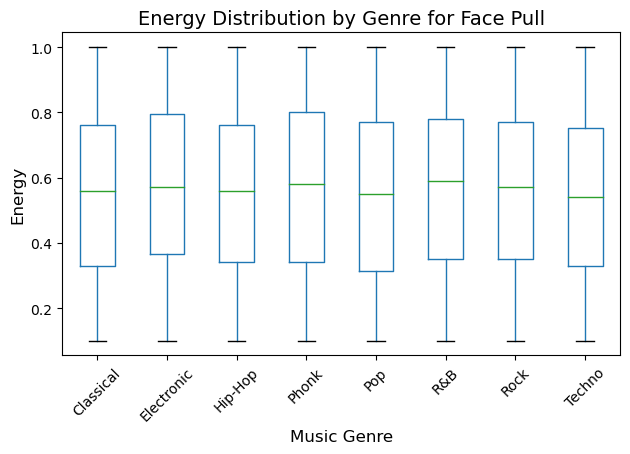

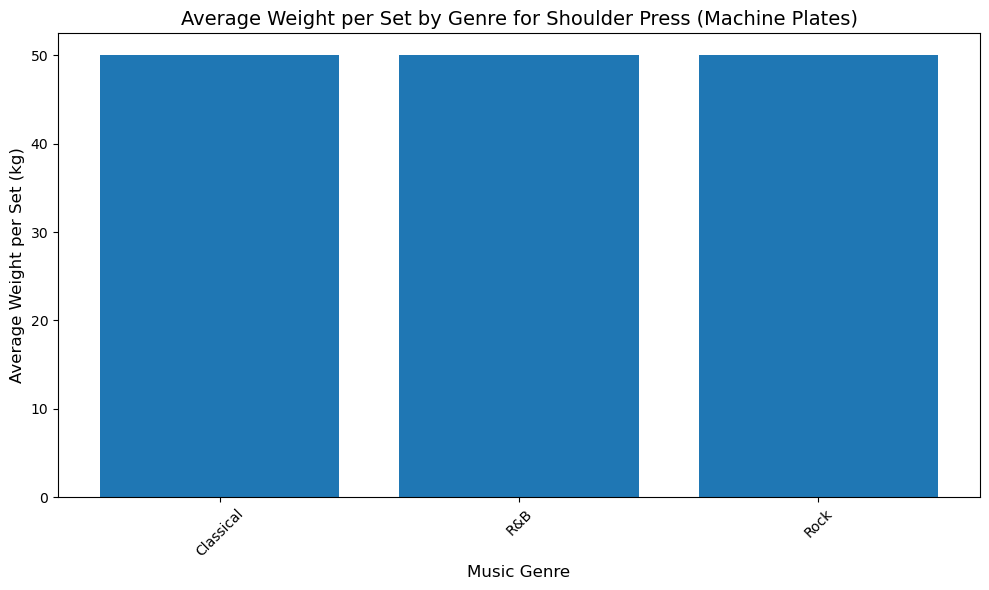

<Figure size 1000x600 with 0 Axes>

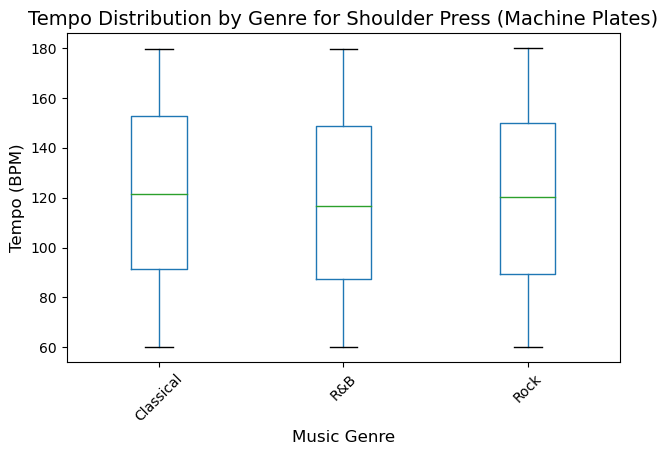

<Figure size 1000x600 with 0 Axes>

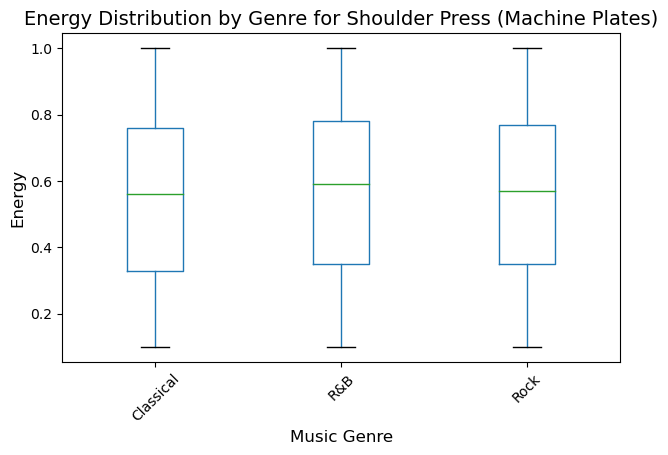

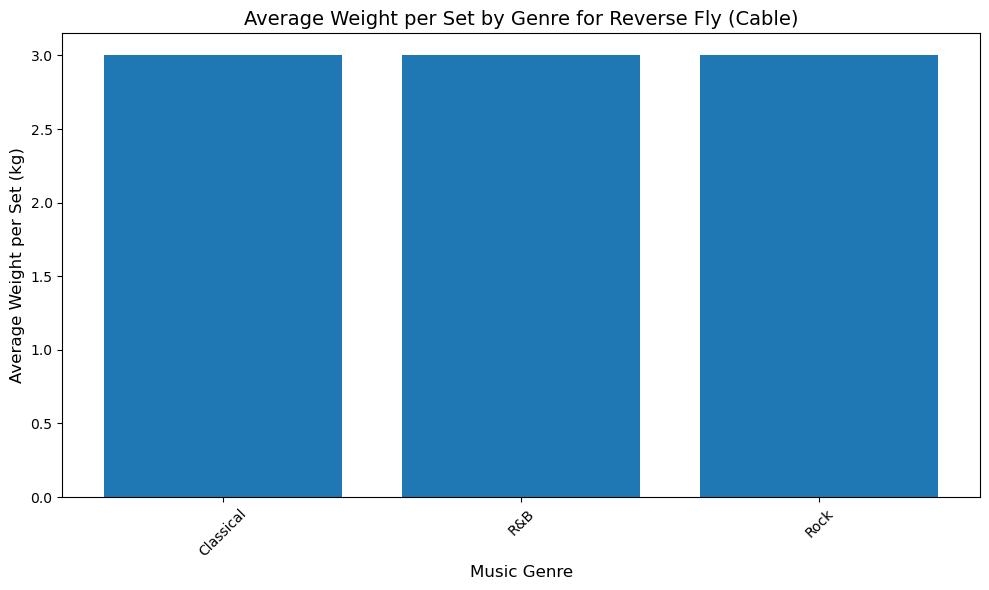

<Figure size 1000x600 with 0 Axes>

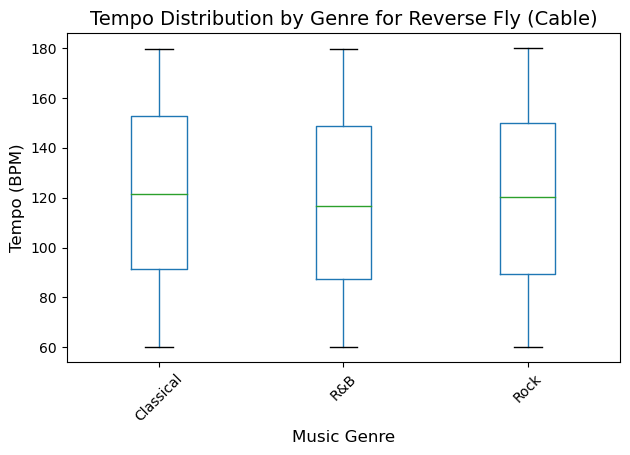

<Figure size 1000x600 with 0 Axes>

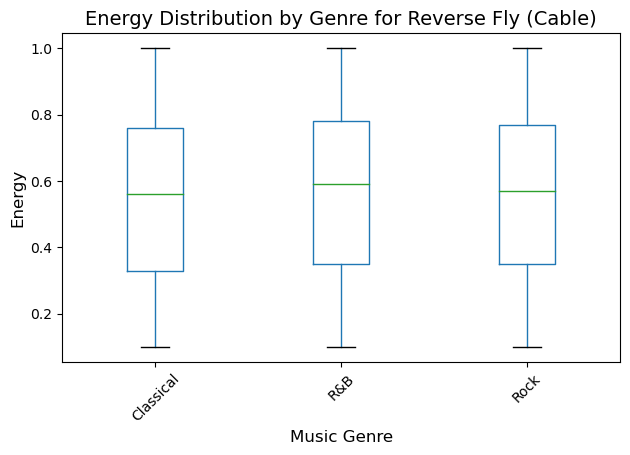

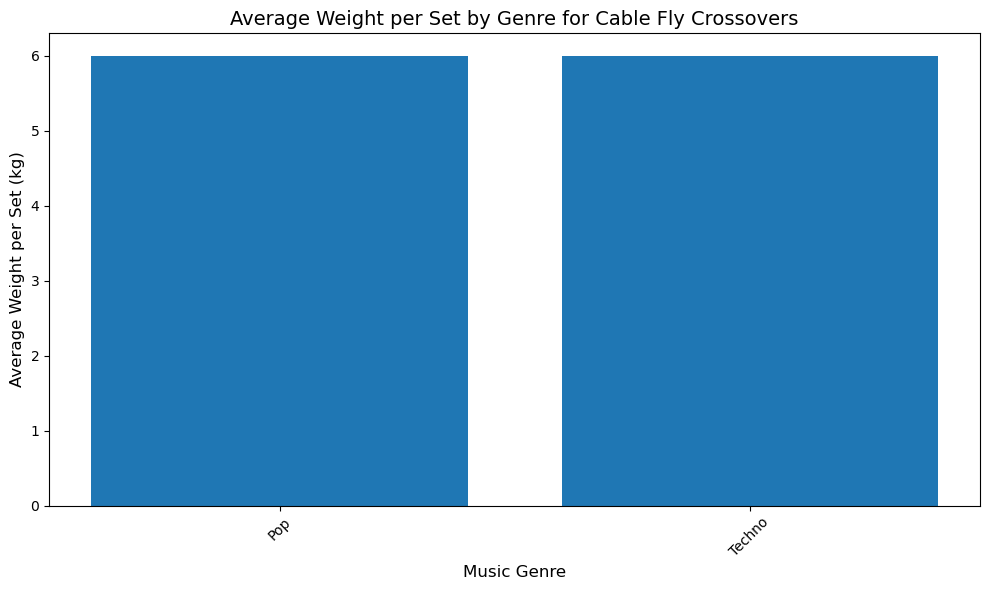

<Figure size 1000x600 with 0 Axes>

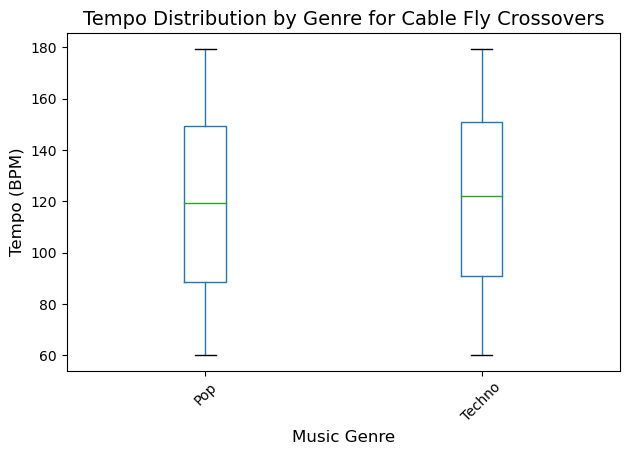

<Figure size 1000x600 with 0 Axes>

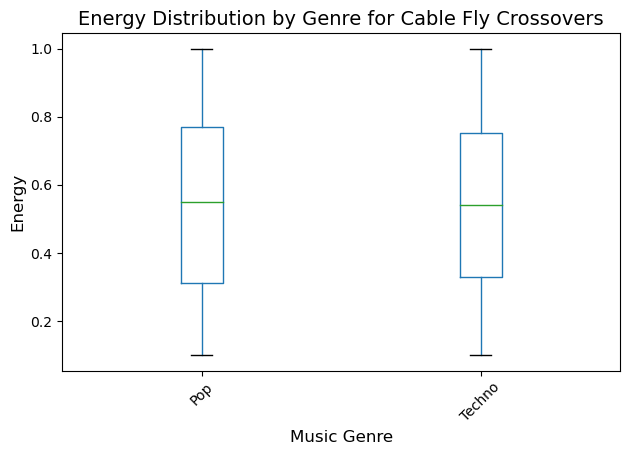

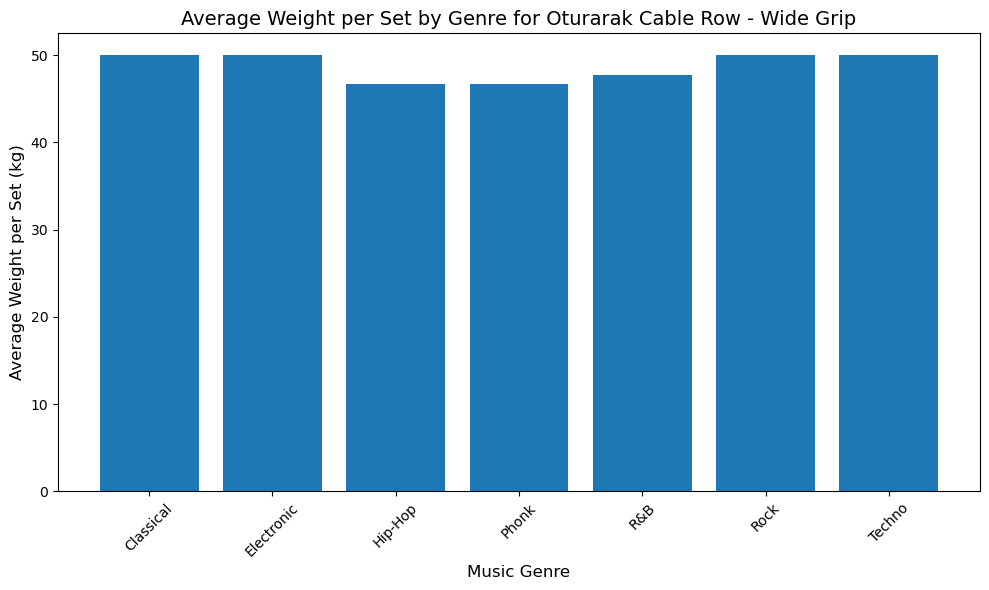

<Figure size 1000x600 with 0 Axes>

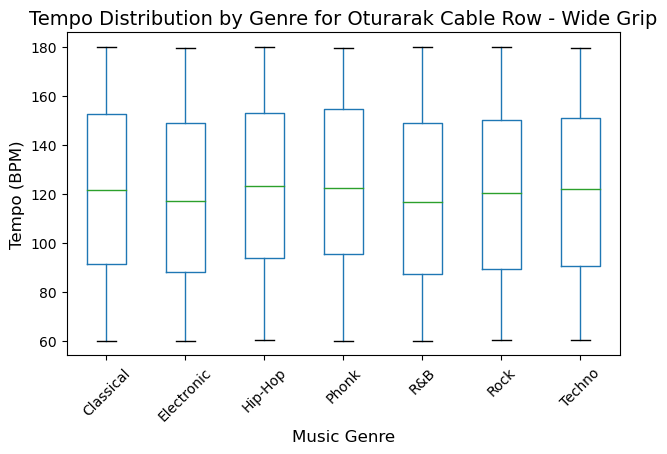

<Figure size 1000x600 with 0 Axes>

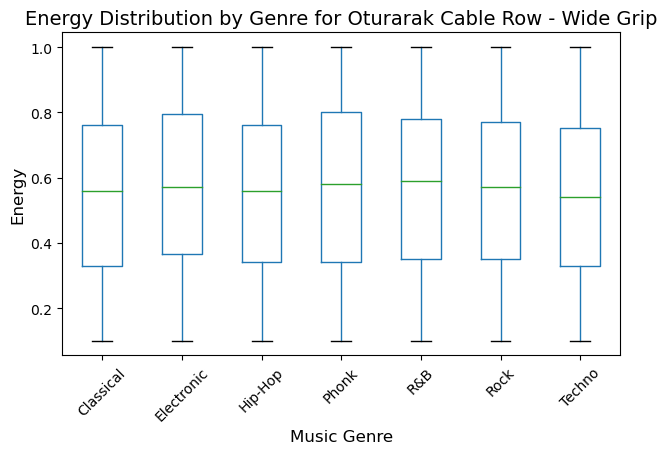

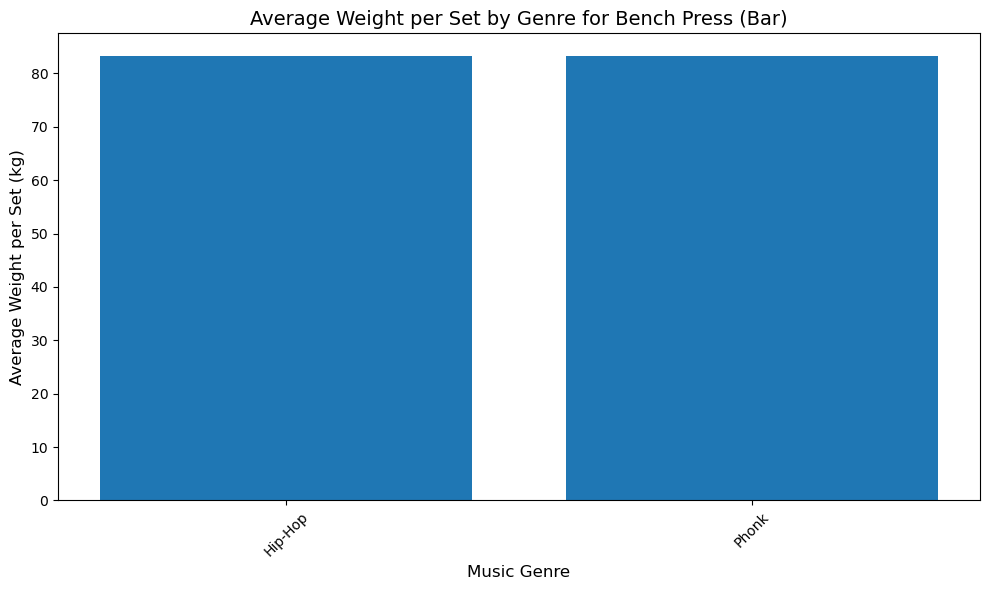

<Figure size 1000x600 with 0 Axes>

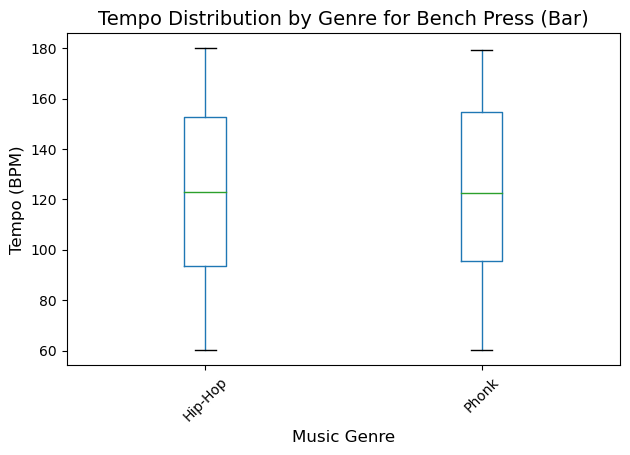

<Figure size 1000x600 with 0 Axes>

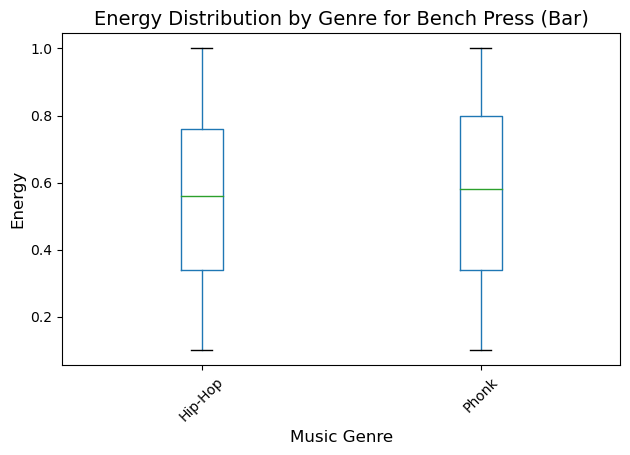

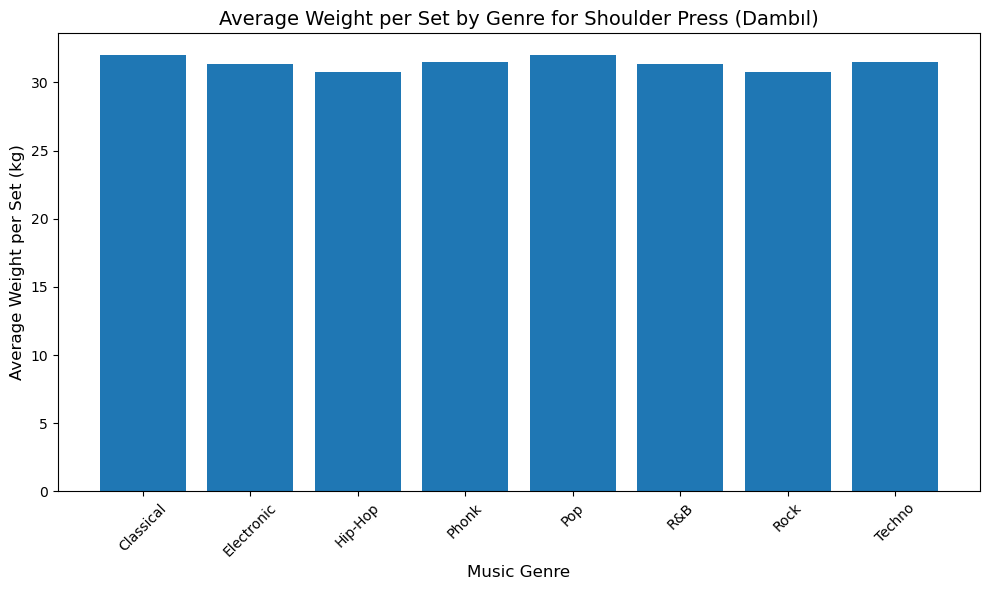

<Figure size 1000x600 with 0 Axes>

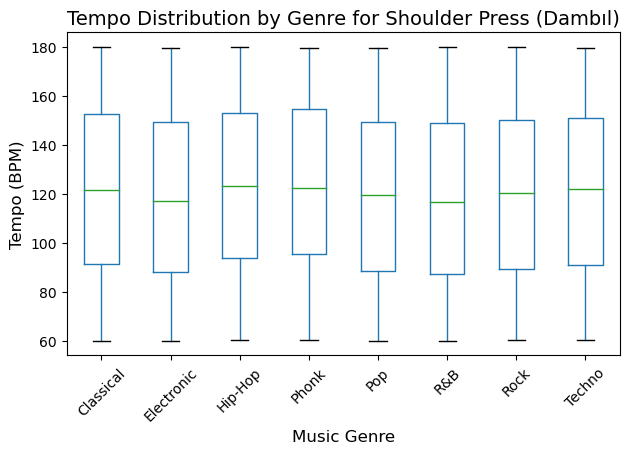

<Figure size 1000x600 with 0 Axes>

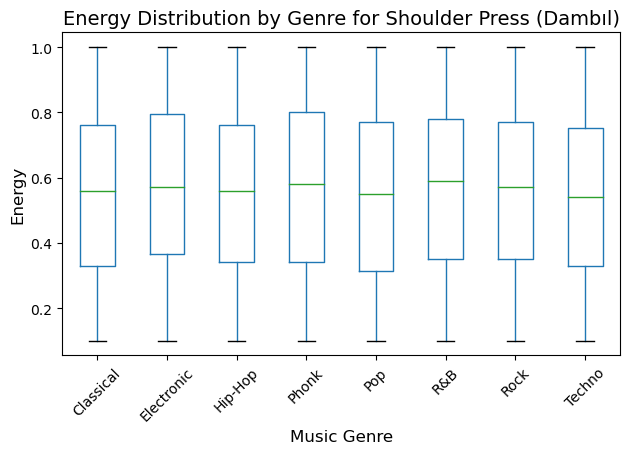

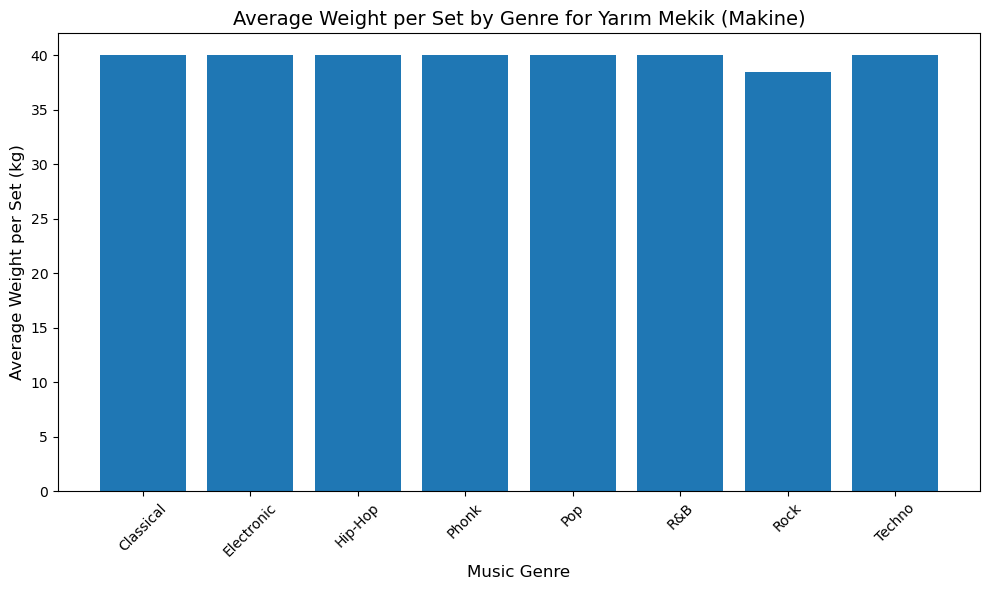

<Figure size 1000x600 with 0 Axes>

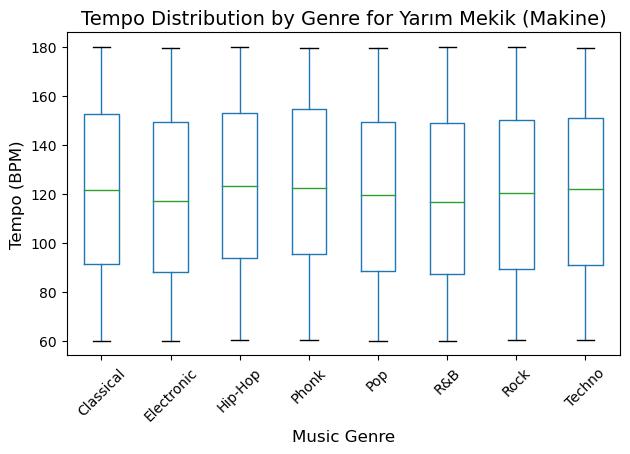

<Figure size 1000x600 with 0 Axes>

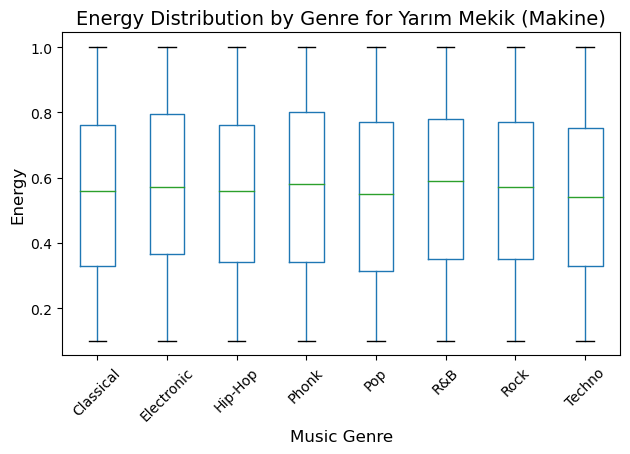

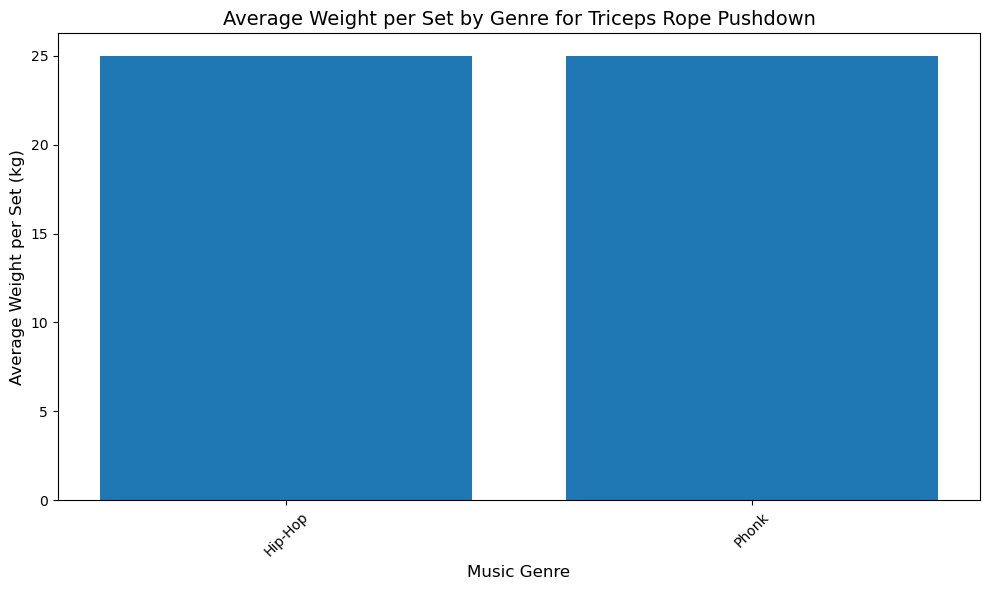

<Figure size 1000x600 with 0 Axes>

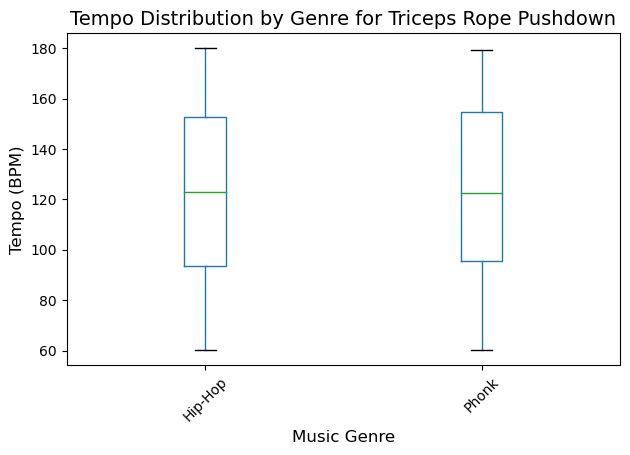

<Figure size 1000x600 with 0 Axes>

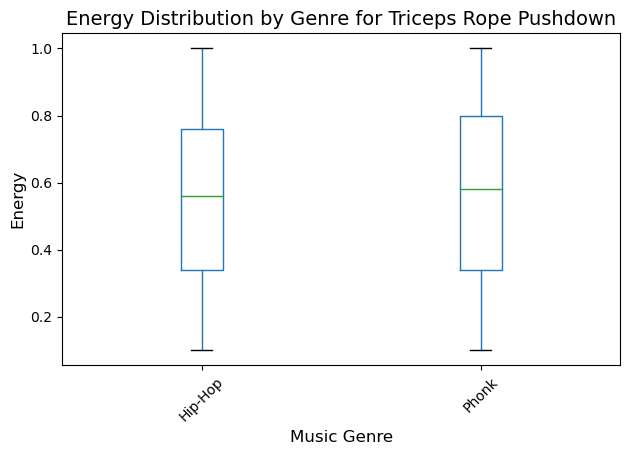

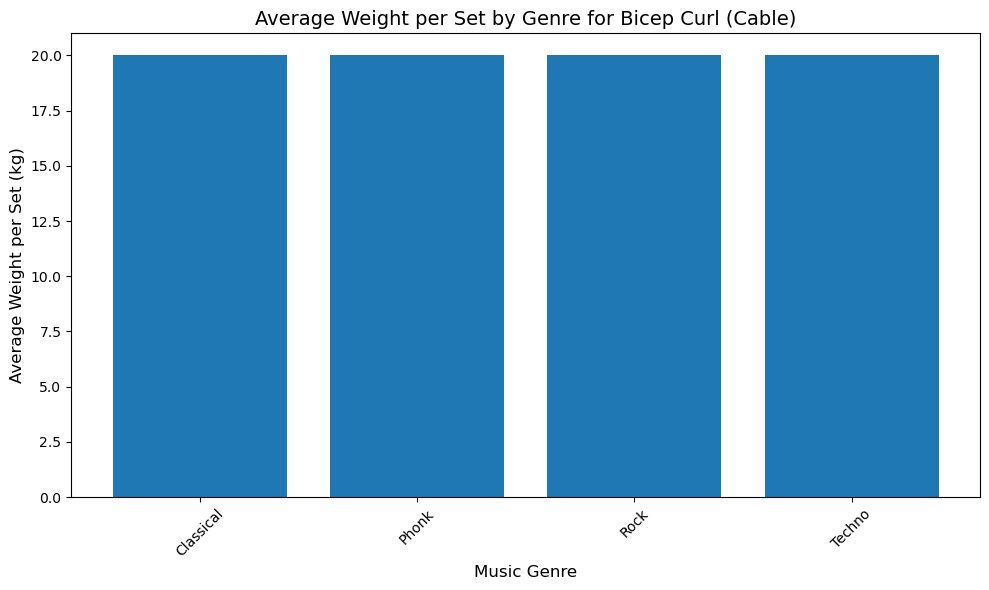

<Figure size 1000x600 with 0 Axes>

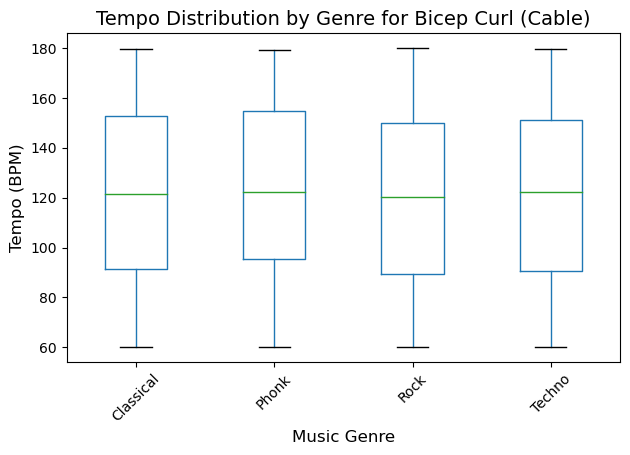

<Figure size 1000x600 with 0 Axes>

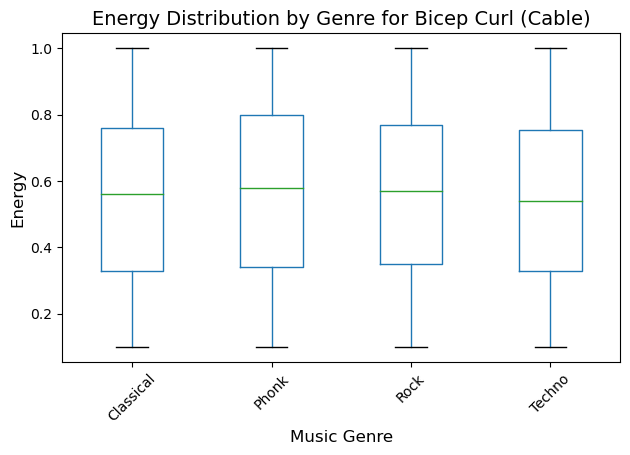

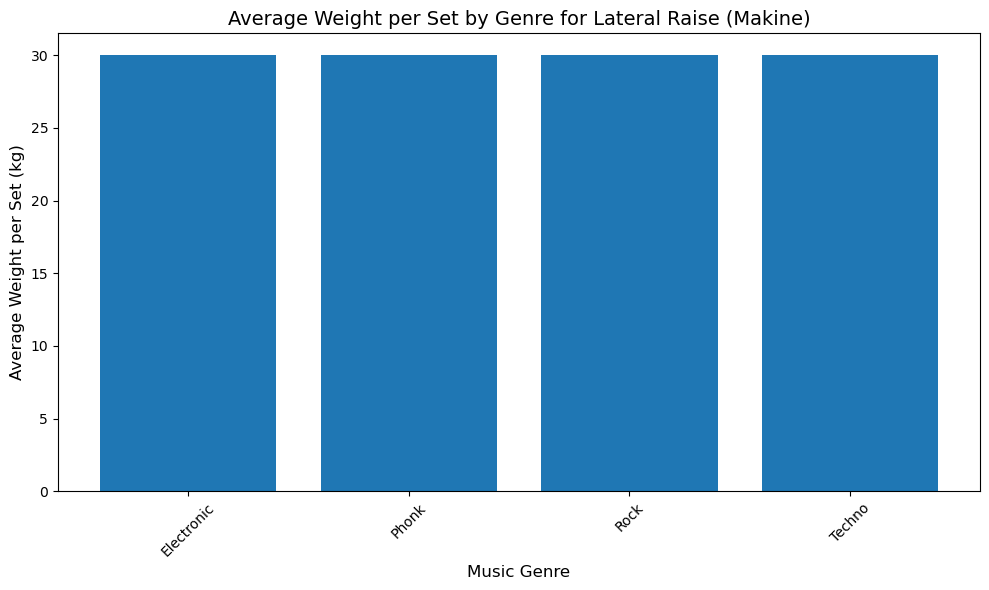

<Figure size 1000x600 with 0 Axes>

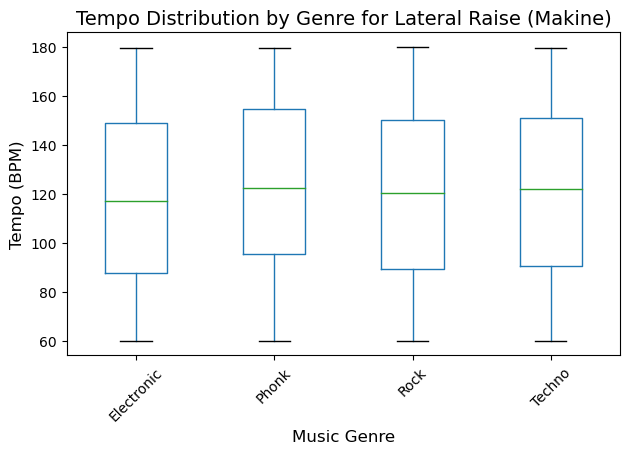

<Figure size 1000x600 with 0 Axes>

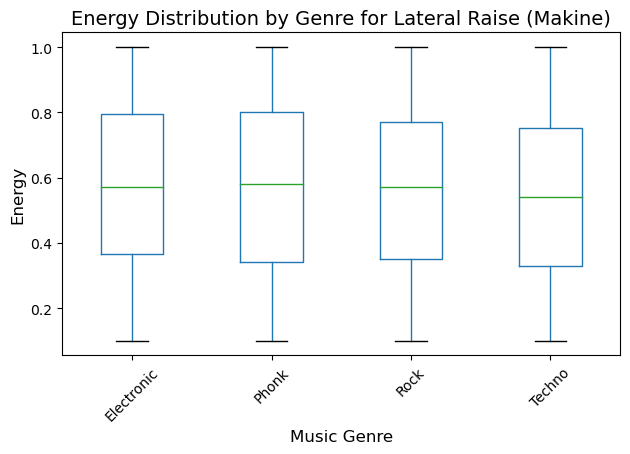

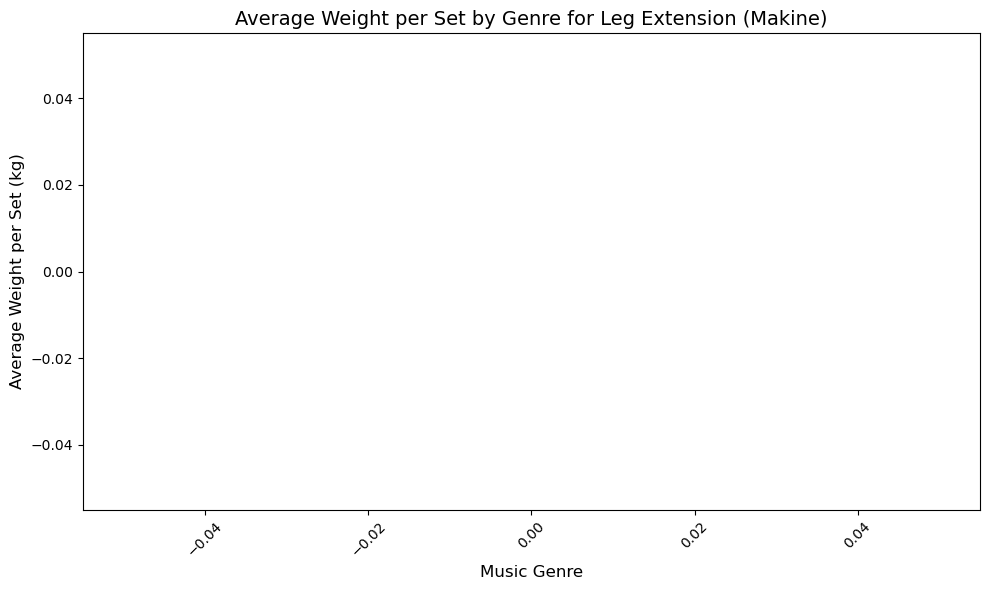

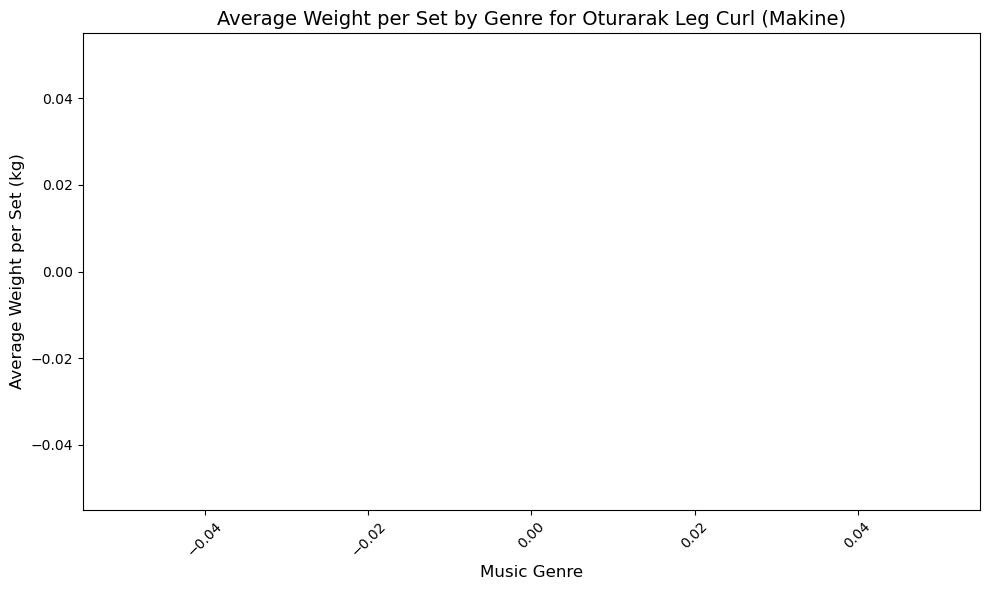

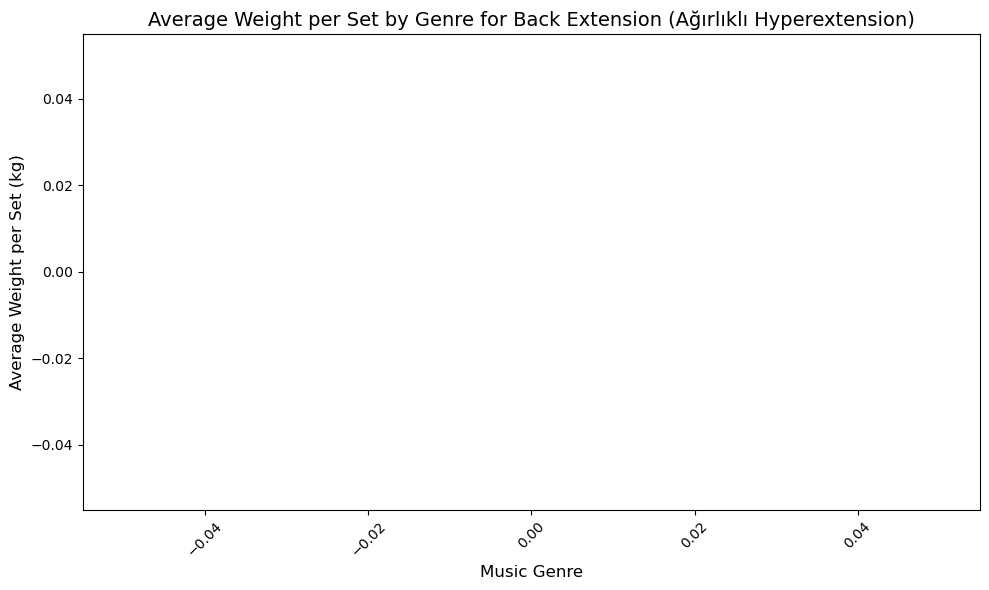

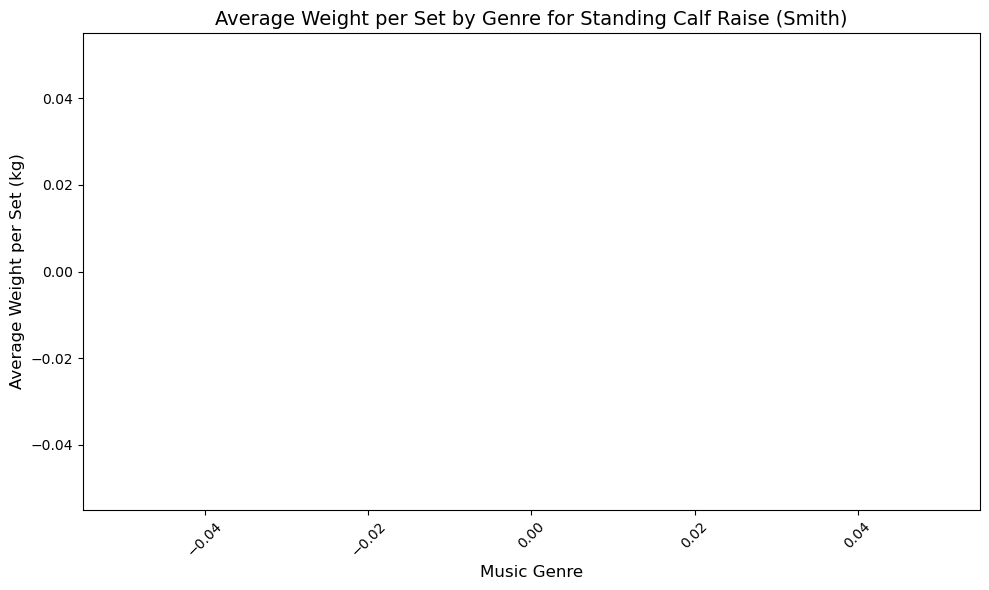

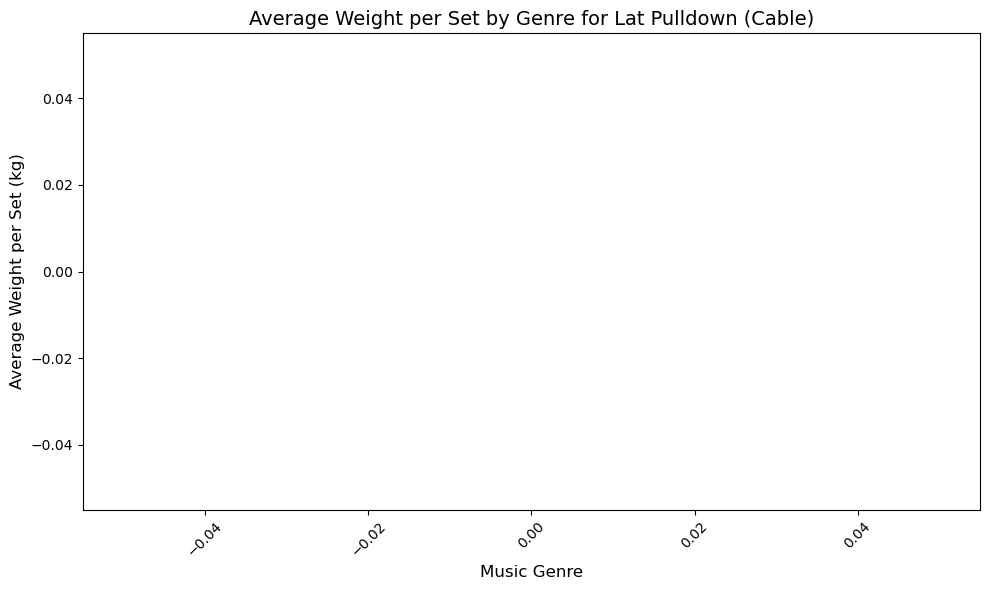

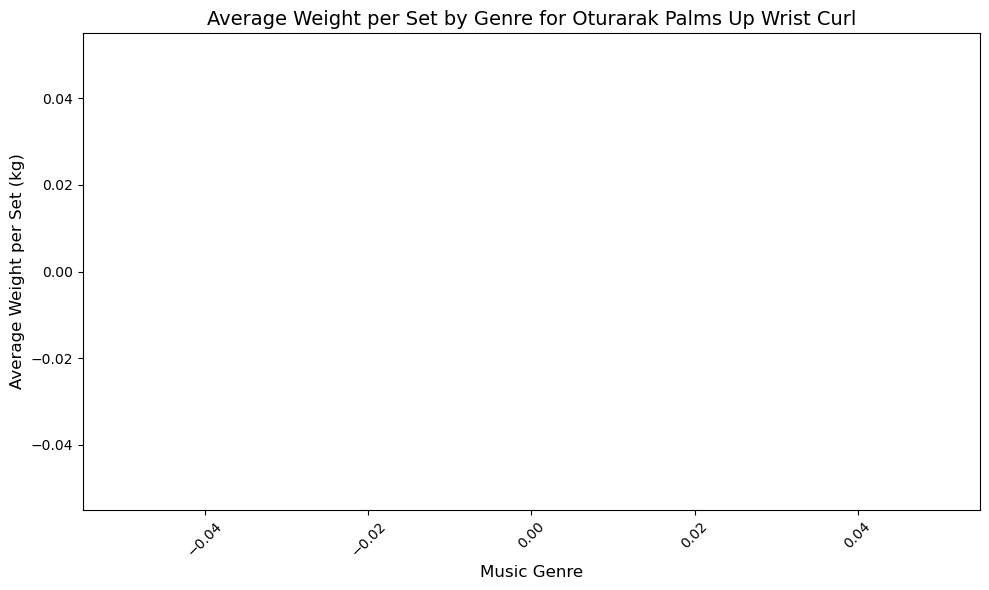

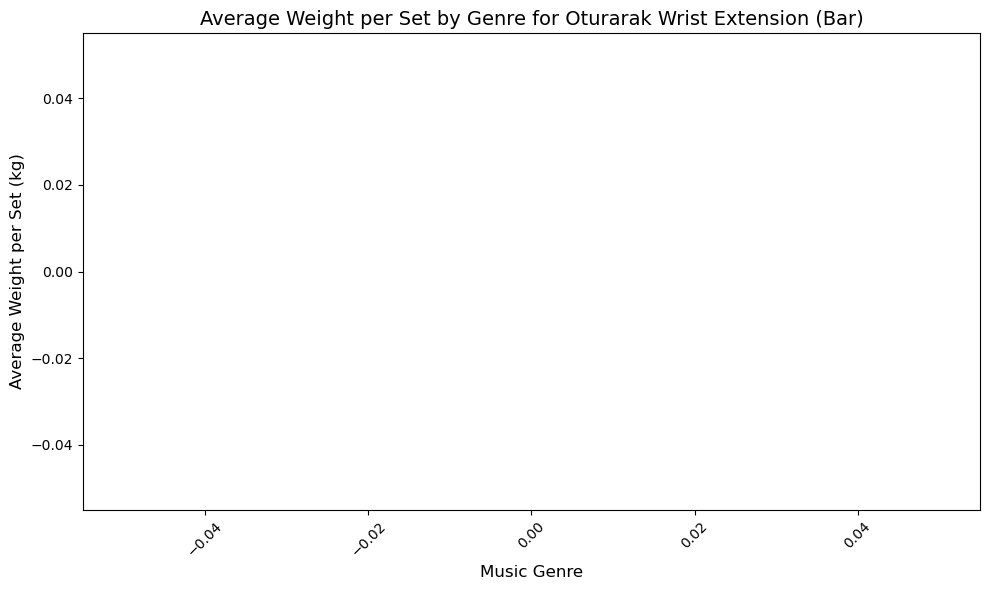

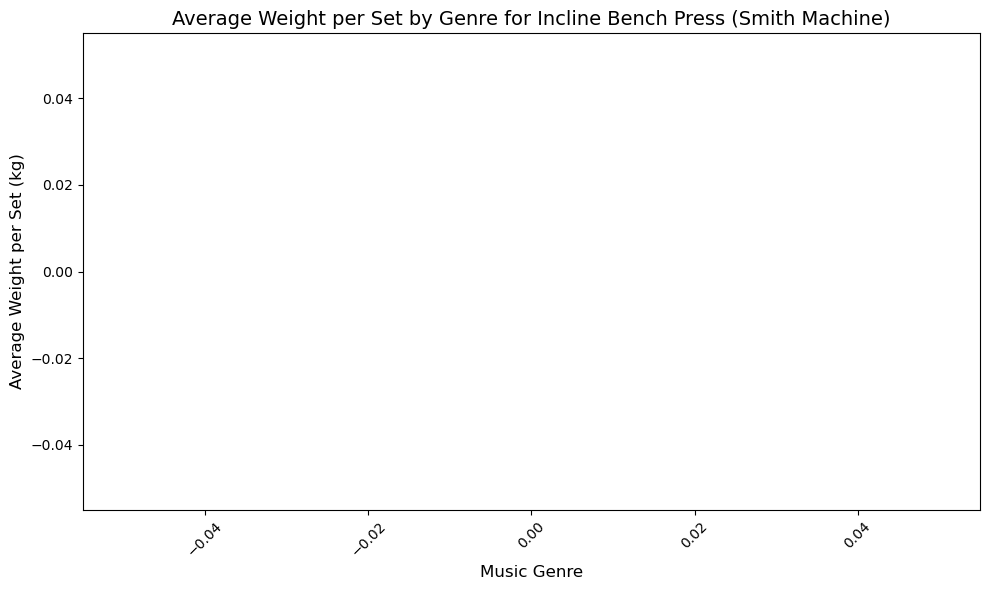

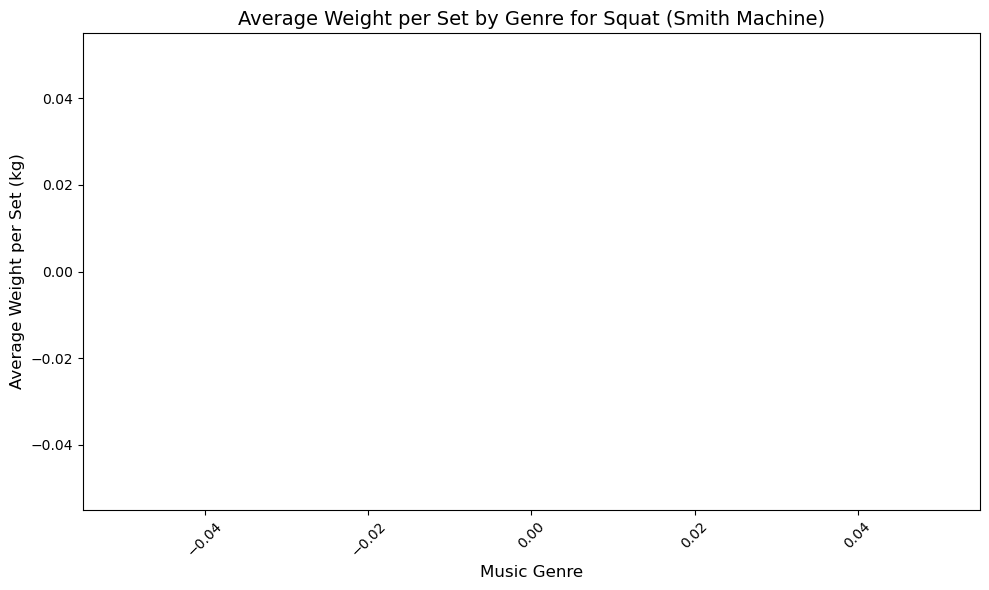

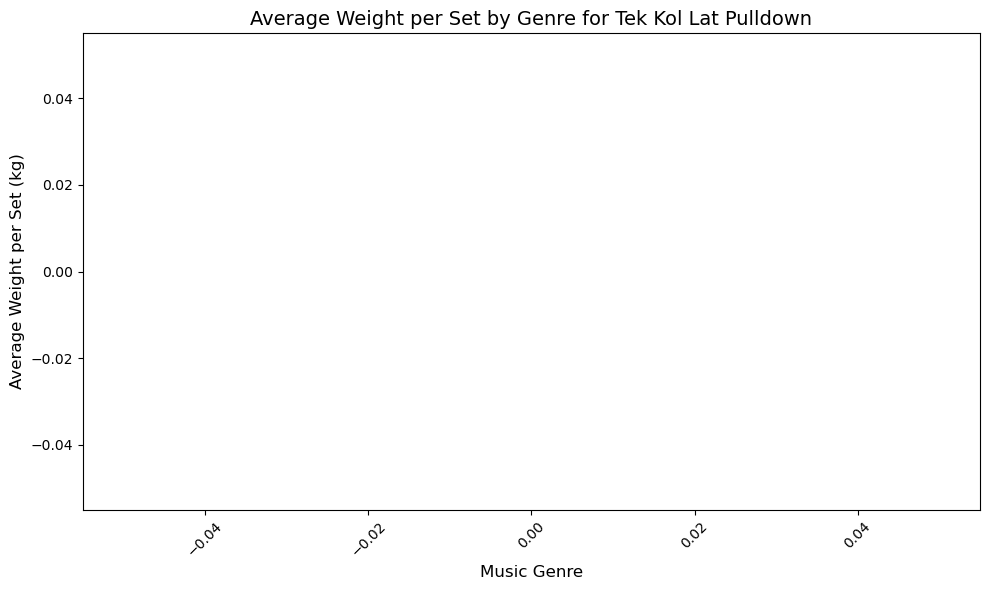

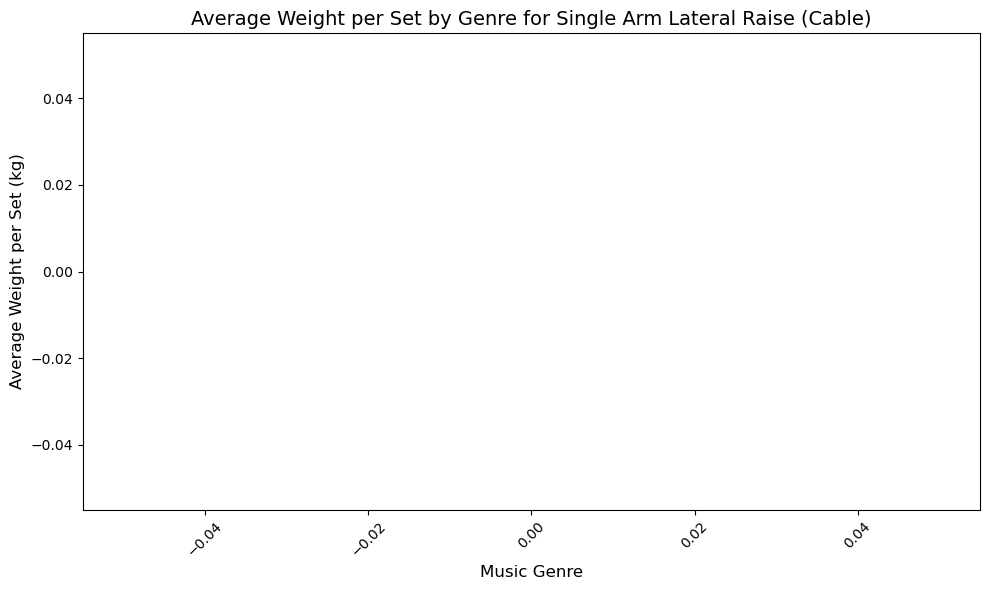

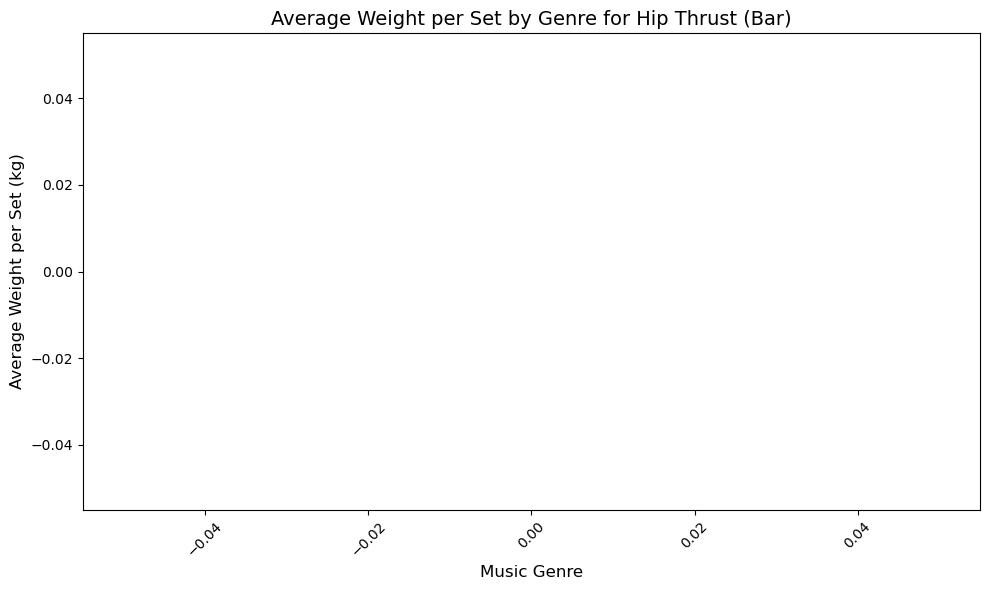

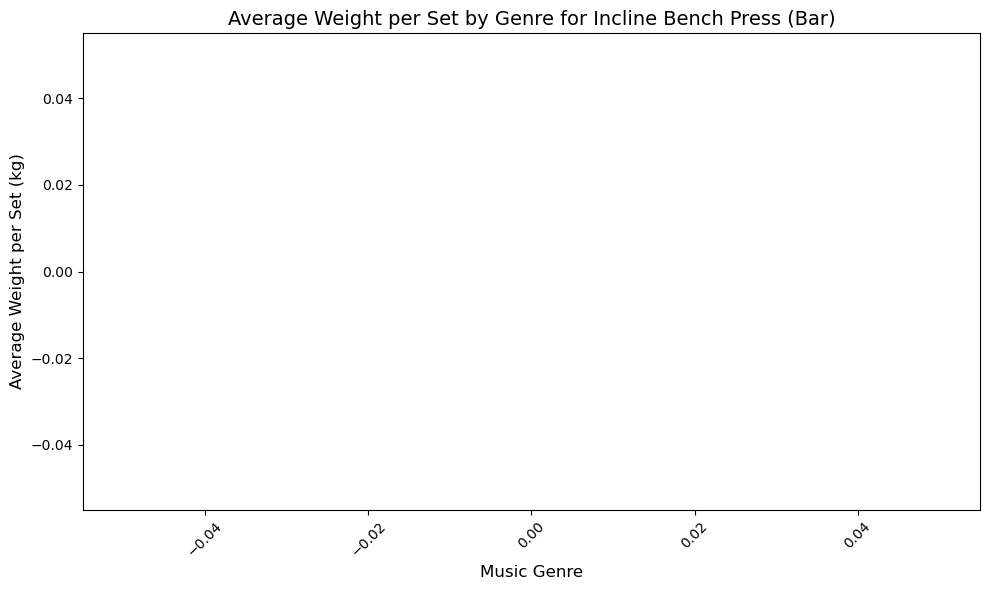

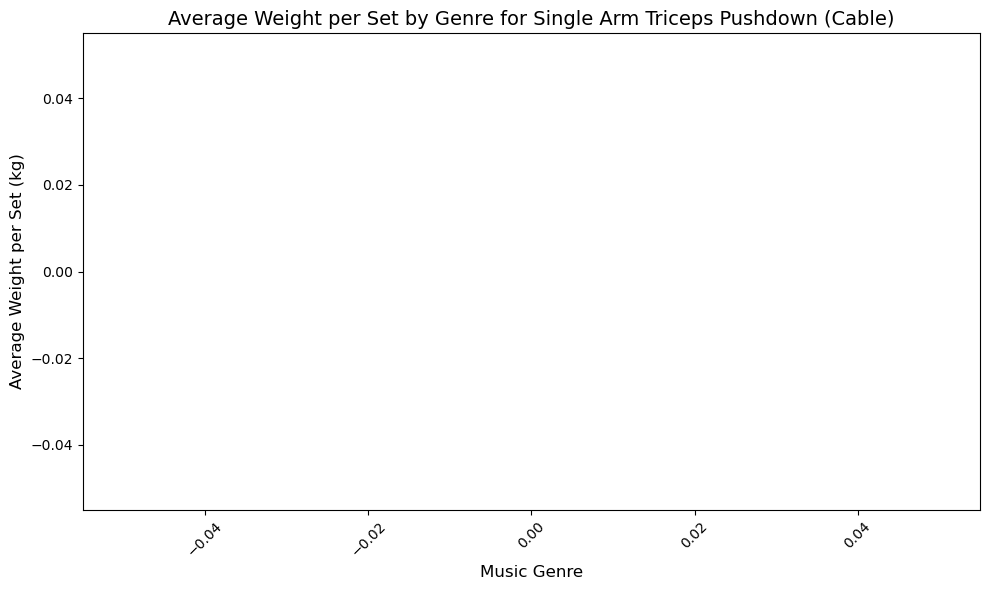

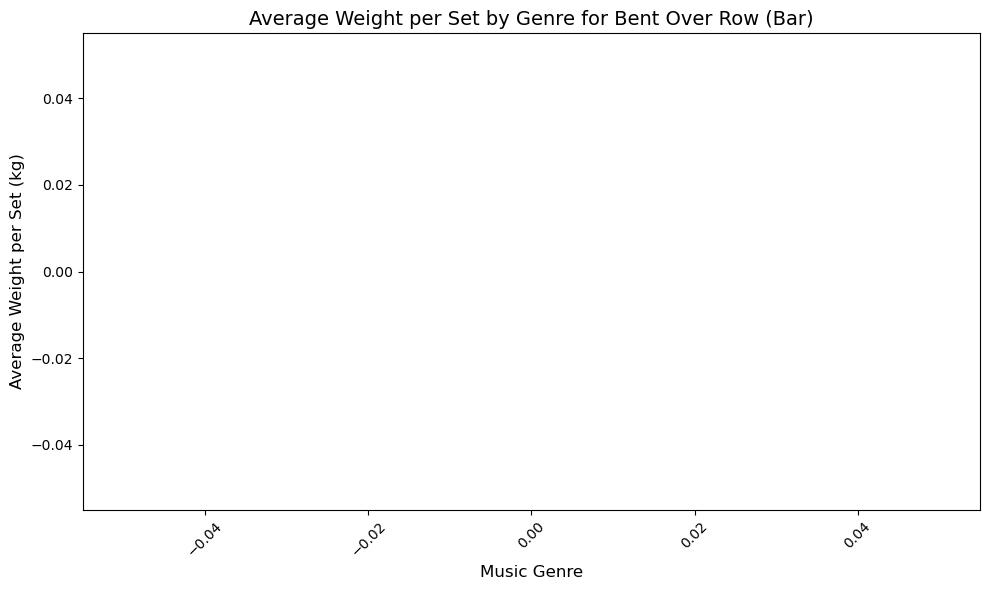

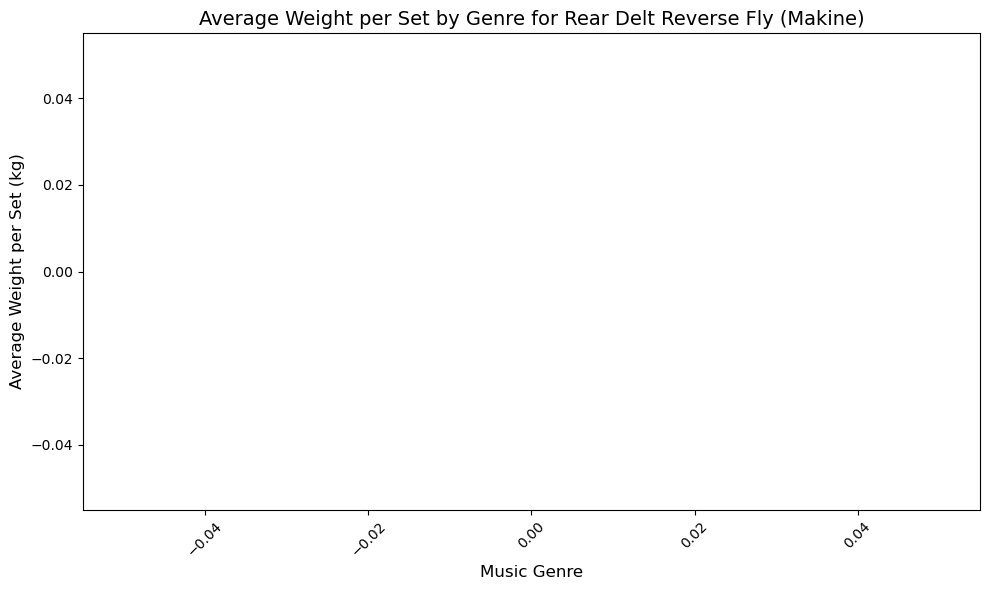

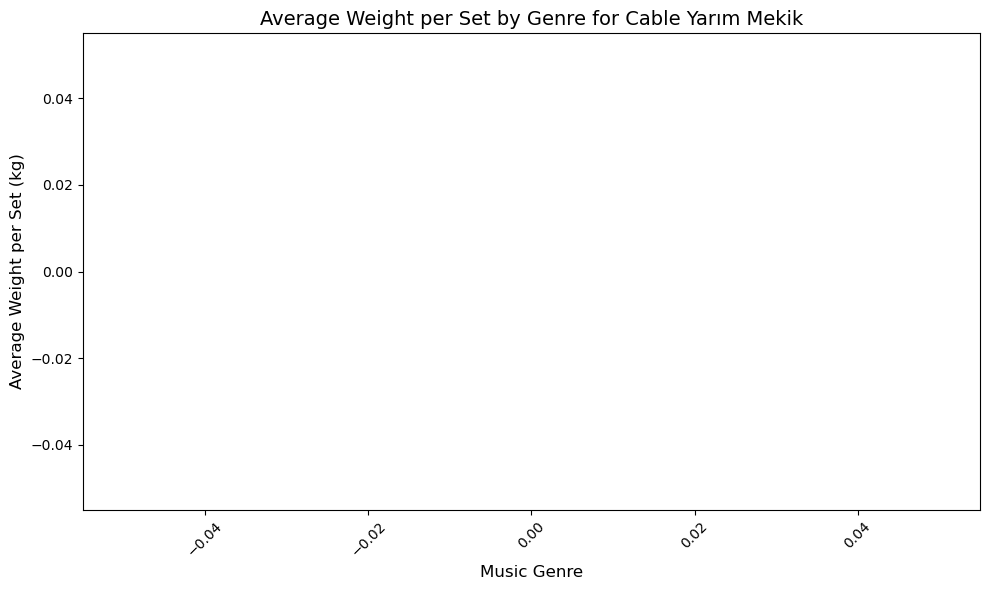

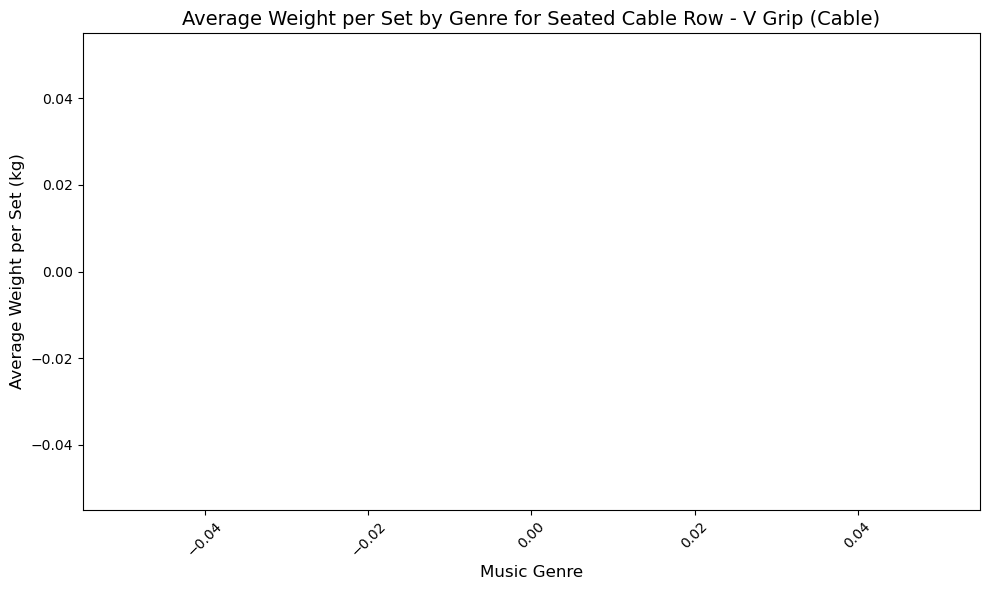

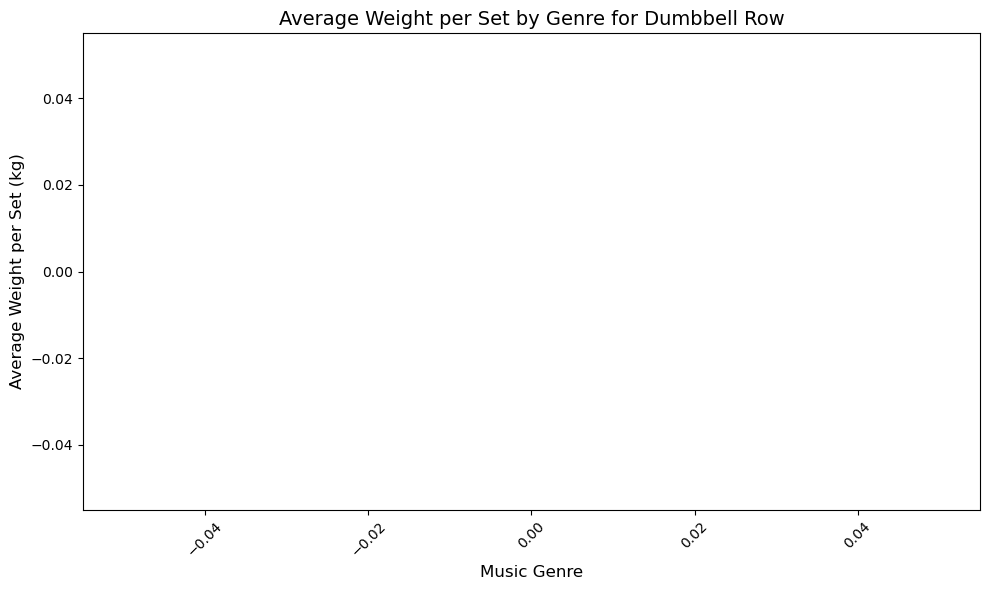

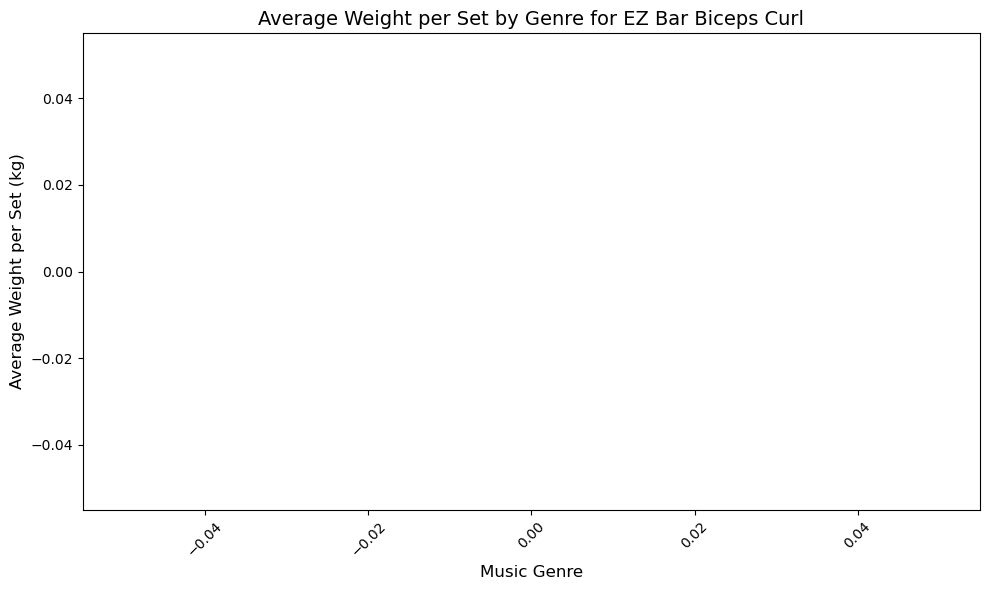

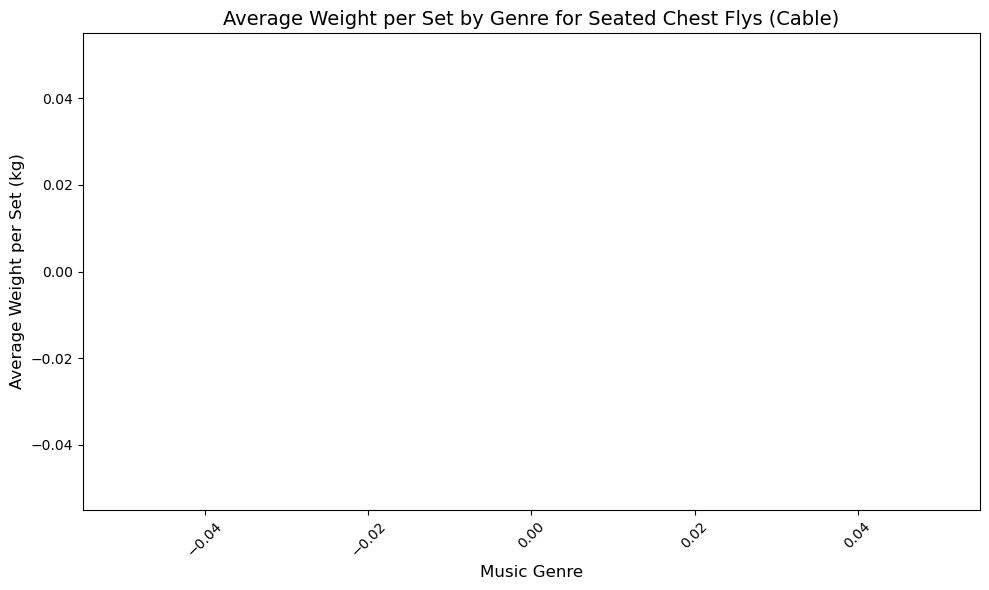

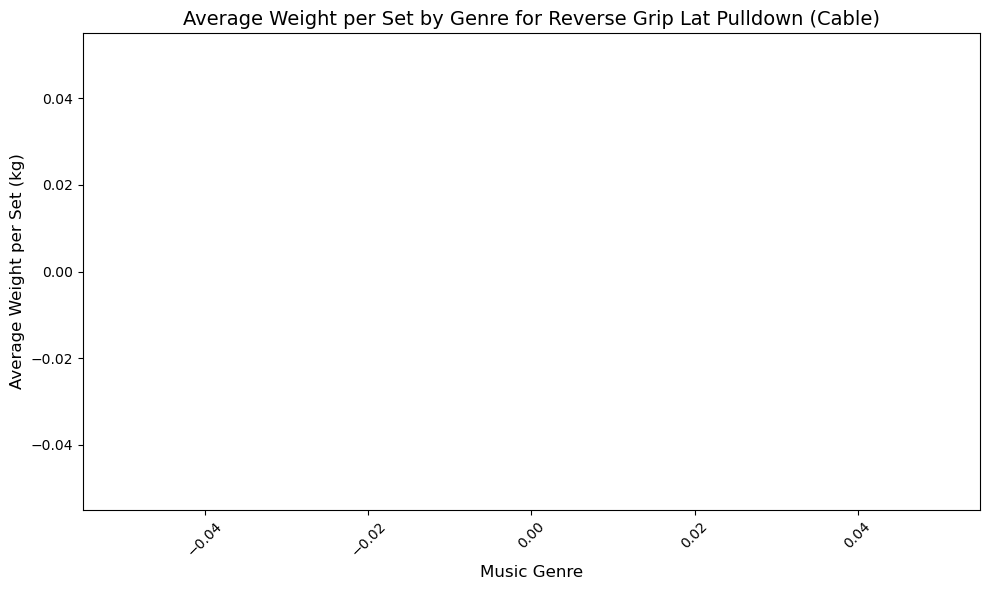

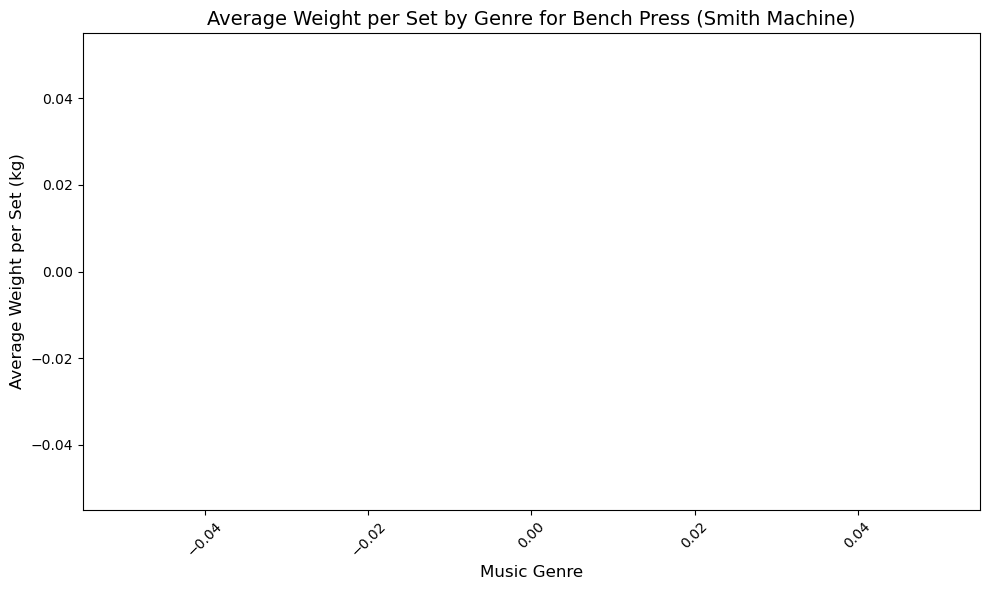

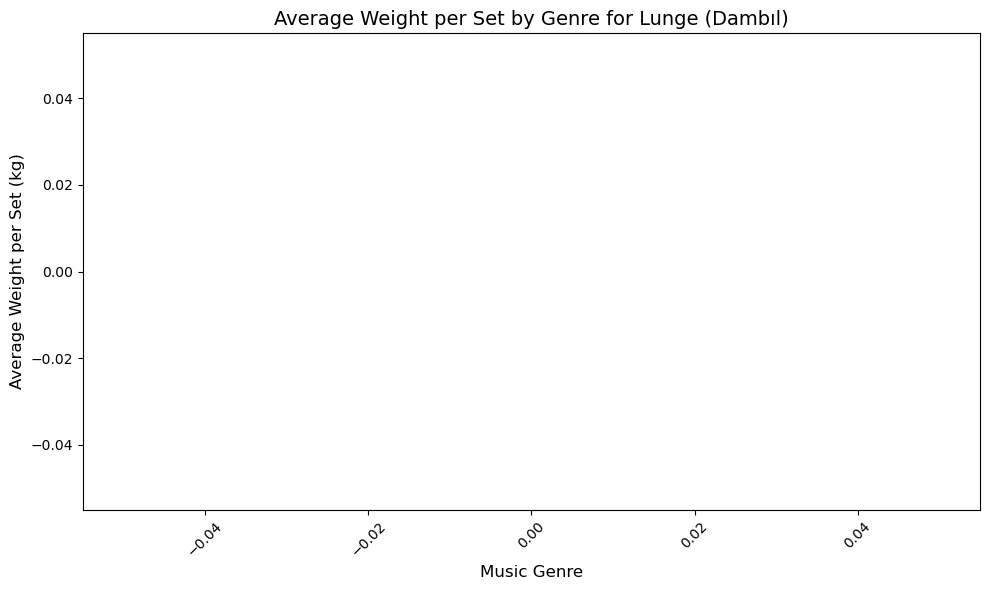

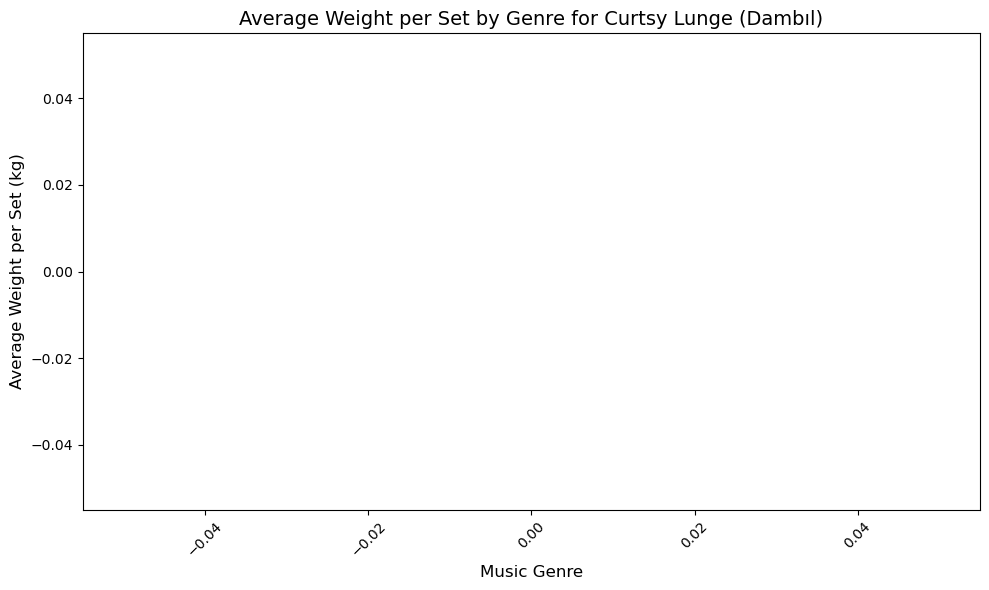

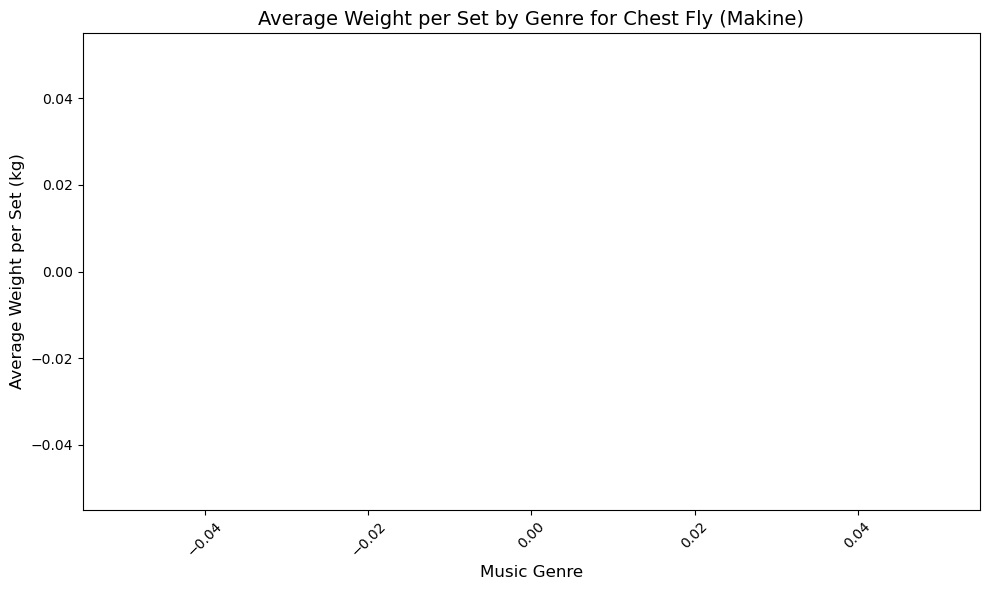

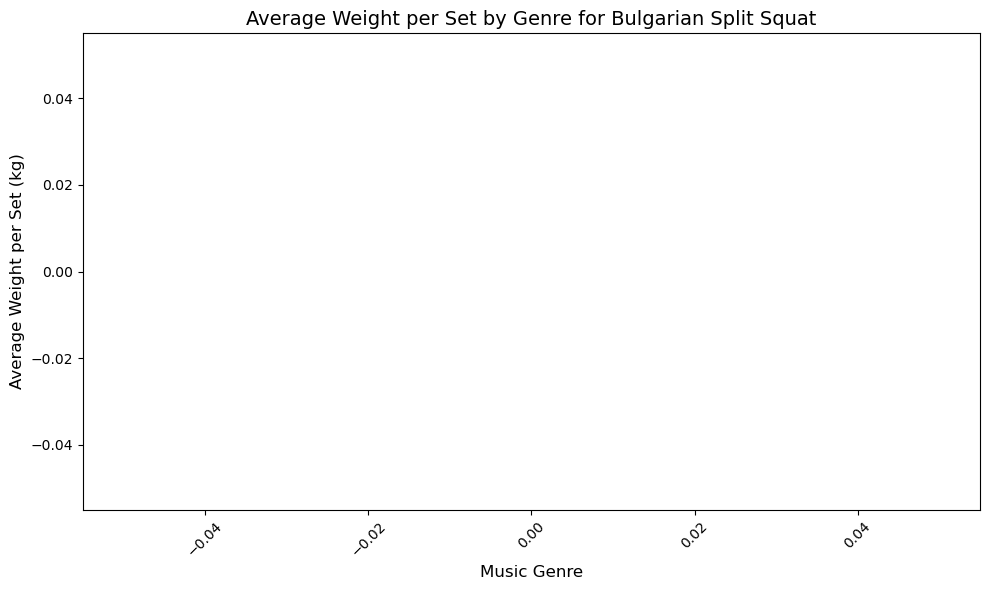

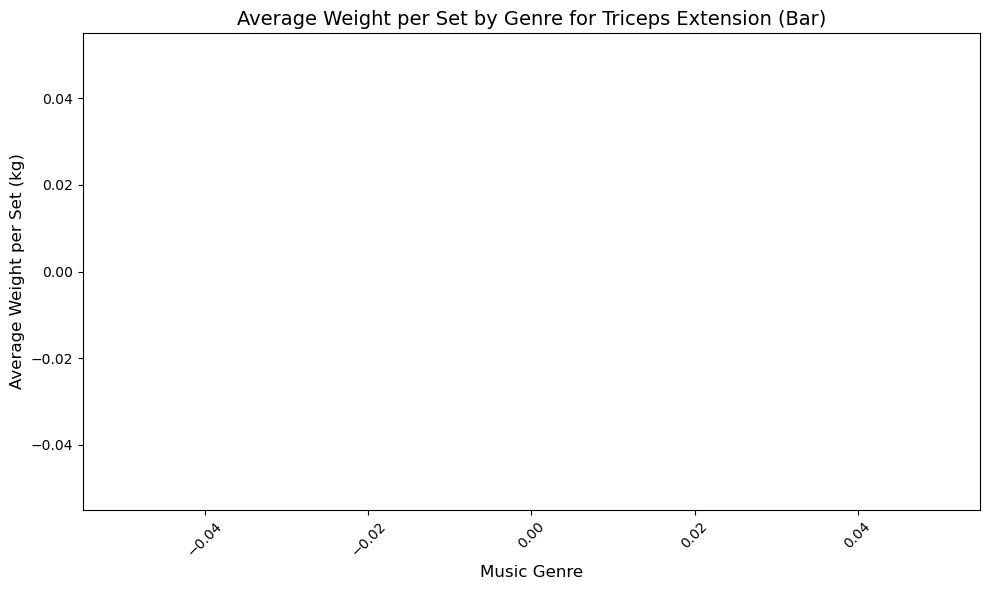

In [29]:
for exercise in unique_exercises:
    subset = cleaned_workout_data[cleaned_workout_data['exercise_title'] == exercise]

    # Plot average weight per set by genre
    genre_effects = subset.explode('matched_genres').groupby('matched_genres')['average_weight_per_set'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    plt.bar(genre_effects['matched_genres'], genre_effects['average_weight_per_set'])
    plt.title(f'Average Weight per Set by Genre for {exercise}', fontsize=14)
    plt.xlabel('Music Genre', fontsize=12)
    plt.ylabel('Average Weight per Set (kg)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot tempo distribution
    overlapping_music = music_data[music_data['Genre'].isin(subset.explode('matched_genres')['matched_genres'].unique())]
    if not overlapping_music.empty:
        plt.figure(figsize=(10, 6))
        overlapping_music.boxplot(column='Tempo', by='Genre', grid=False, rot=45)
        plt.title(f'Tempo Distribution by Genre for {exercise}', fontsize=14)
        plt.suptitle('')
        plt.xlabel('Music Genre', fontsize=12)
        plt.ylabel('Tempo (BPM)', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Plot energy distribution
        plt.figure(figsize=(10, 6))
        overlapping_music.boxplot(column='Energy', by='Genre', grid=False, rot=45)
        plt.title(f'Energy Distribution by Genre for {exercise}', fontsize=14)
        plt.suptitle('')
        plt.xlabel('Music Genre', fontsize=12)
        plt.ylabel('Energy', fontsize=12)
        plt.tight_layout()
        plt.show()


In [31]:
# Analyze tempo and energy features using linear regression
music_features = music_data[['Tempo', 'Energy']]
music_features = StandardScaler().fit_transform(music_features)
music_features_df = pd.DataFrame(music_features, columns=['Tempo', 'Energy'])
music_features_df['Genre'] = music_data['Genre']
merged_data = music_features_df.merge(
    cleaned_workout_data.explode('matched_genres')[['matched_genres', 'average_weight_per_set']].rename(columns={'matched_genres': 'Genre'}),
    on='Genre',
    how='inner'
).dropna(subset=['average_weight_per_set'])
X = merged_data[['Tempo', 'Energy']]
y = merged_data['average_weight_per_set']
regression_model = LinearRegression().fit(X, y)
regression_coefficients = regression_model.coef_
regression_r2 = regression_model.score(X, y)

# Display analysis results
print("Regression Coefficients:", regression_coefficients)
print("R-squared:", regression_r2)


Regression Coefficients: [0.06724529 0.01389485]
R-squared: 1.1917362200408732e-05


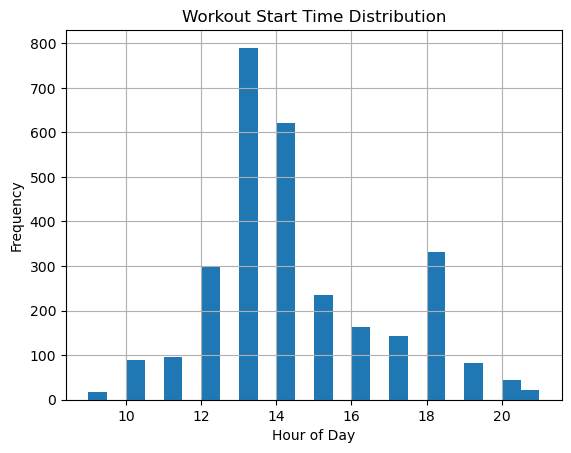

In [35]:
cleaned_workout_data['start_time'].dt.hour.hist(bins=24)
plt.title('Workout Start Time Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()


Most Played Genres:
Rock          235
Hip-Hop       208
Electronic    196
R&B           186
Phonk         167
Name: matched_genres, dtype: int64


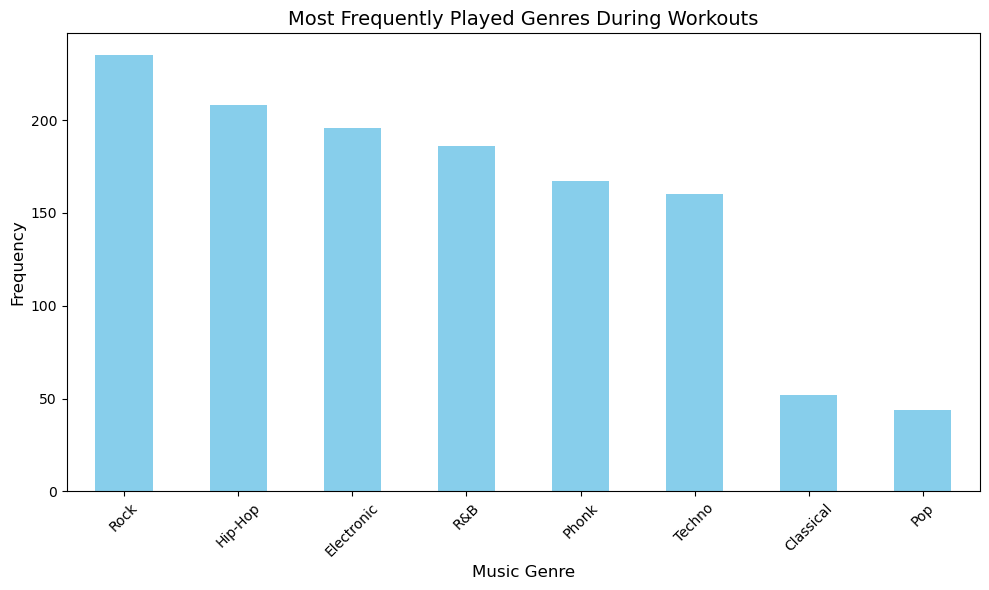

In [38]:
# Additional Analysis: Most Frequently Played Genre
# Count the occurrences of each music genre during workouts
most_played_genres = cleaned_workout_data.explode('matched_genres')['matched_genres'].value_counts()
print("Most Played Genres:")
print(most_played_genres.head())

# Plot the most frequently played genres
plt.figure(figsize=(10, 6))
most_played_genres.head(10).plot(kind='bar', color='skyblue')
plt.title('Most Frequently Played Genres During Workouts', fontsize=14)
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Most Played Genres Overall:
Hip-Hop       756
Rock          729
Electronic    719
Classical     714
Techno        712
Name: Genre, dtype: int64


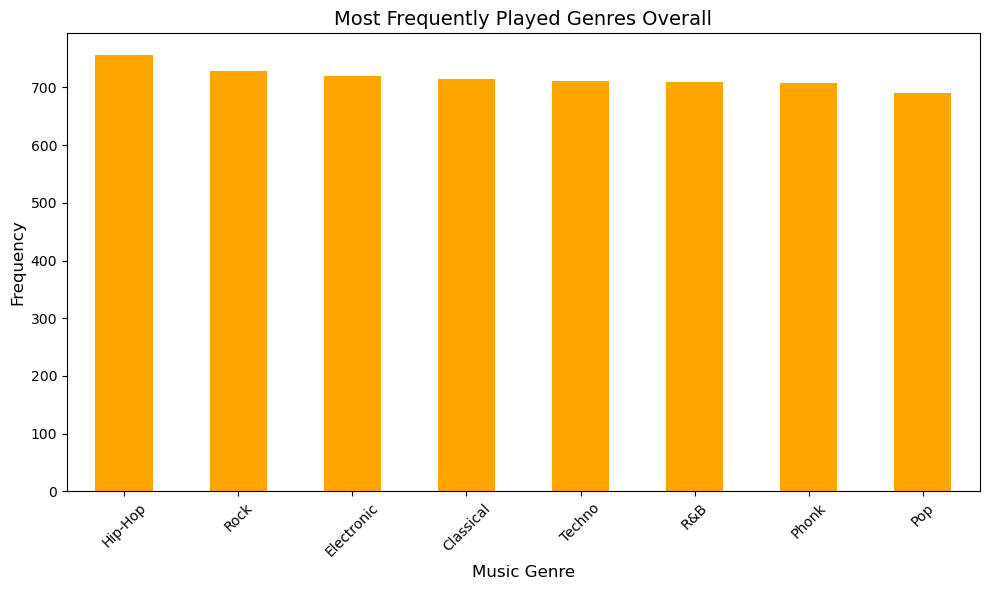

In [39]:
# Additional Analysis: Most Frequently Played Genres Overall
# Count the occurrences of each music genre in the original music dataset
most_played_genres_overall = music_data['Genre'].value_counts()
print("Most Played Genres Overall:")
print(most_played_genres_overall.head())

# Plot the most frequently played genres overall
plt.figure(figsize=(10, 6))
most_played_genres_overall.head(10).plot(kind='bar', color='orange')
plt.title('Most Frequently Played Genres Overall', fontsize=14)
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()